In [6]:
import sys
import os
sys.path.append("../src/")
import combat
import numpy as np
import scipy.stats as stats
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import sklearn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sb
import pickle as pkl
from sklearn.linear_model import LogisticRegression, Lasso, Ridge, ElasticNet
import random as rd
import matplotlib
matplotlib.rcParams['figure.dpi'] = 500
from sklearn.preprocessing import quantile_transform,binarize
from sklearn.model_selection import LeaveOneOut,KFold
from sklearn.metrics import r2_score
from statsmodels.stats.multitest import multipletests
from sklearn.cross_decomposition import PLSRegression as PLS
import warnings
warnings.simplefilter("ignore")
from multiprocessing import Process,Queue,Pool
import time 
import helper
from multiprocessing import set_start_method
#set_start_method("spawn")
from DecoID.DecoID import flatten
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVC
import importlib
import helper#import the module here, so that it can be reloaded.
importlib.reload(helper)
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multitest import multipletests


In [7]:
var_imp = pd.read_csv("../data/var_importance_final.csv",index_col=0)
var_imp

var_imp
HSSneg_LPE 18:0@7.653           -0.001013
HSSpos_Cer_NS d18:1_16:0_17.788  0.001118
HSSpos_Cer_NS d18:2_16:0_16.67   0.000905
HSSpos_LPC 0:0/16:0_4.715       -0.000702
HSSpos_LPC 0:0/18:0_6.997       -0.001206
HSSpos_LPC 14:0/0:0_3.387       -0.000405
HSSpos_LPC 15:0/0:0_4.164       -0.000155
HSSpos_LPC 16:0/0:0_5.147       -0.000232
HSSpos_LPC 16:1/0:0_3.734        0.000187
HSSpos_LPC 17:0/0:0_6.28        -0.000472
HSSpos_LPC 18:0/0:0_7.547       -0.000484
HSSpos_LPC 18:1/0:0_5.589       -0.000179
HSSpos_LPC 18:2/0:0_4.195       -0.000797
HSSpos_LPC 18:3/0:0_3.277        0.000258
HSSpos_LPC 20:2/0:0_6.105       -0.000893
HSSpos_LPC 20:3/0:0_4.813       -0.000095
HSSpos_LPC 20:4/0:0_4.03        -0.000689
HSSpos_PC 18:2_22:6_15.427      -0.000657
HSSpos_PC 20:4_20:4_15.512      -0.000821
HSSpos_PC 38:6_15.829           -0.000319
HSSpos_PE 16:0_18:2_16.83        0.001923
HSSpos_PE 16:0_20:4_16.641       0.000716
pHILICneg_87_L Serine           -0.001287
pHILICpos_135_1 Methyladenosine  0.001322
pHILICpos_196_Kynurenic acid     0.001349

In [8]:
#load in metadata and peak areas and associate

#read in peak data
datafilename = "../data/QTof-B1-9_pHILIC_HSS_pos-neg_normalized.csv"
data = pd.read_csv(datafilename)

#get area columns
areaCols = data.columns.values[10:]

#get molecule names
mol_names = data["Compound Name"].values

#extract area data and transpose
areaData = data[areaCols].transpose()

#get batch information
batchInfo = [int(x.split("_")[0][1]) for x in list(areaData.index.values)]

areaData = areaData.to_numpy()
areaData = areaData.astype(np.float)

#get index of blanks
blankSamp = [x for x in range(len(areaCols)) if "Blank" in areaCols[x] and not "equil" in areaCols[x]]
print(len(blankSamp)," blanks")

#get index of qc
qcSamp = [x for x in range(len(areaCols)) if "NIST" in areaCols[x] and not "equil" in areaCols[x] ]
print(len(qcSamp)," qc samples")

#get index of wu350 samples
samp = [x for x in range(len(areaCols)) if "WU350" in areaCols[x] and not "equil" in areaCols[x]]
print(len(samp), "research samples")

#load in metadata
metadatafn = "../data/Experiment-Parameters_b1-9.csv"
metadata = pd.read_csv(metadatafn)

#extact sample names for d0_yes samples
metadata_rel = metadata[metadata["day-COVID"] == "d0_Yes"]
print(len(metadata_rel)," d0 Covid+ Samples")

            
#create sample name, ventilator status linkage
vent_dict = {}
metadata_dict = {}
for index,row in metadata_rel.iterrows():
    val = str(row["ICU"])
    sampName = row["Sample General Name"]
    if "es" in val:
        val = 1
    elif "o" in val:
        val = 0
    vent_dict[sampName] = val
    metadata_dict[sampName] = row

print(np.sum(list(vent_dict.values()))," ICU+ samples")
print(len(vent_dict) - np.sum(list(vent_dict.values())),"ICU- samples")

#link vent status to sample in peak data
vent_status = []
metadata_for_samples = []
patient_ids = []
for s in np.array(areaCols)[samp]:
    tmp = s
    if tmp in vent_dict:
        vent_status.append(vent_dict[tmp])
        metadata_for_samples.append(metadata_dict[tmp])
        patient_ids.append(metadata_dict[tmp]["WU-350"])
    else:
        vent_status.append(-1)
        metadata_for_samples.append(-1)
print("found vent info for",len([x for x in vent_status if x != -1]),"covid_ d0 samples")
samplesOfInterest = [x for x in range(len(vent_status)) if vent_status[x] != -1]

sampleInfoDict = {}
for index,row in metadata.iterrows():
    if row["WU-350"] in patient_ids:
        val = str(row["ICU"])
        if "es" in val:
            val = 1
        elif "o" in val:
            val = 0
        
        sampleInfoDict[row["Sample General Name"]] = {"patient":row["WU-350"],"ICU":val,
                                                      "Day_to_ICU":row["Epic: Time from symptom onset to ICU (days)"],
                                                     "sample_day":row["WU350-Symptom onset"],
                                                      "death":row["Mortality Status"]}

index = 0
samplesOfInterest = []
for s in np.array(areaCols)[samp]:
    tmp = s
    if tmp in sampleInfoDict:
        samplesOfInterest.append(index)
        sampleInfoDict[tmp]["index"] = index
    index += 1
    
sampleInfoDict = {key:val for key,val in sampleInfoDict.items() if "index" in val}
sampleInfoDict = pd.DataFrame.from_dict(sampleInfoDict,orient="index")
print("found logitudinal info for: ",len(sampleInfoDict))

tmp = sampleInfoDict[sampleInfoDict["ICU"] == 1]
tmp = tmp[tmp["Day_to_ICU"] == "None"]
sampleInfoDict = sampleInfoDict.drop(tmp.index.values,axis=0)


#create sample matrix
samp_int = np.log2(areaData[samp])

vars_of_interest = []
for x in var_imp.index.values:
    index = 0
    for y in mol_names:
        if x == y:
            vars_of_interest.append(index)
            break
        index += 1 
        
samp_int = samp_int[:,vars_of_interest]
print(samp_int.shape)

0  blanks
0  qc samples
704 research samples
264  d0 Covid+ Samples
123  ICU+ samples
141 ICU- samples
found vent info for 263 covid_ d0 samples
found logitudinal info for:  603
(704, 25)


HSSpos_Cer_NS d18:1_16:0_17.788 0.022122143226108944
HSSpos_LPC 14:0/0:0_3.387 0.046541396665643955
HSSpos_LPC 16:1/0:0_3.734 0.046541396665643955
HSSpos_LPC 18:1/0:0_5.589 0.046541396665643955
HSSpos_LPC 18:2/0:0_4.195 0.046541396665643955
HSSpos_LPC 18:3/0:0_3.277 0.046541396665643955
HSSpos_LPC 20:2/0:0_6.105 0.046541396665643955
HSSpos_PC 38:6_15.829 0.046541396665643955


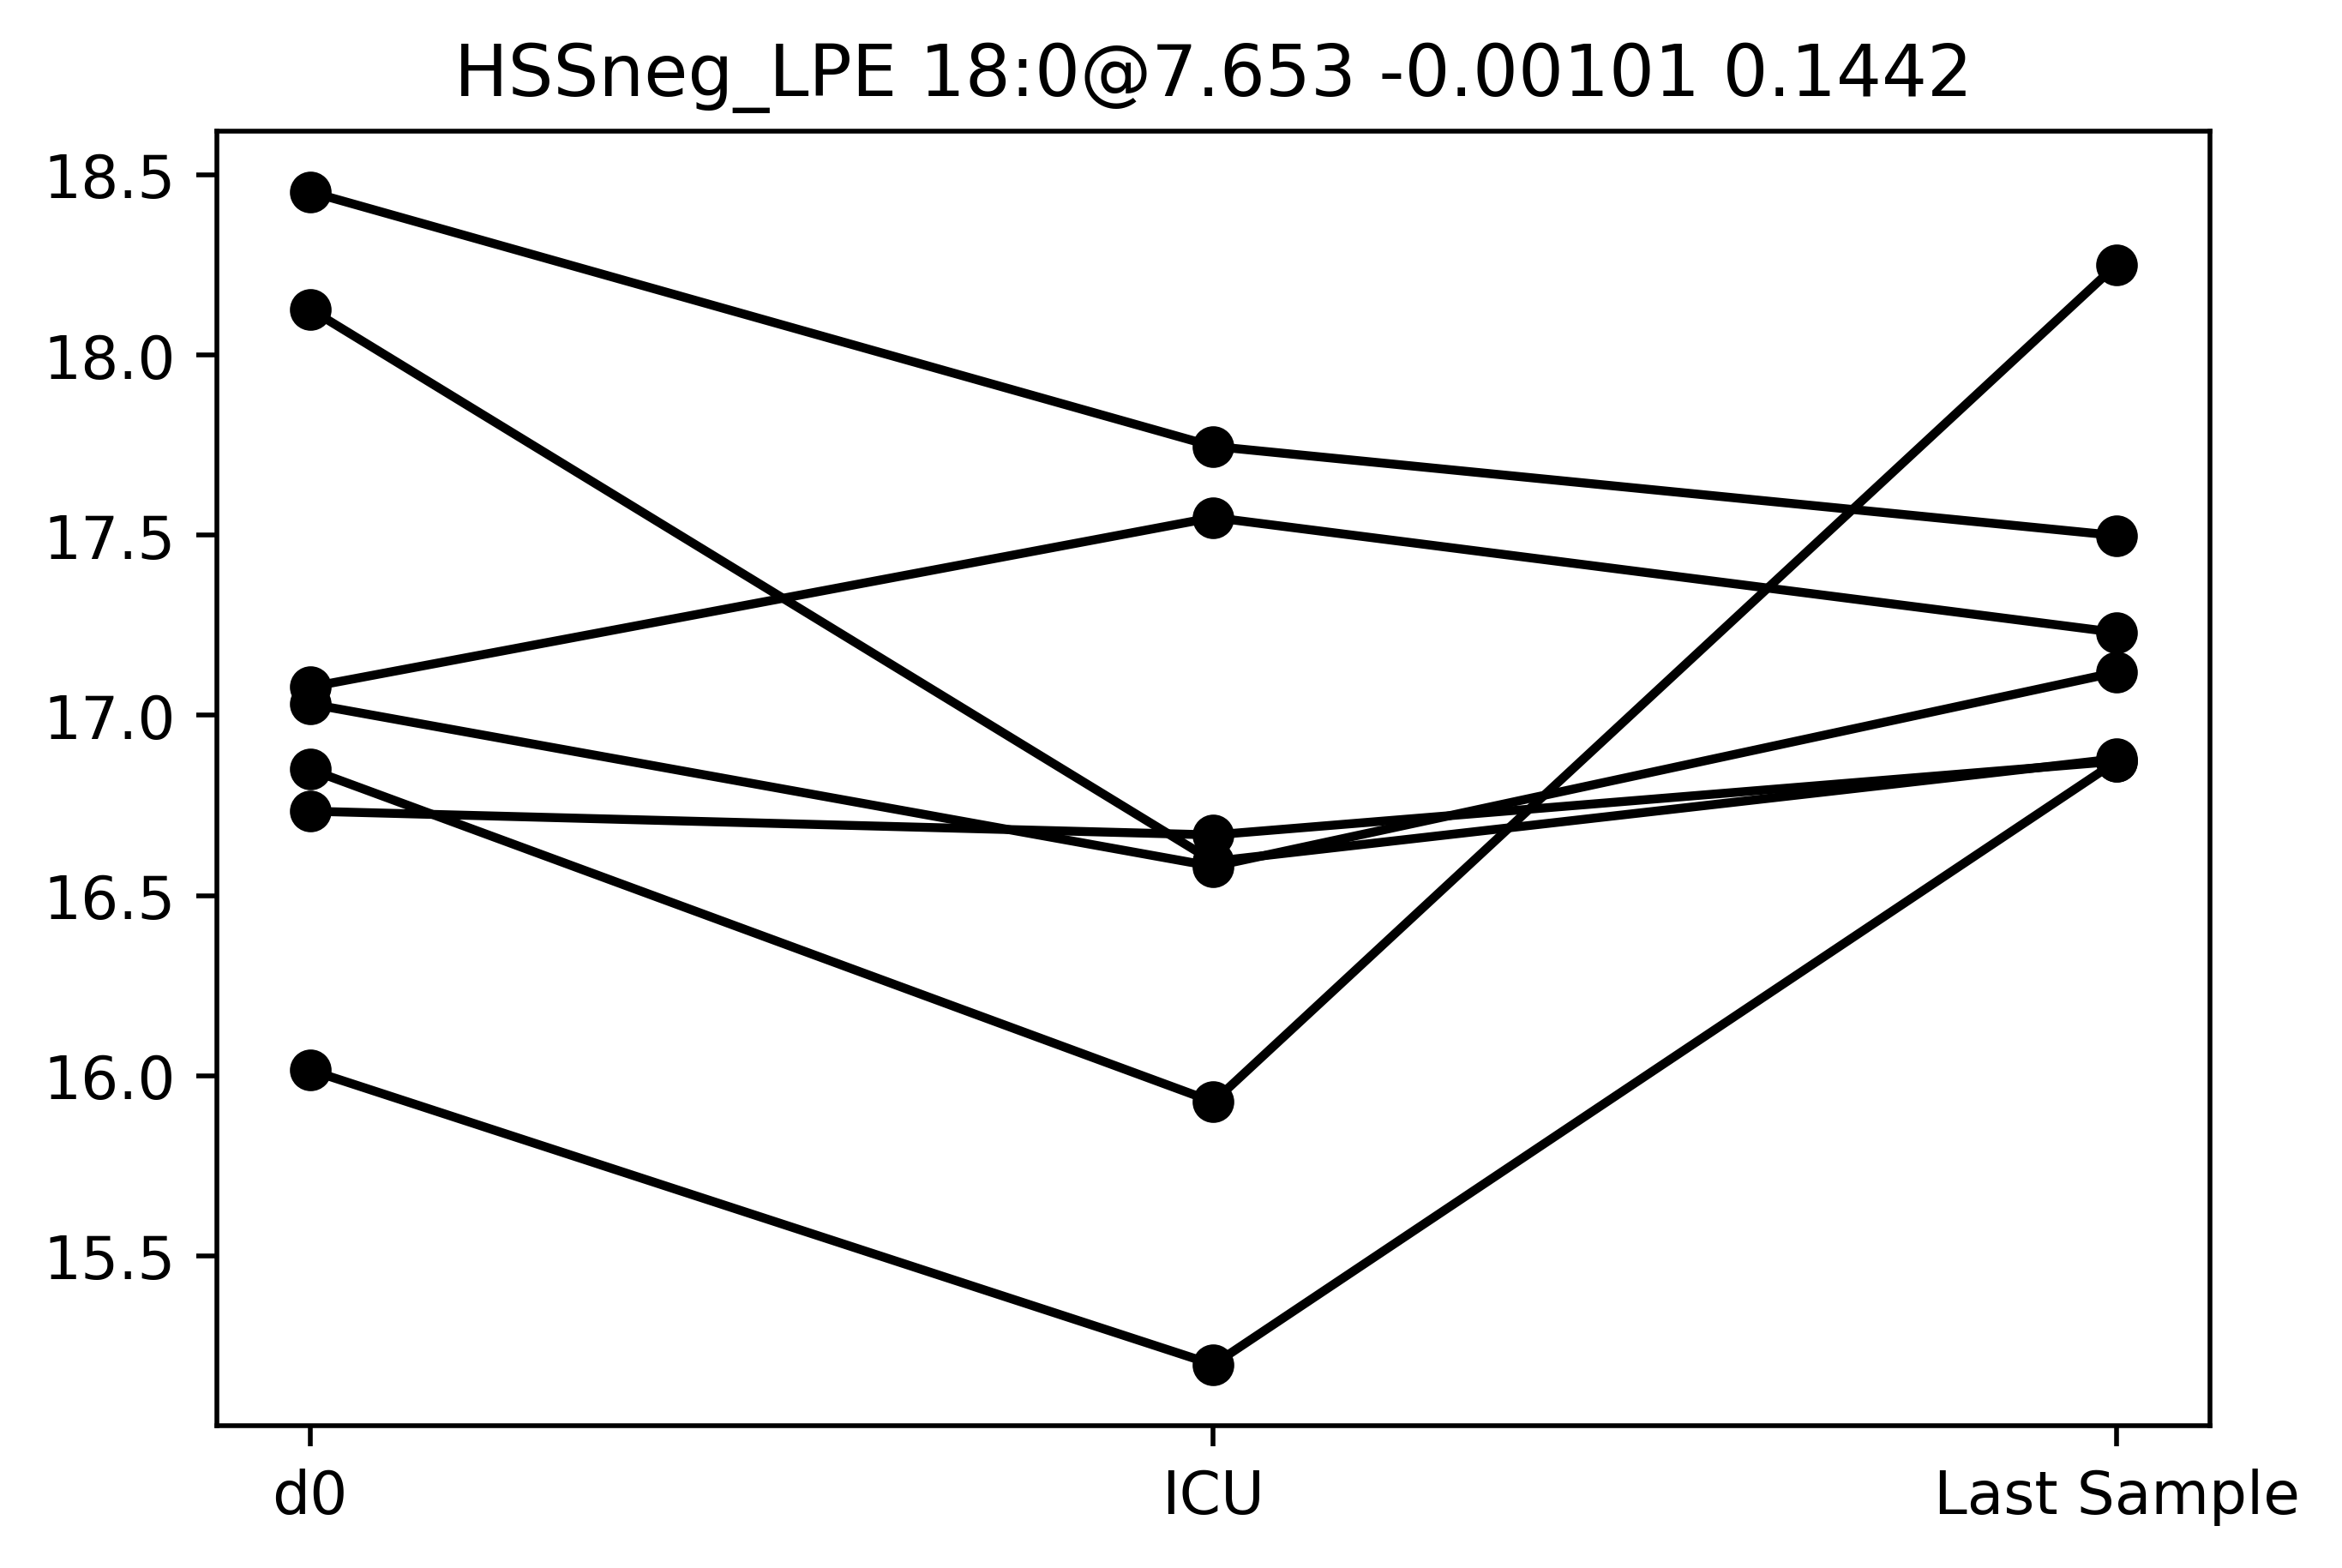

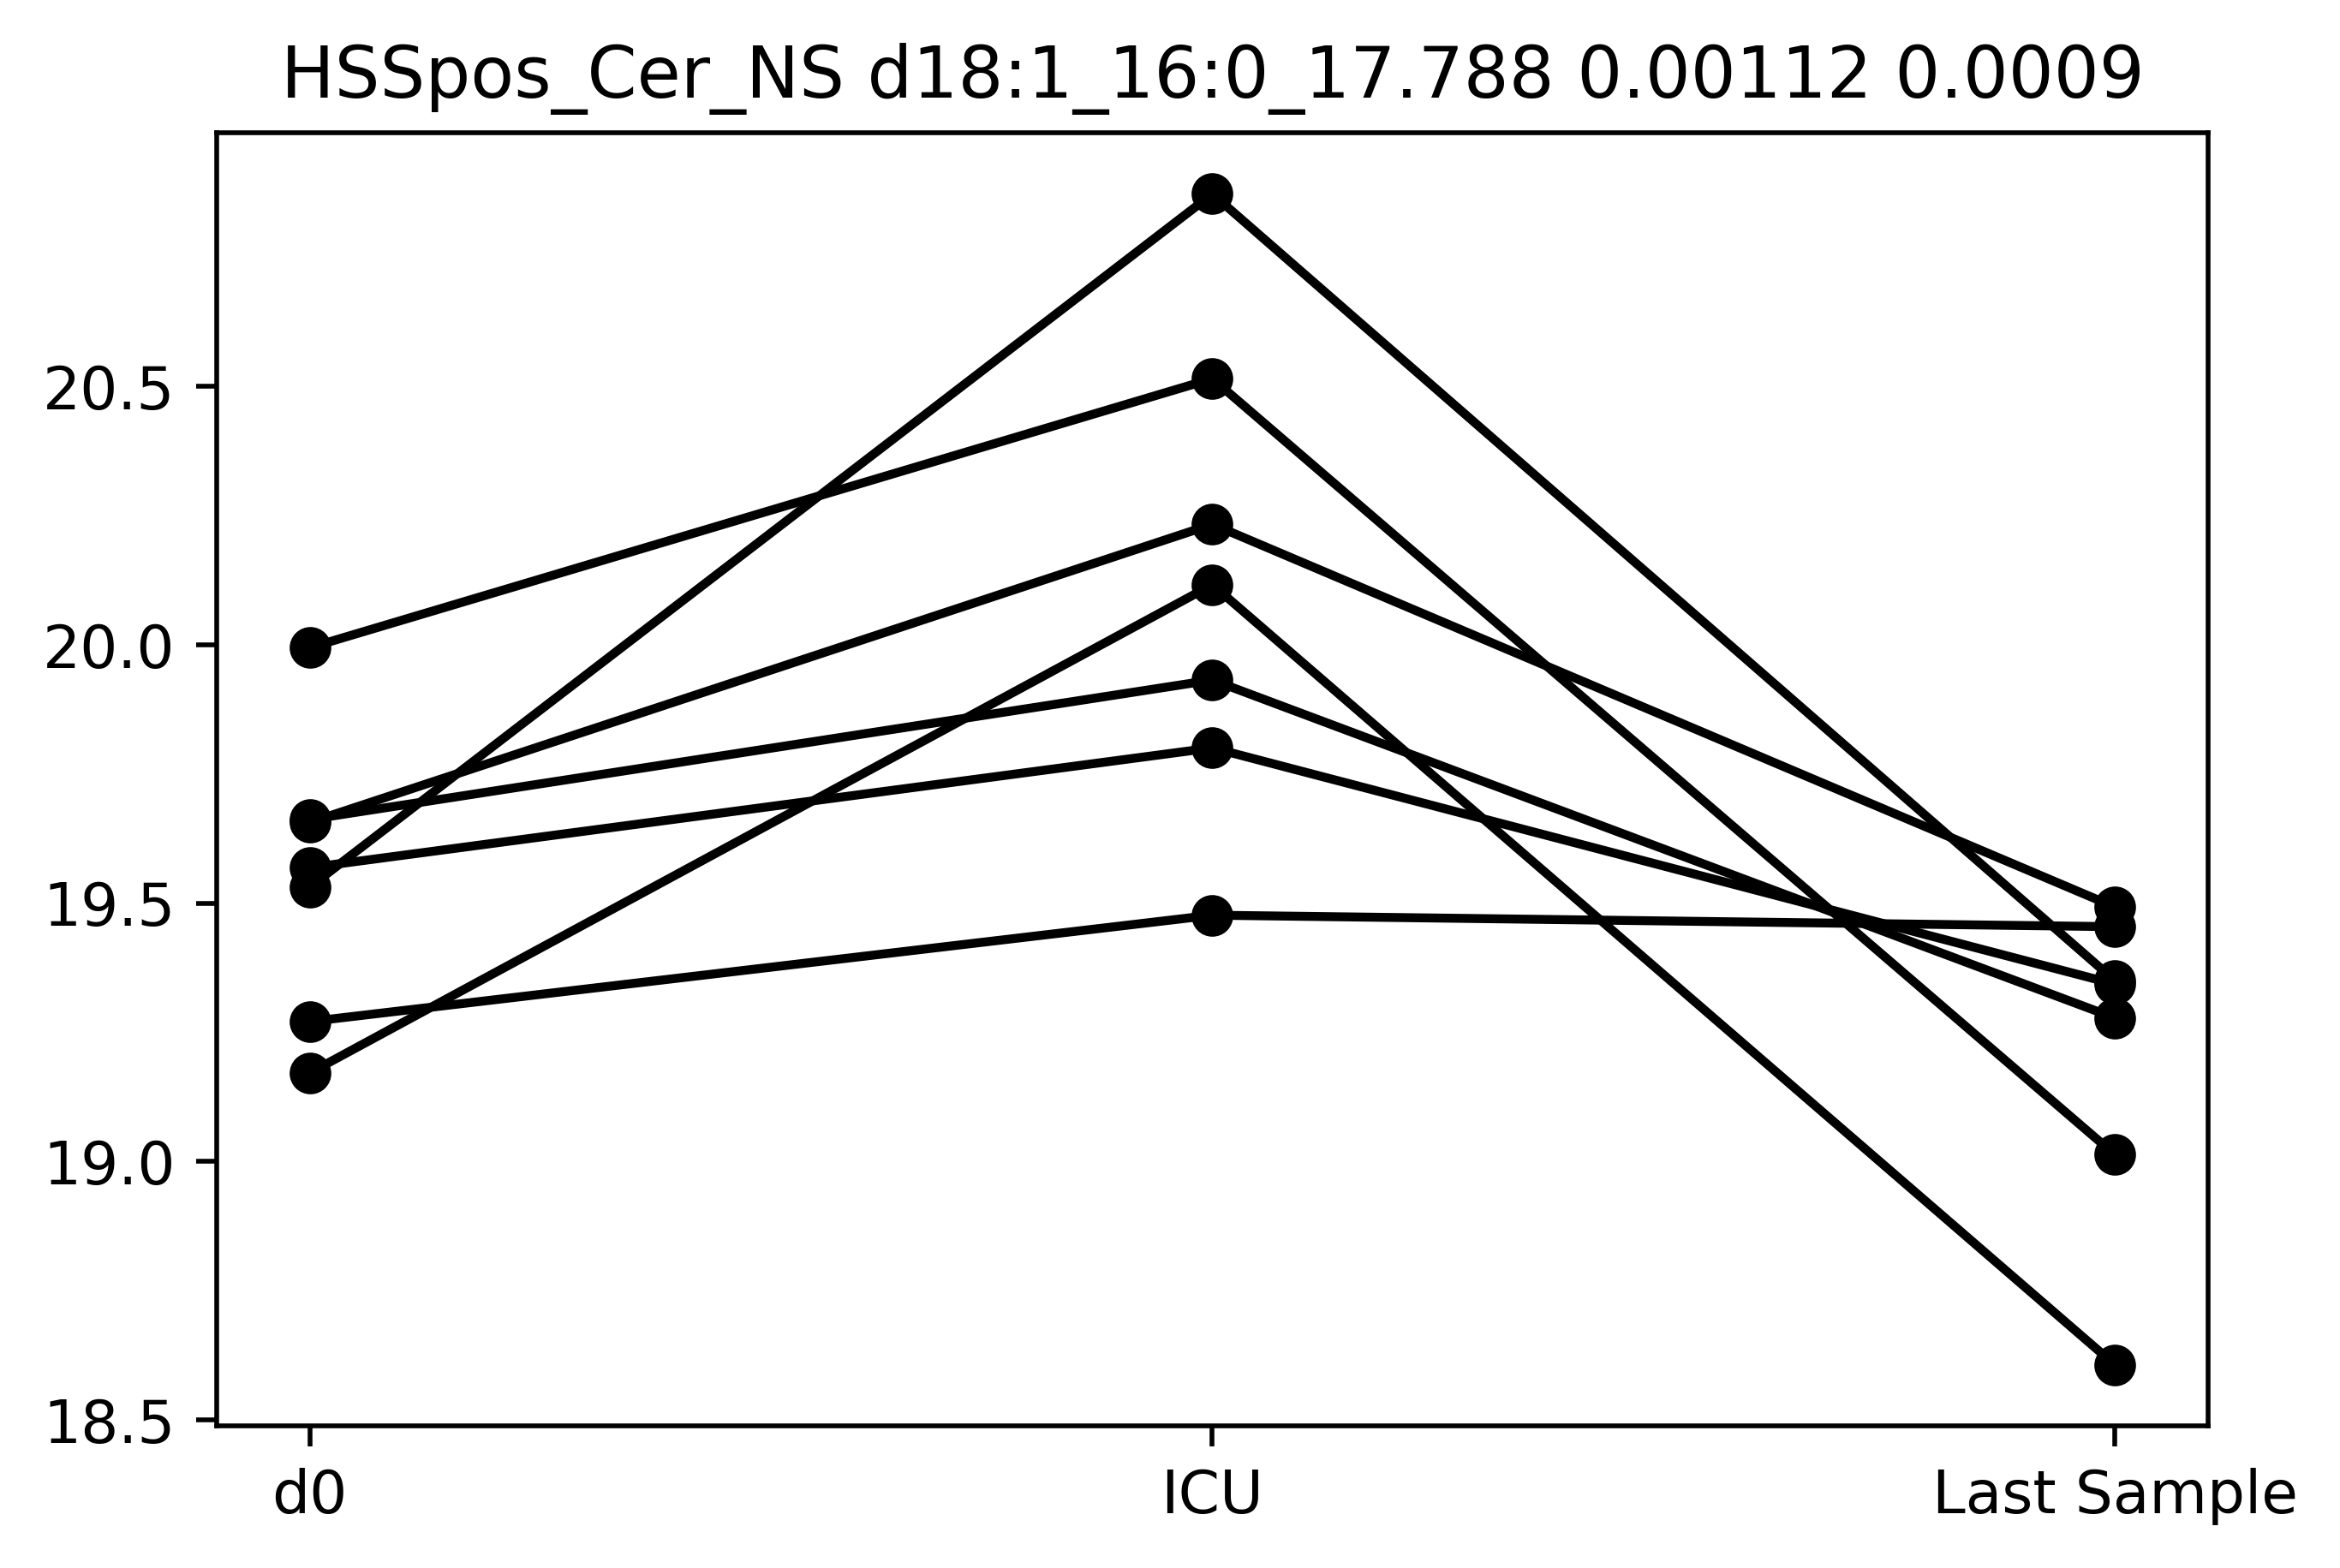

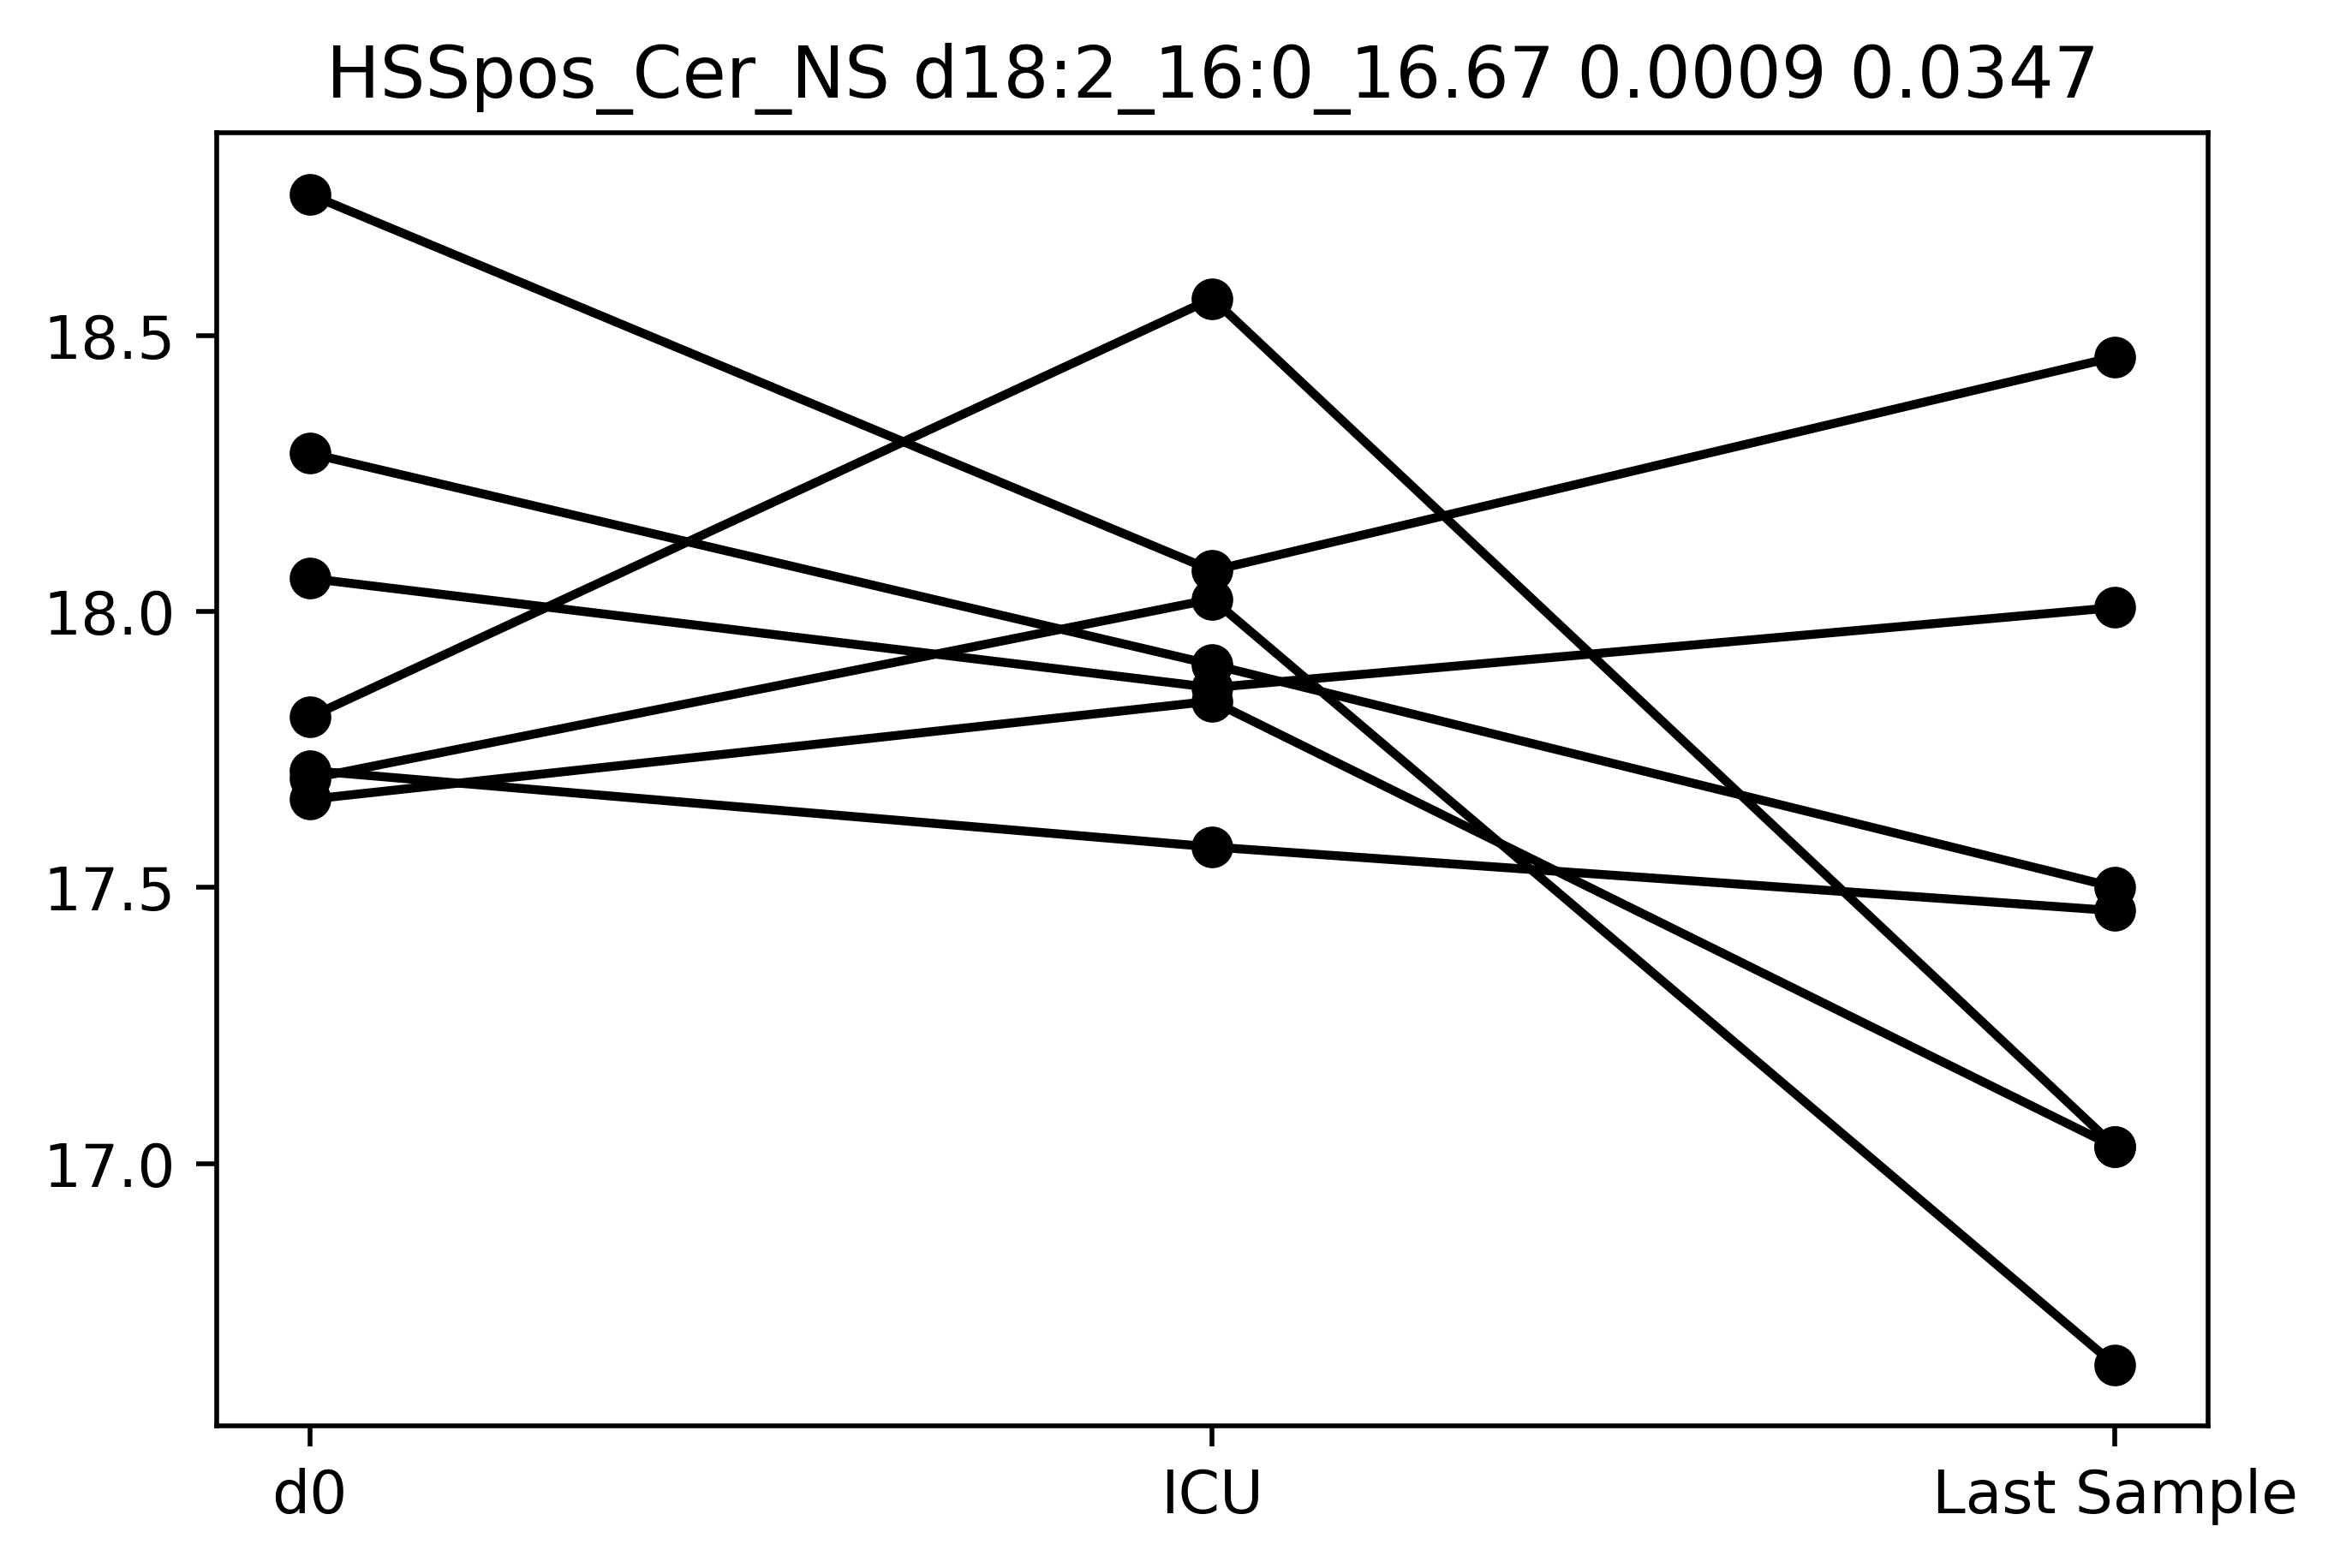

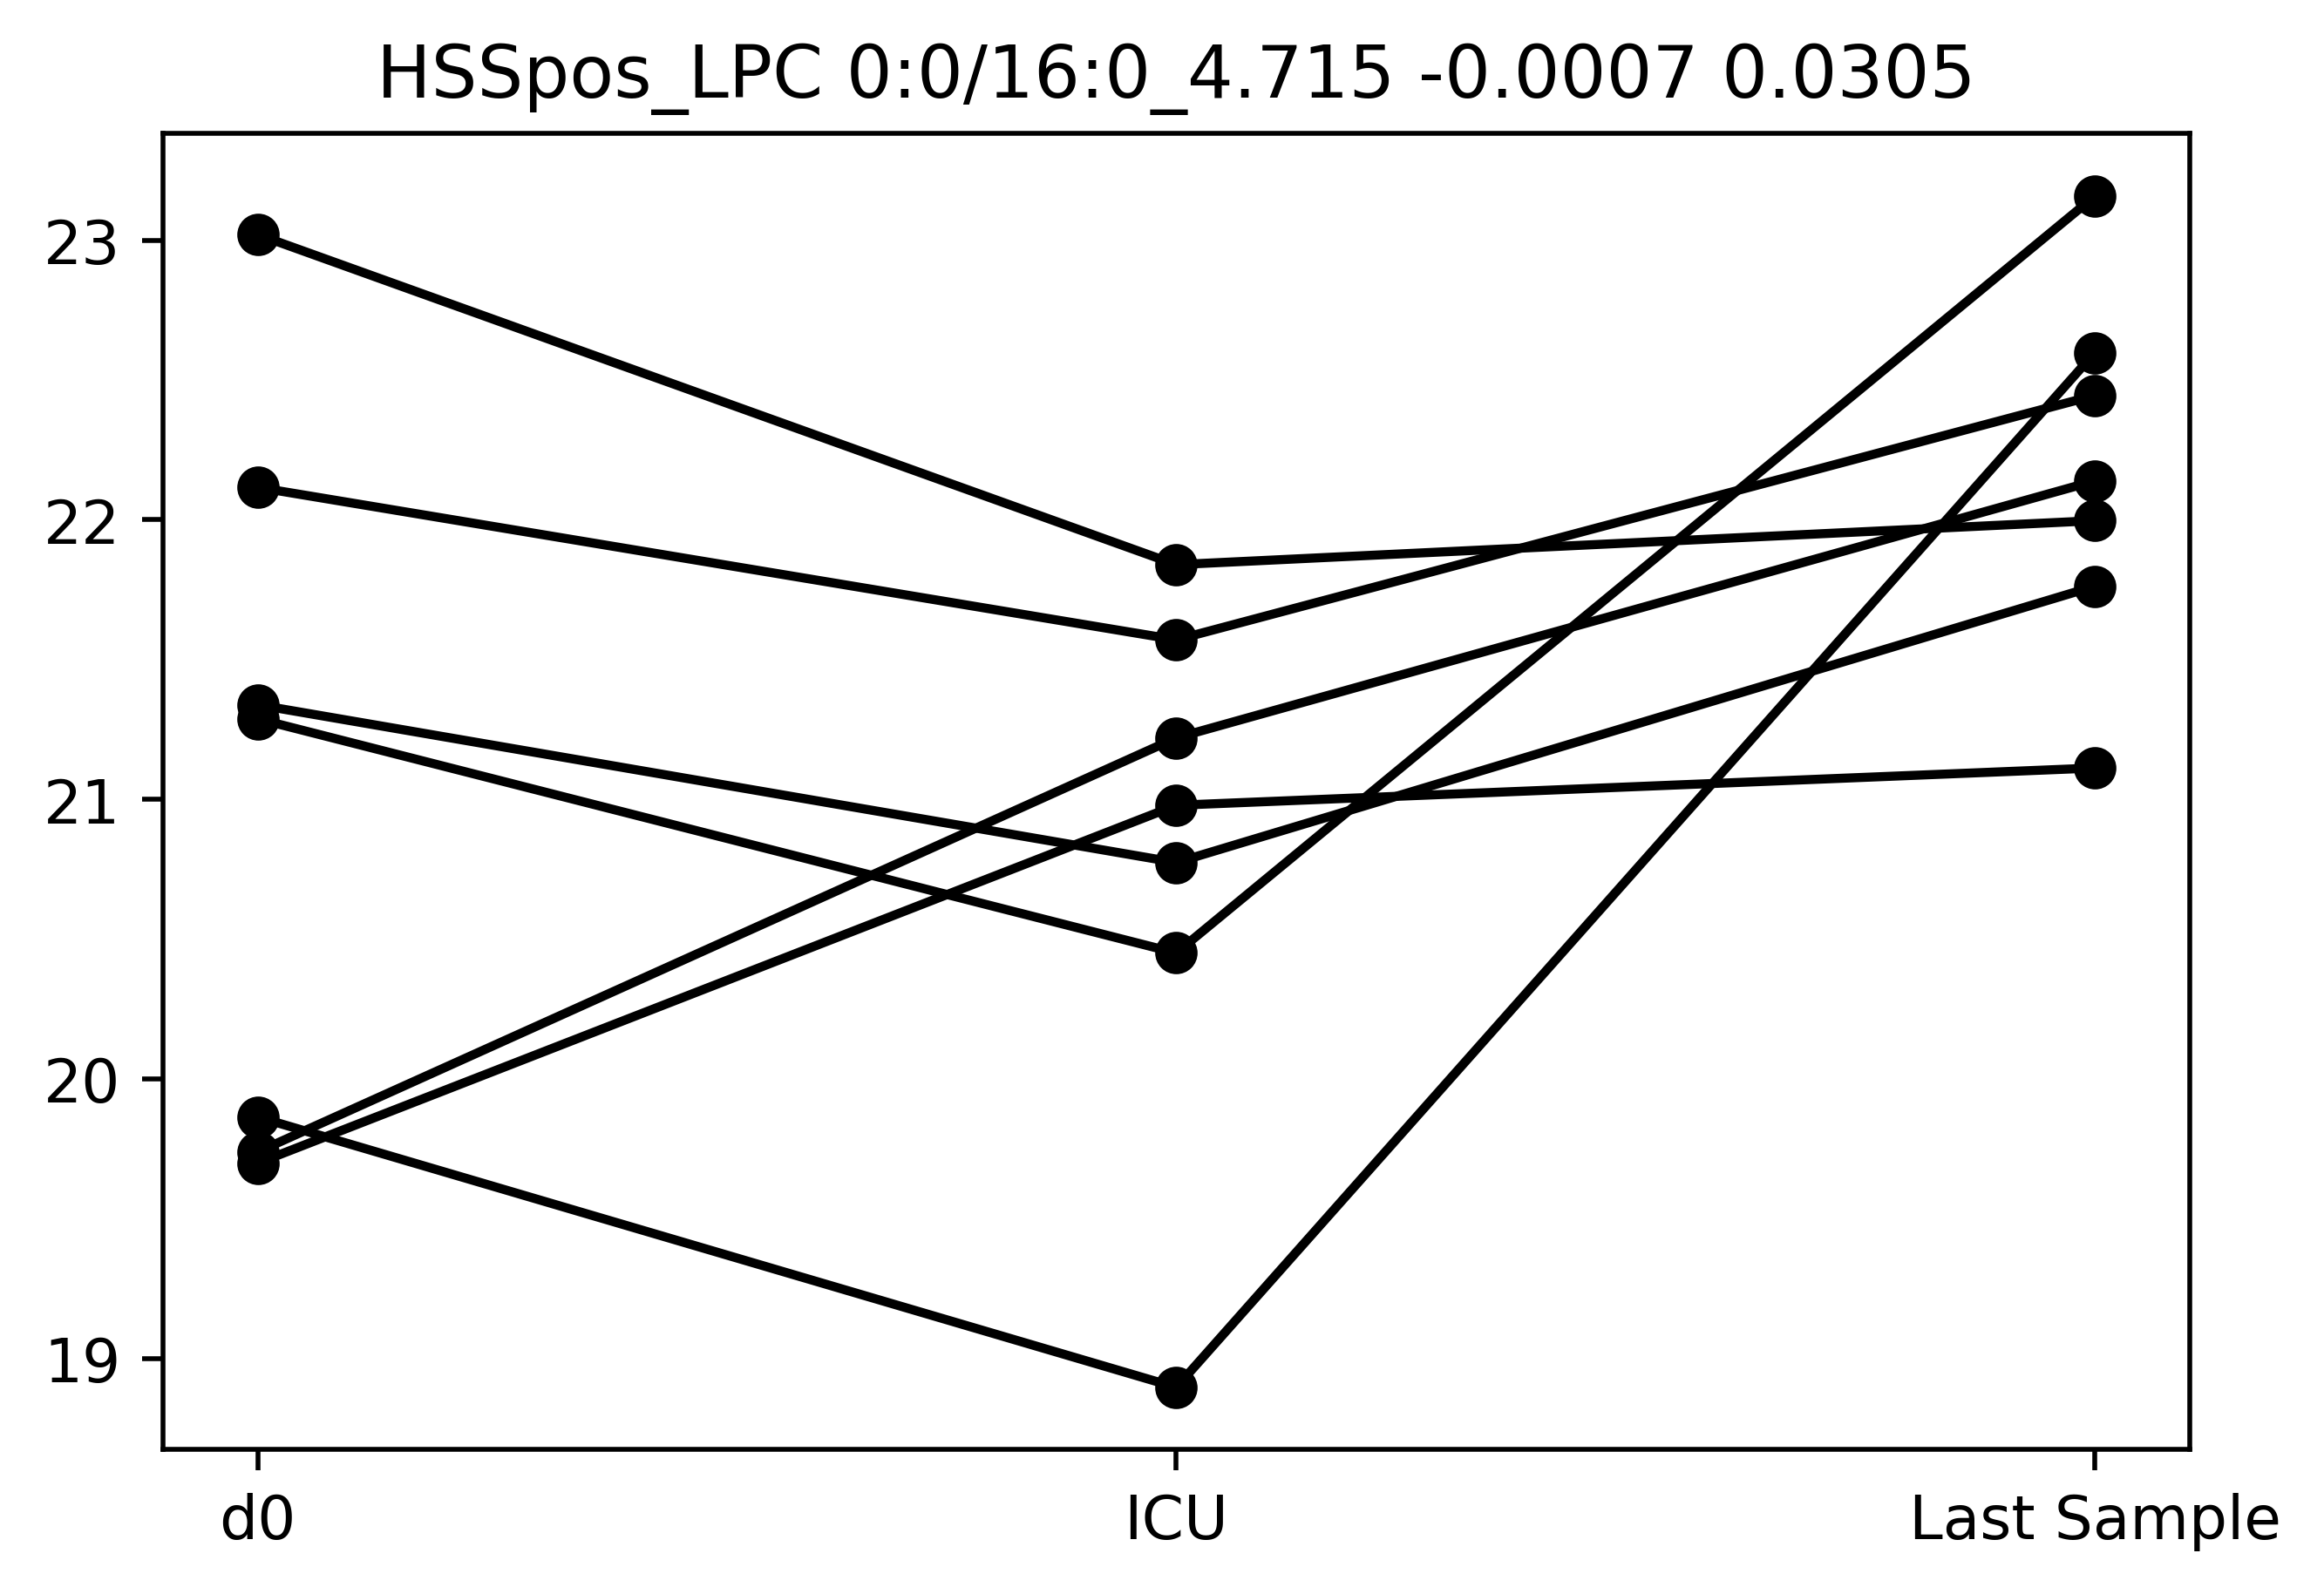

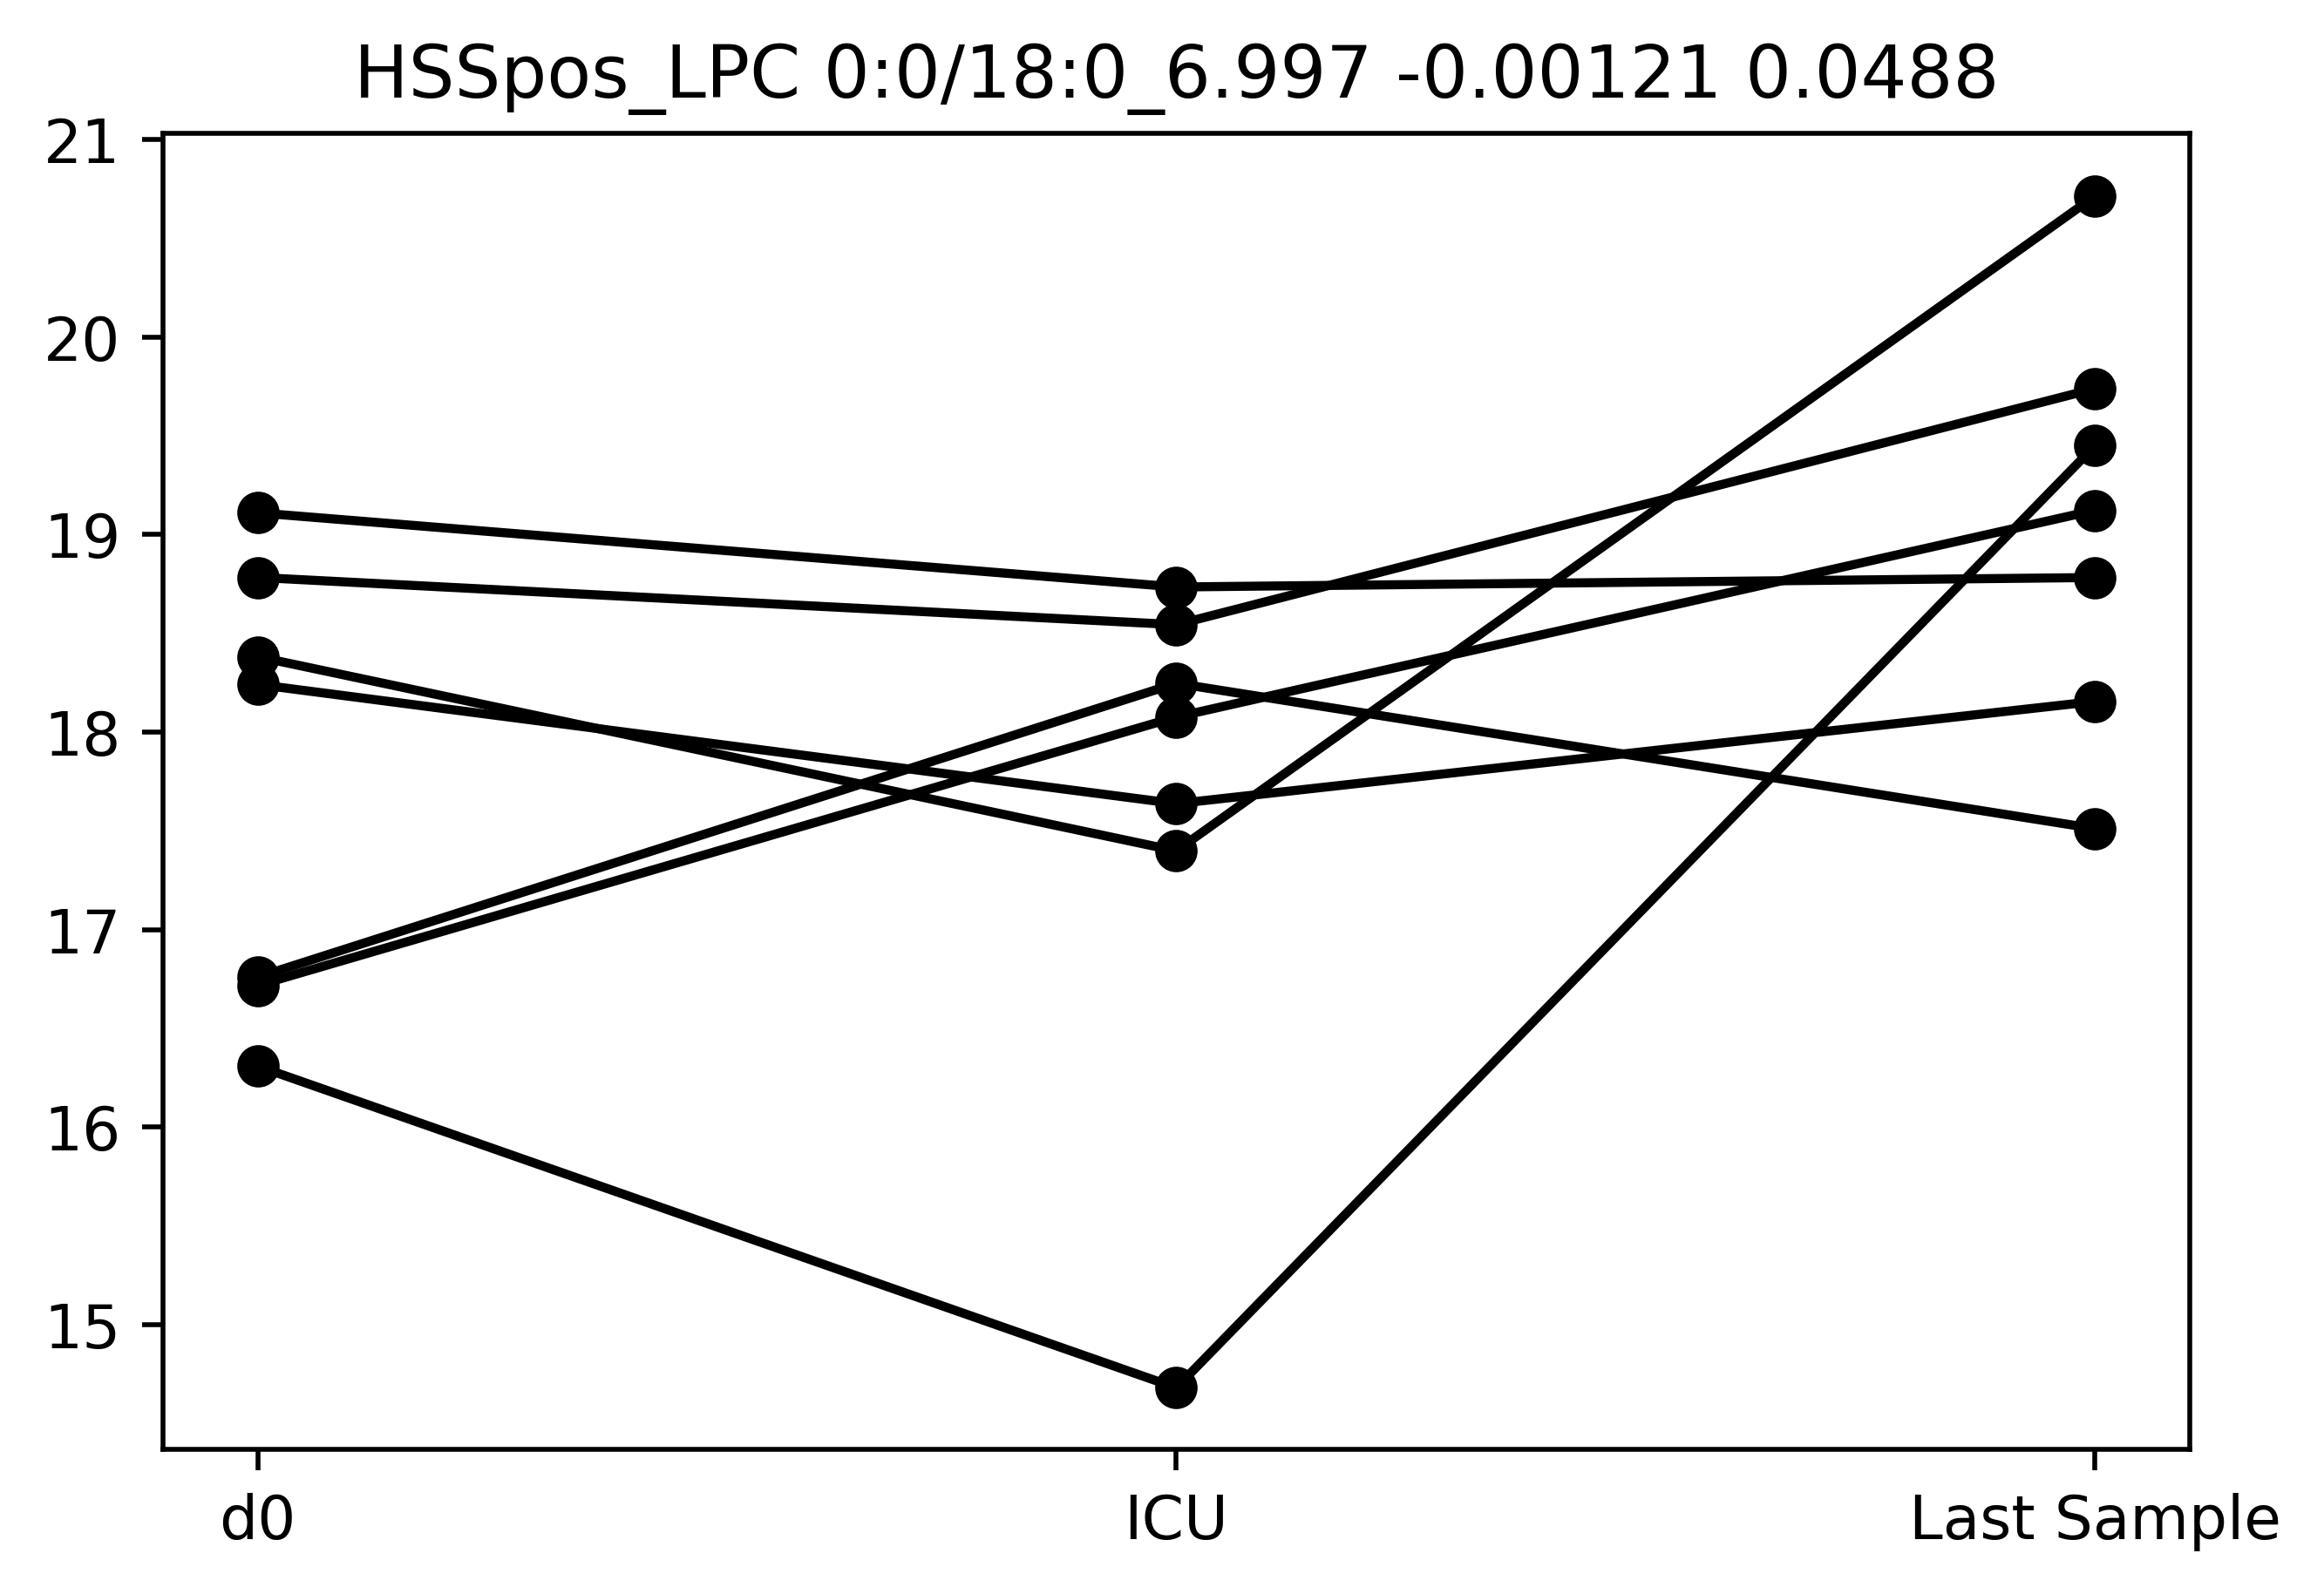

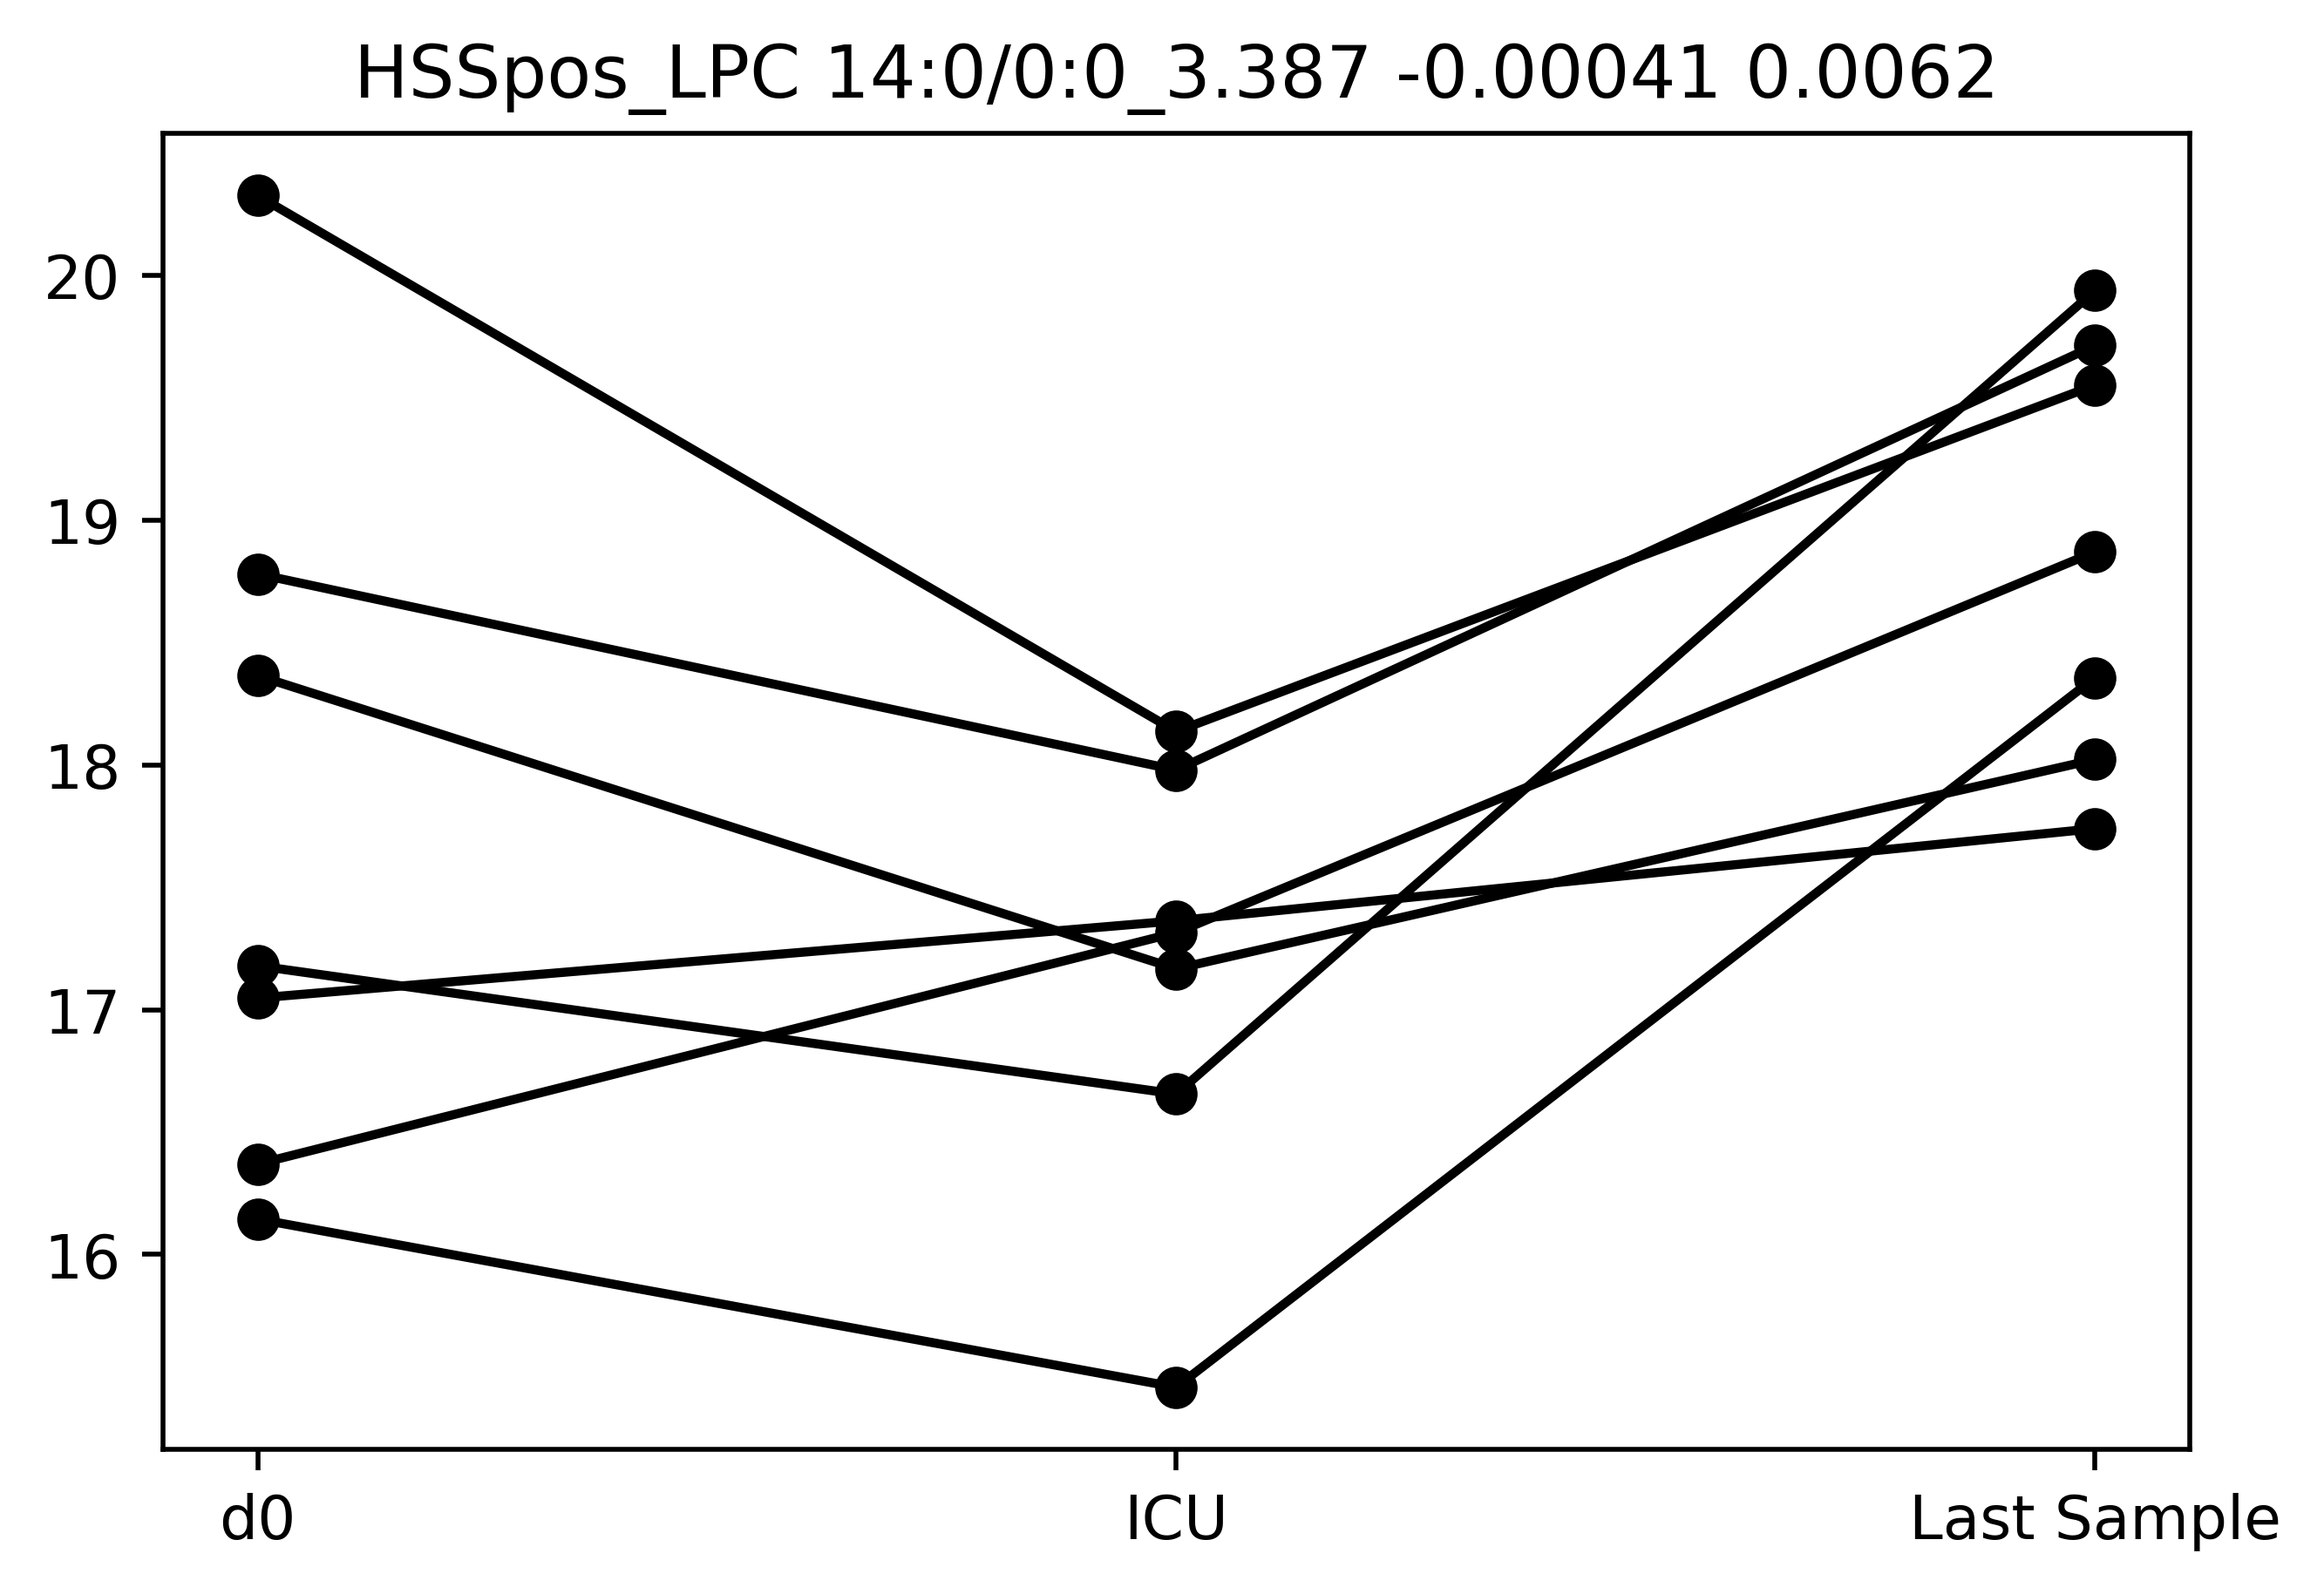

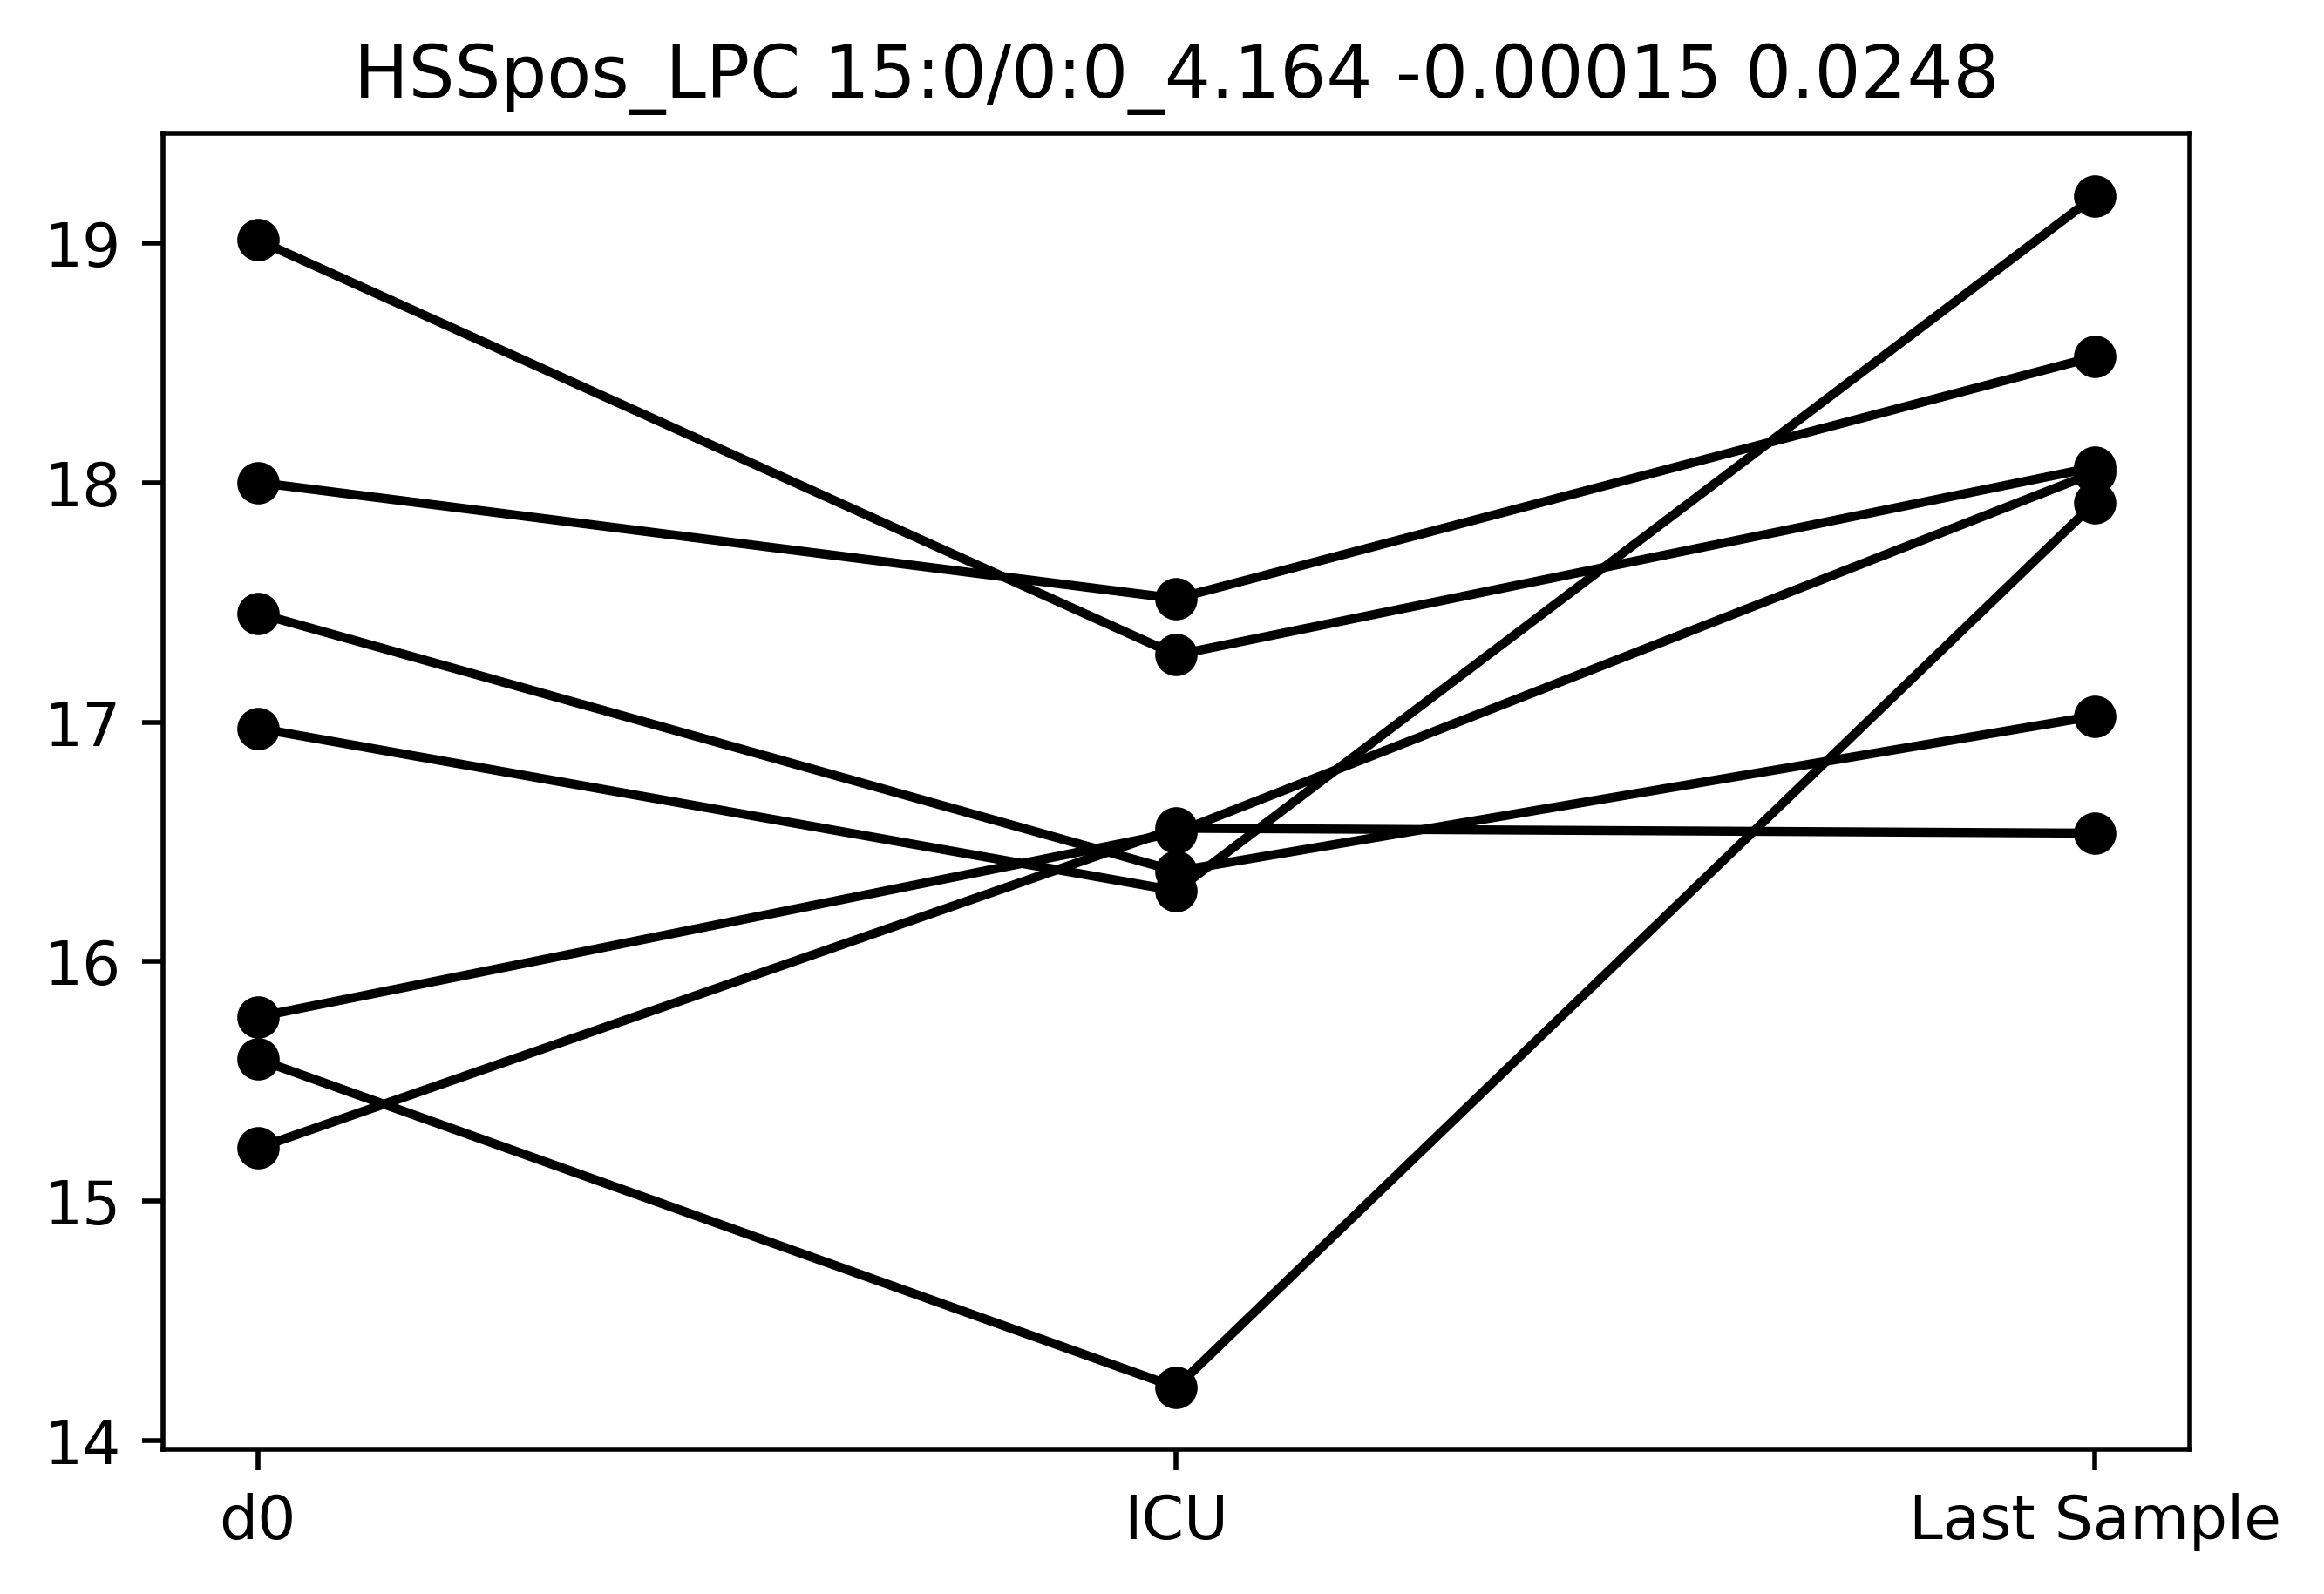

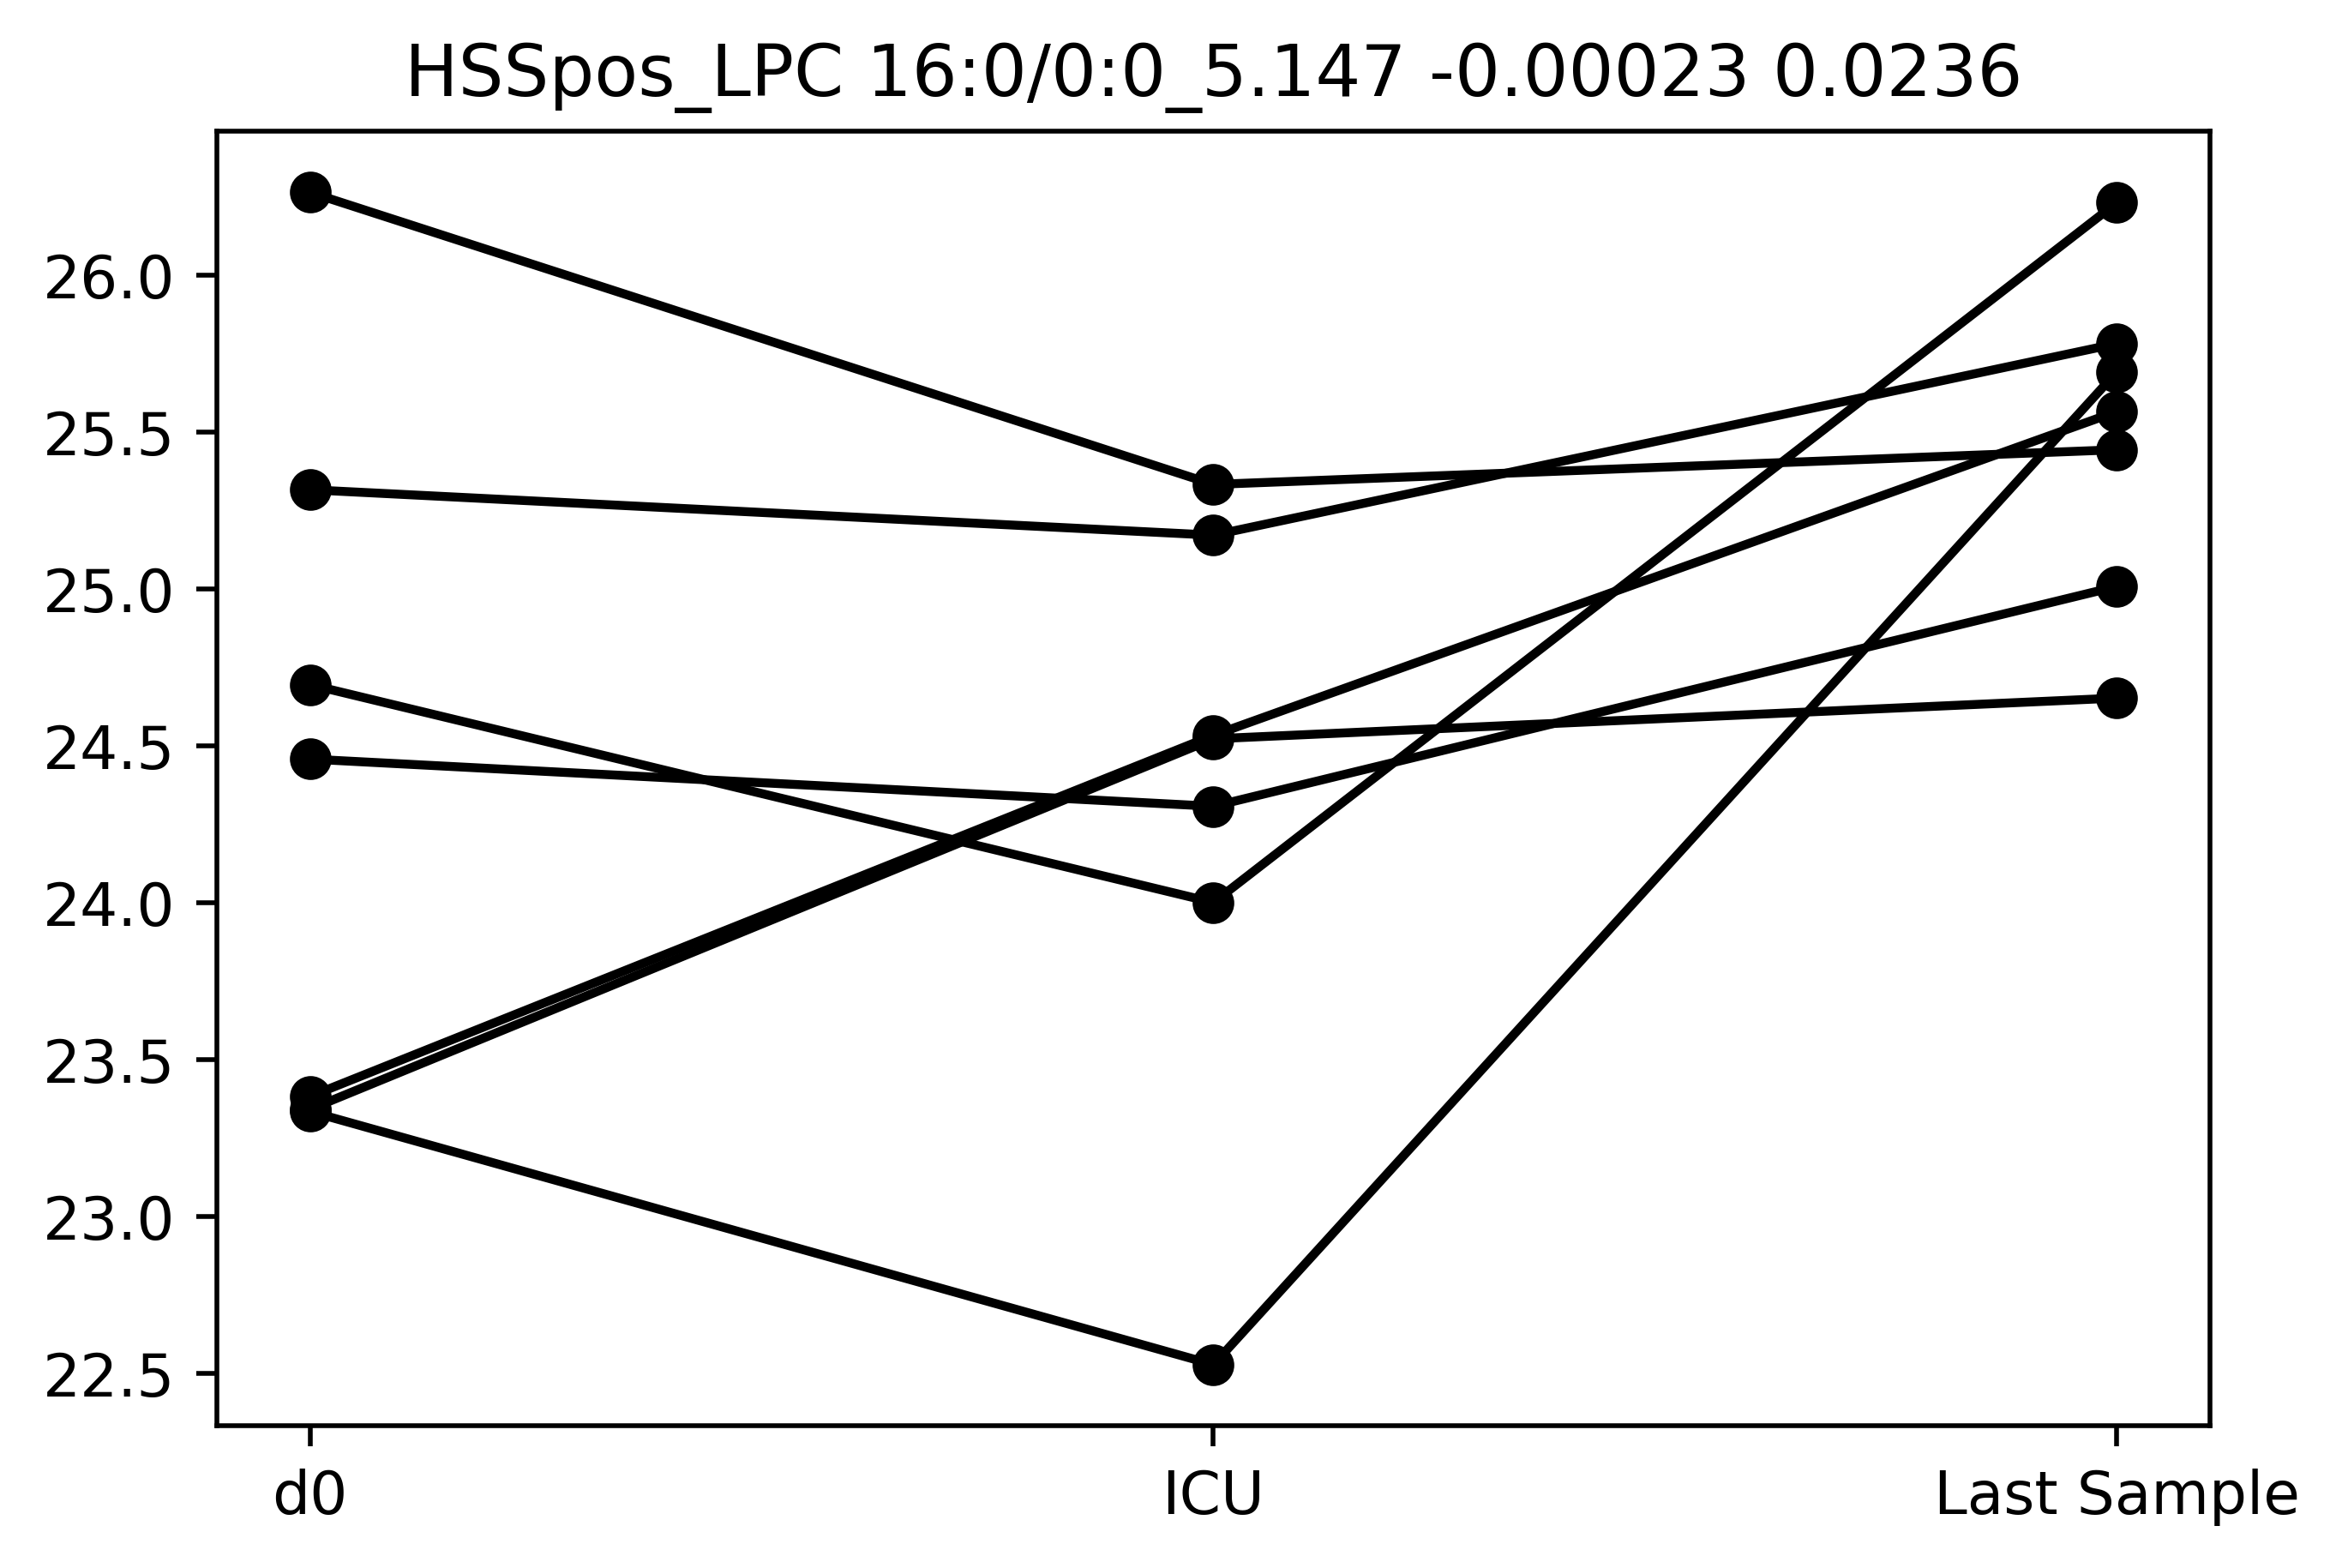

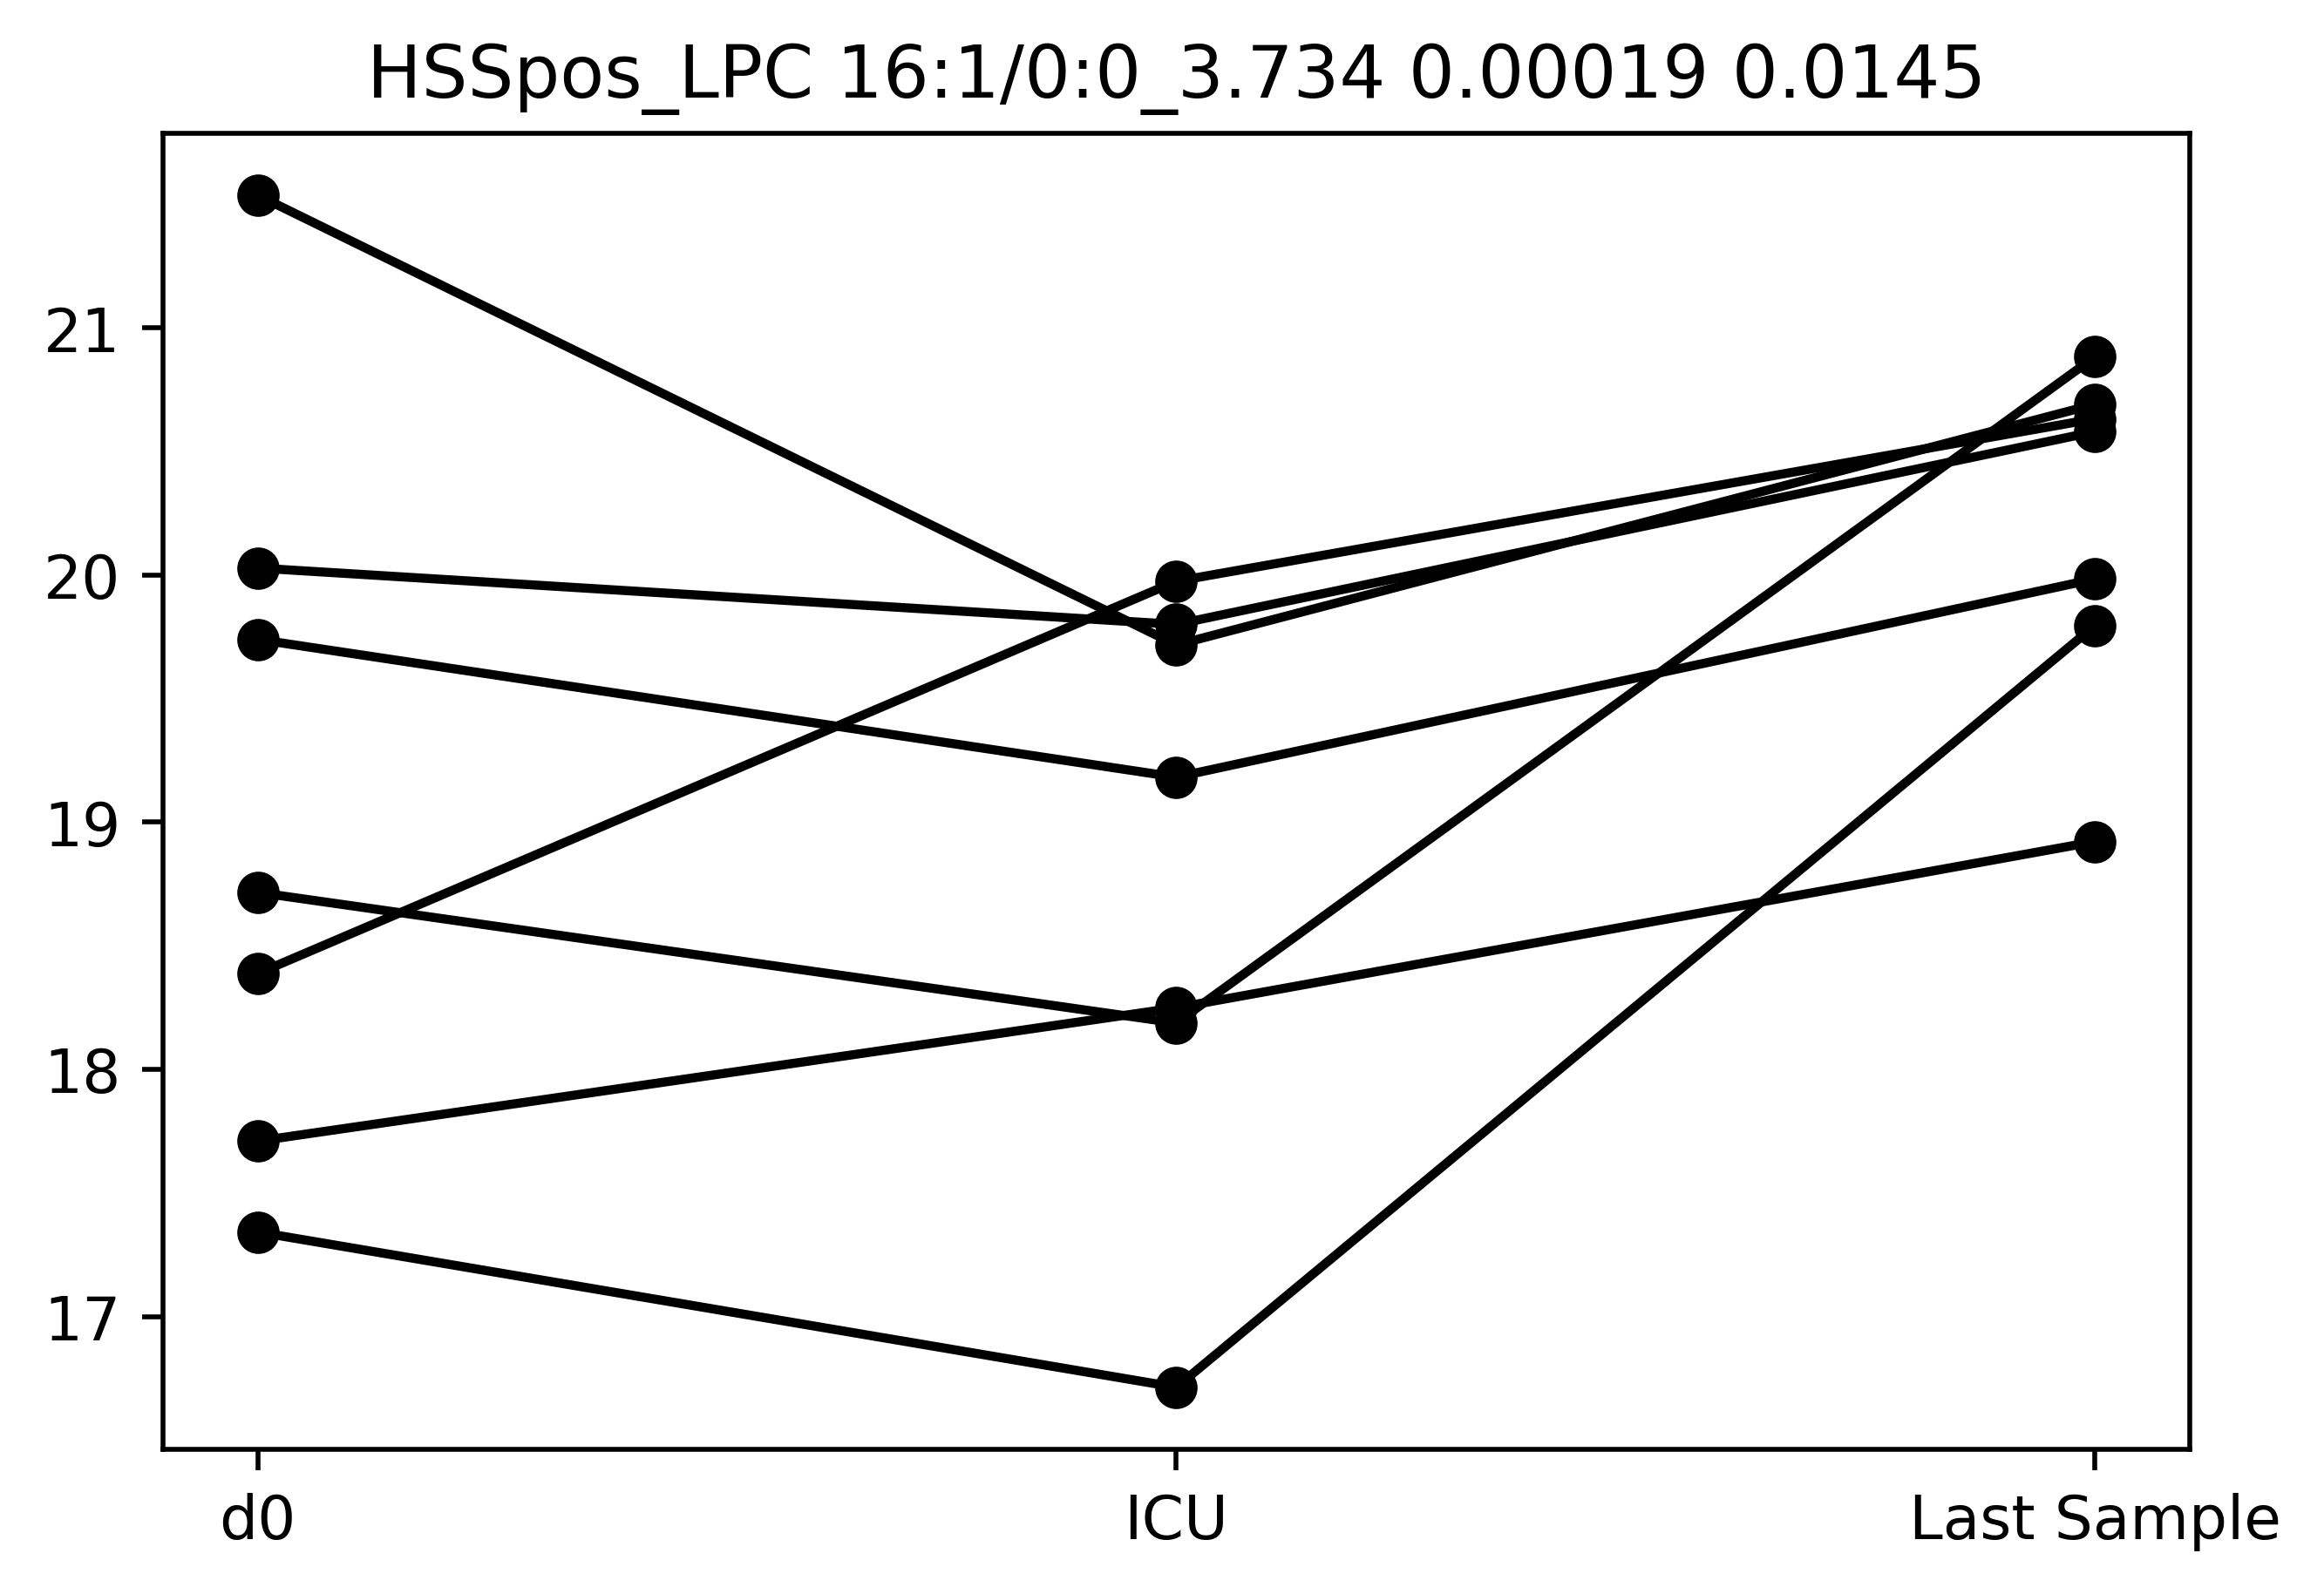

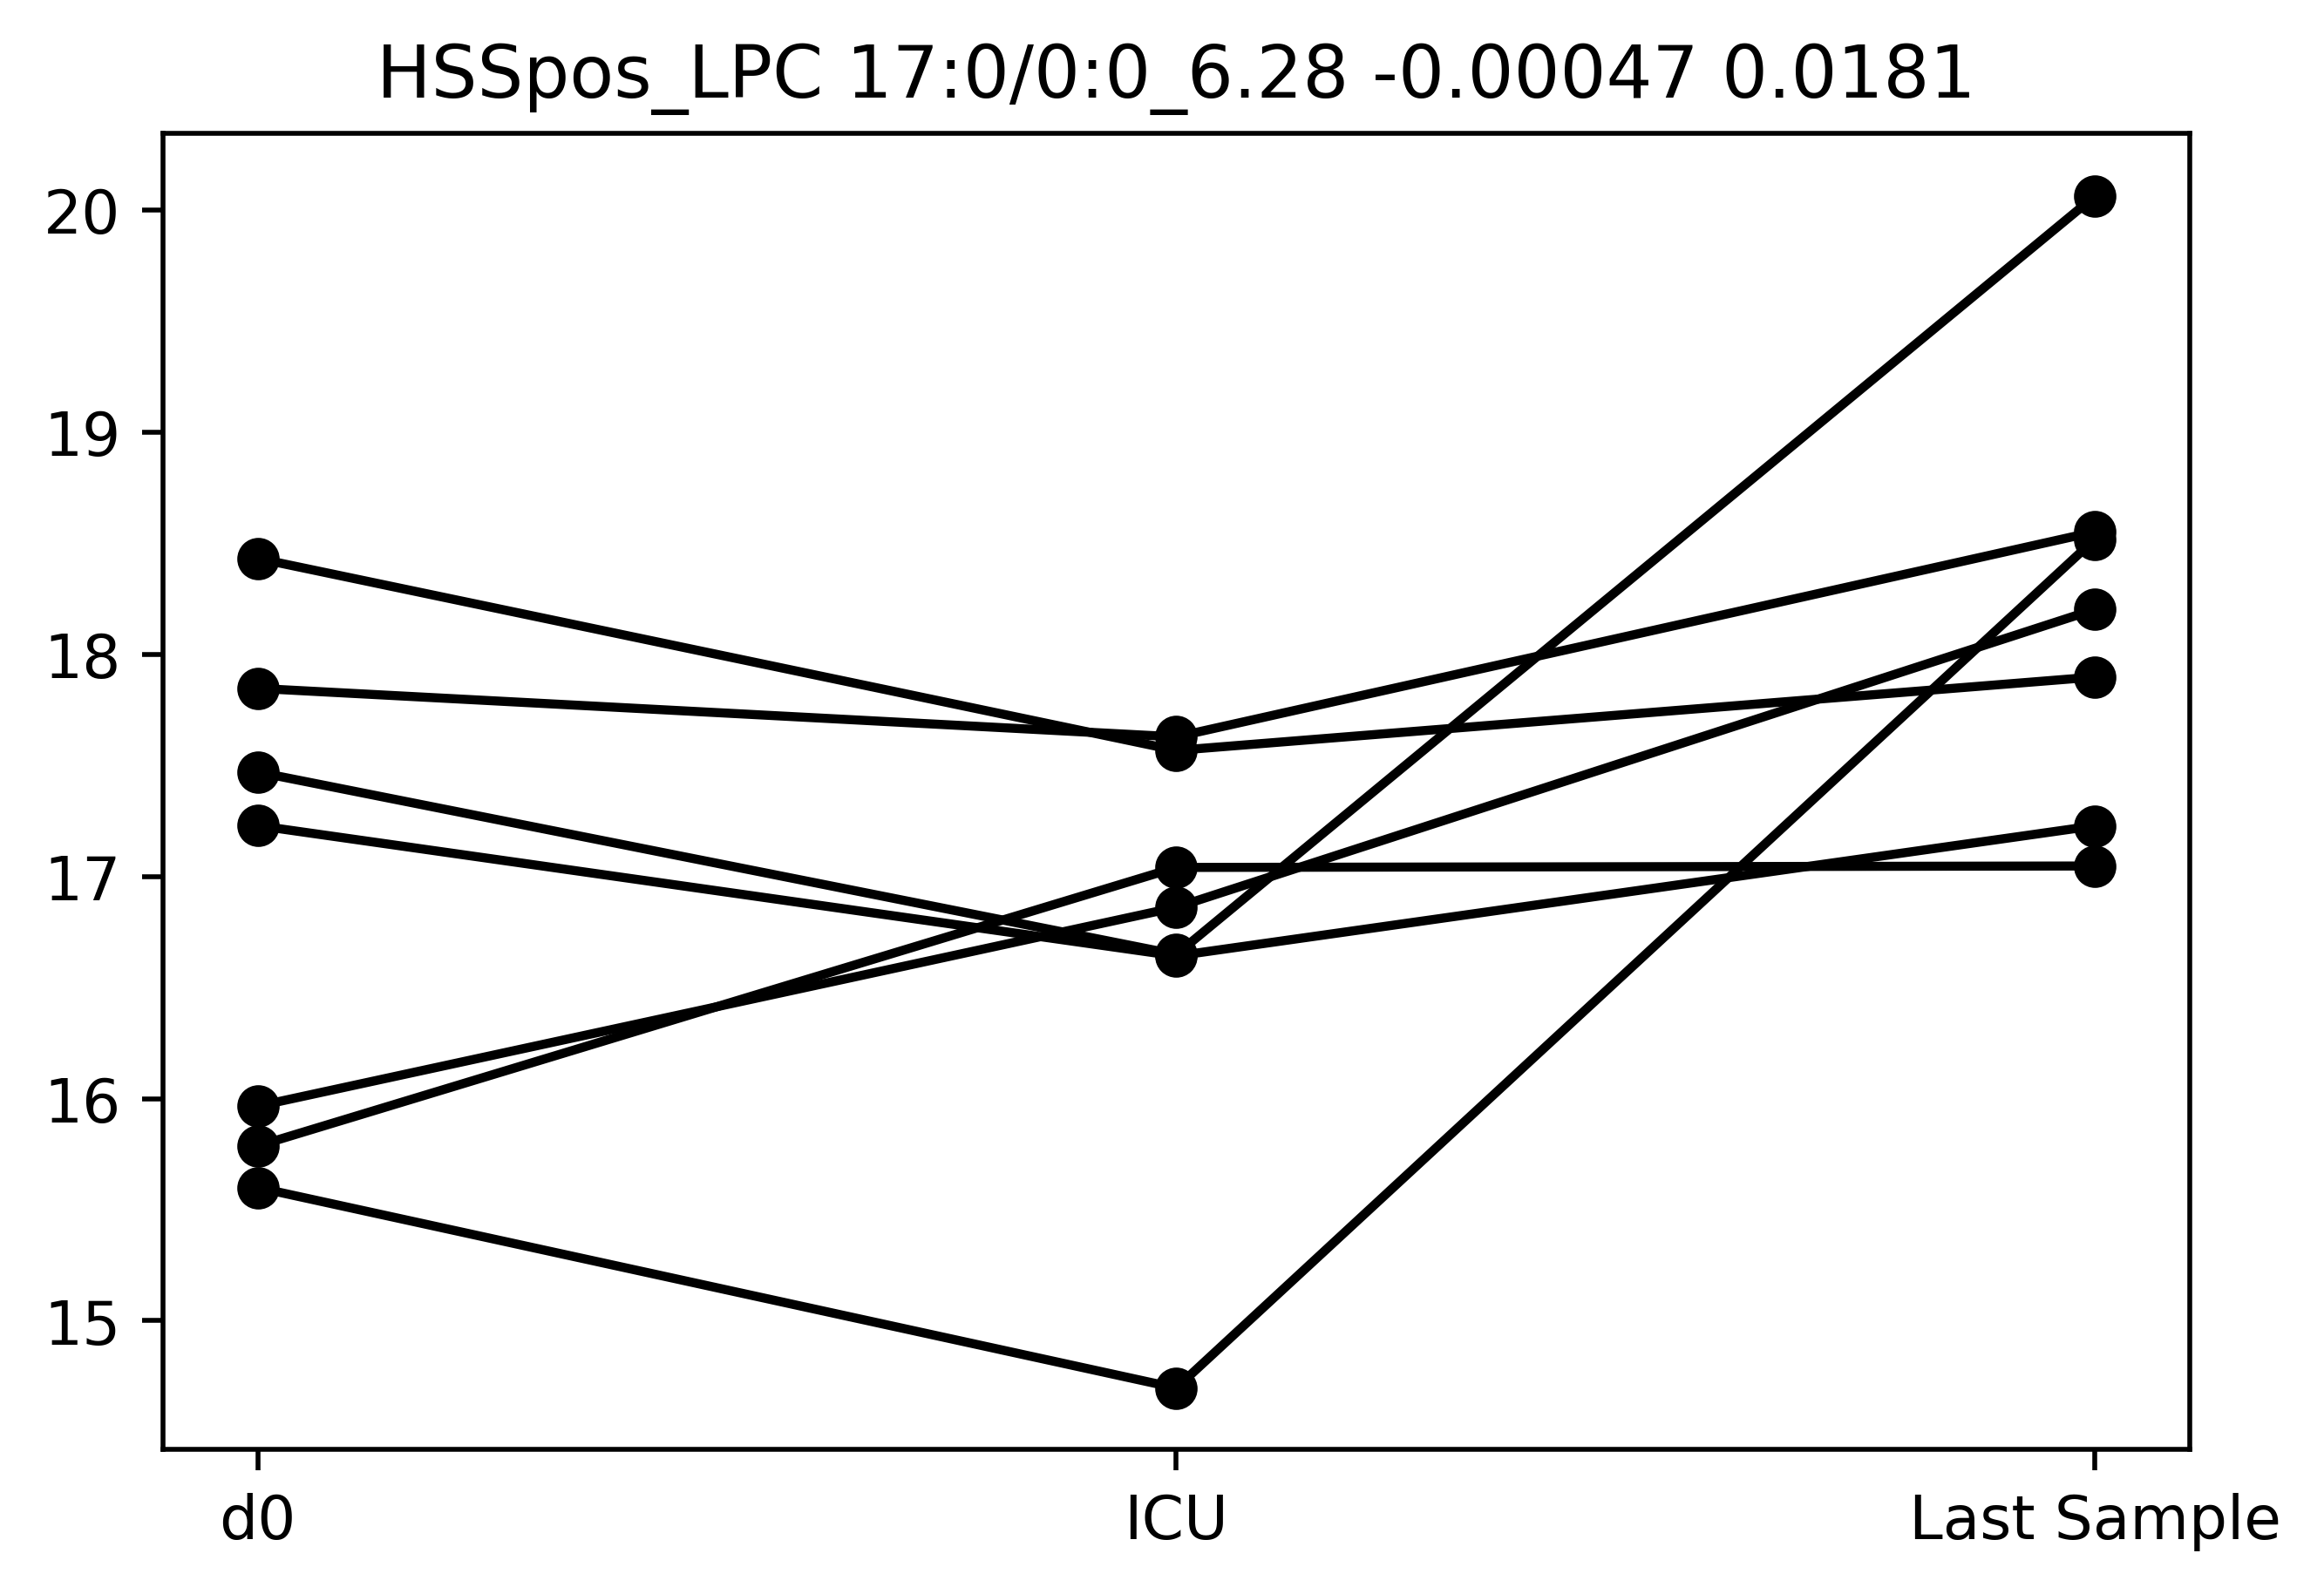

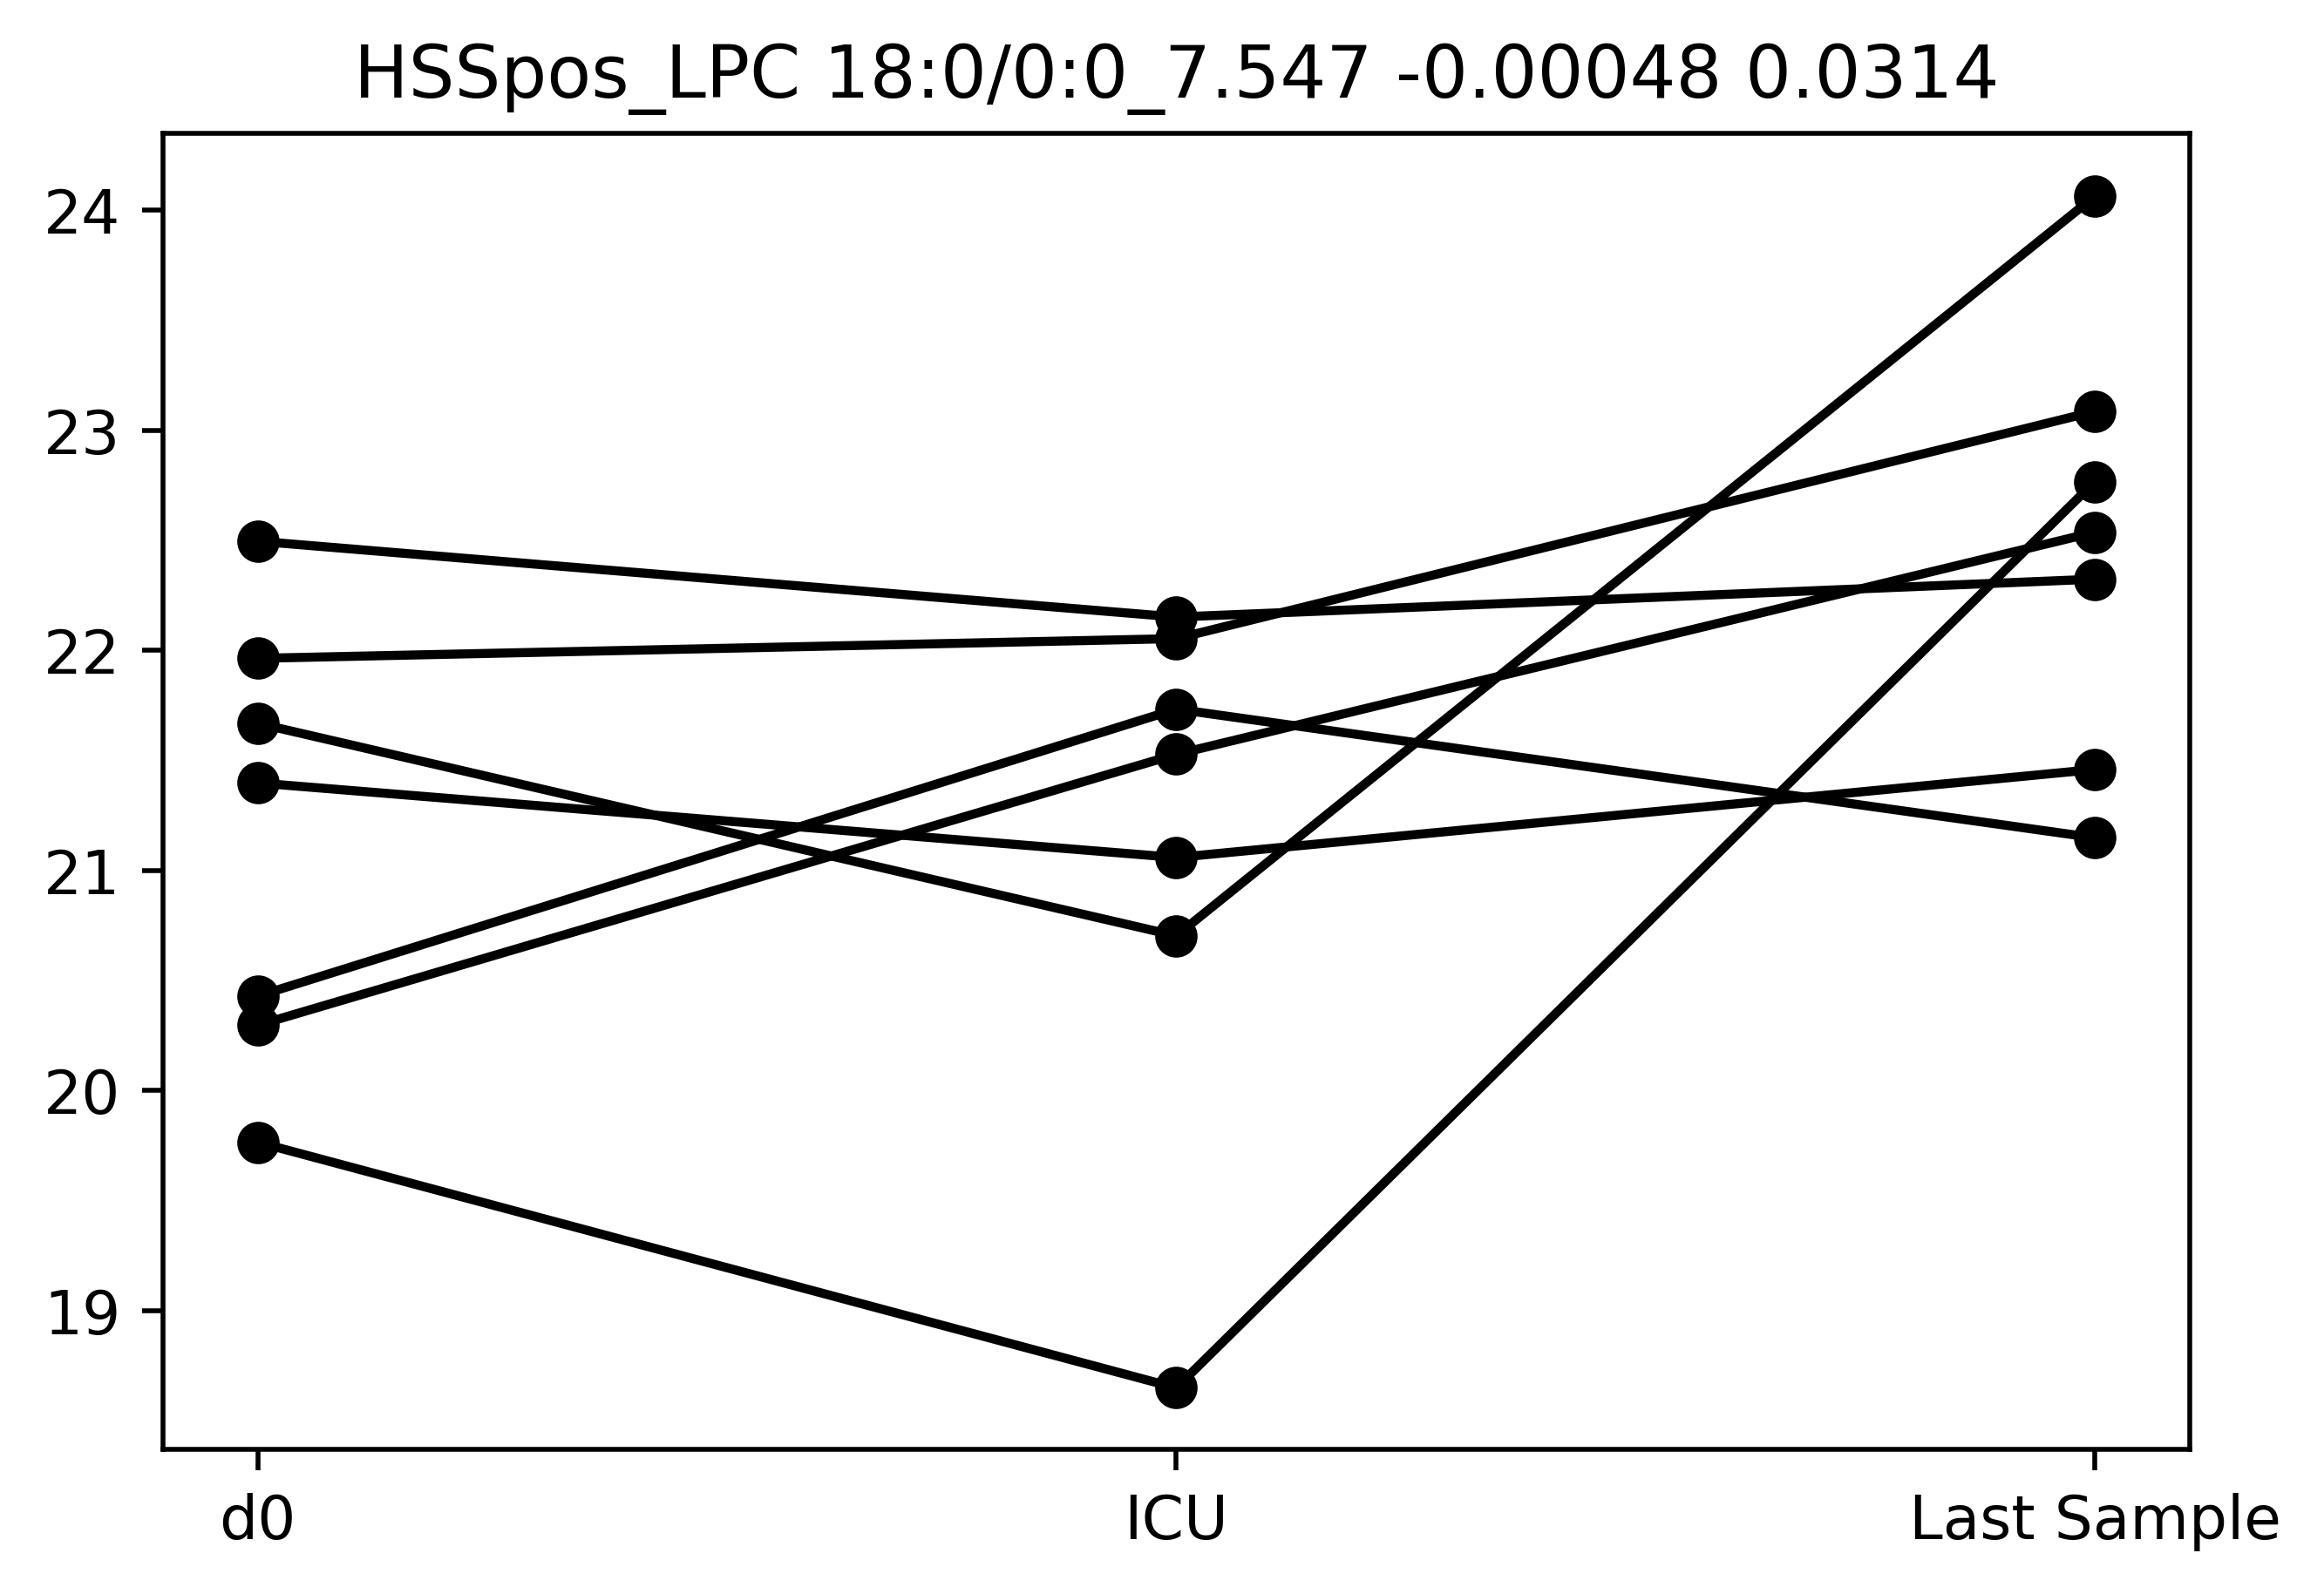

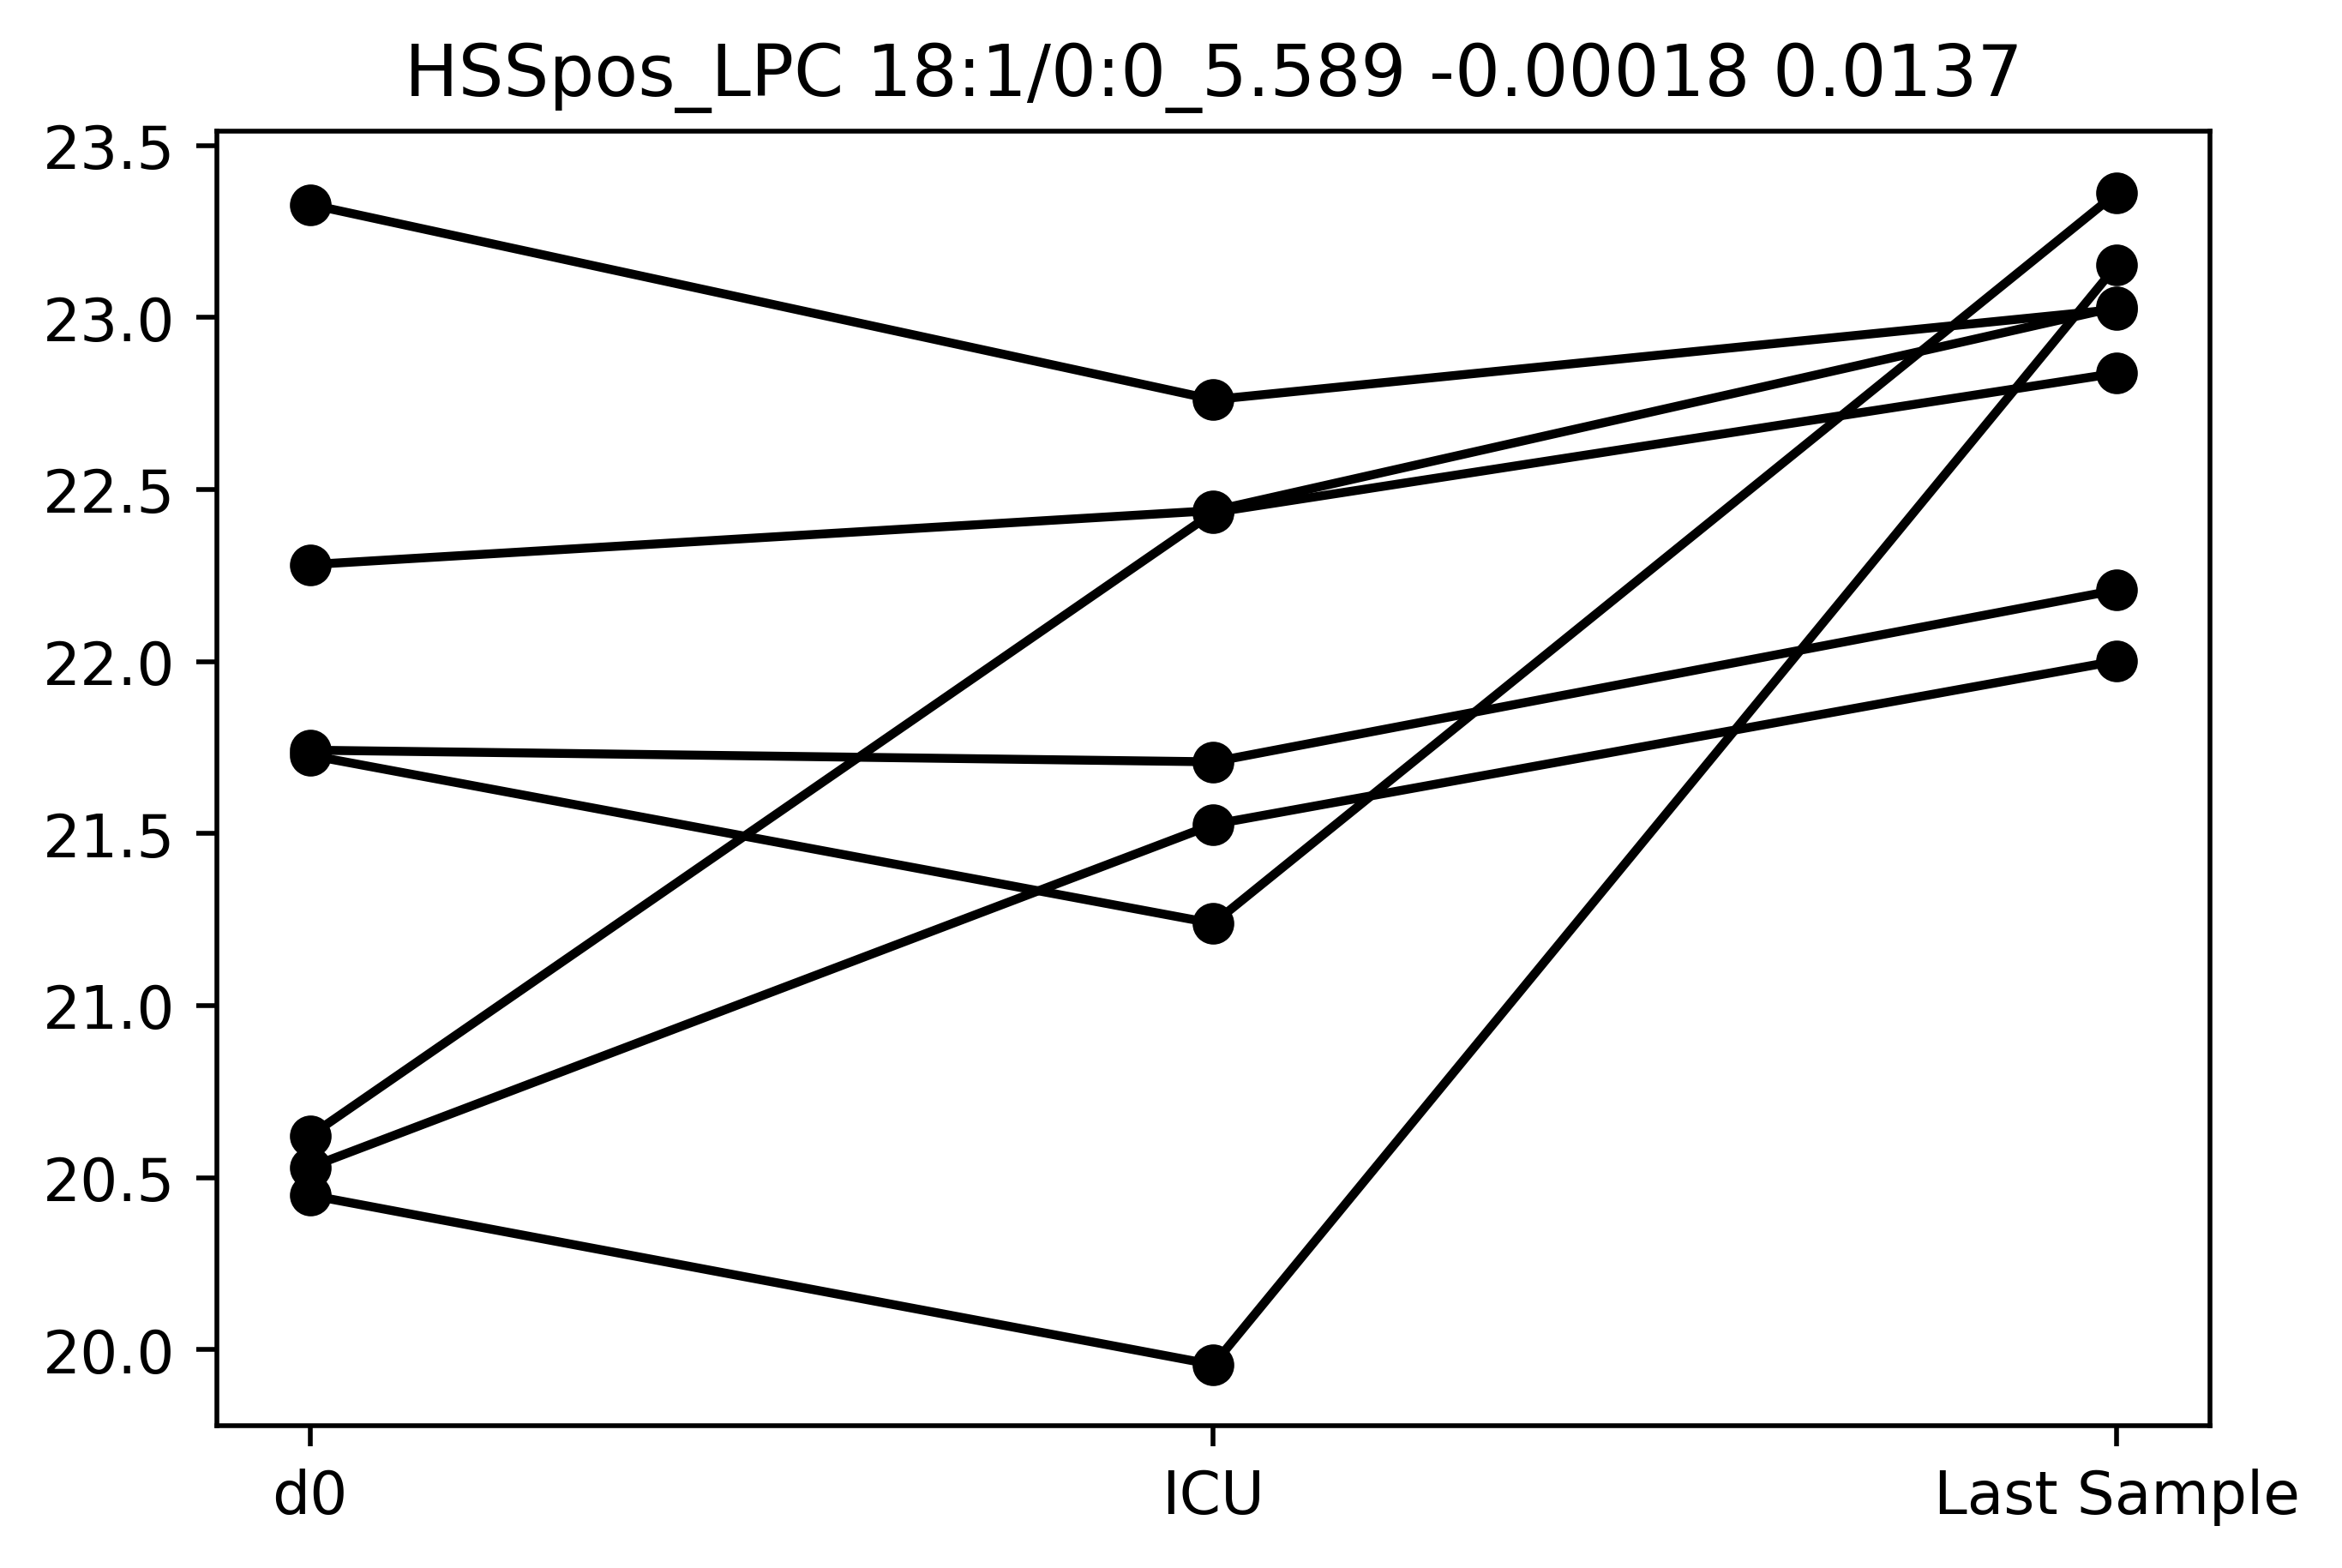

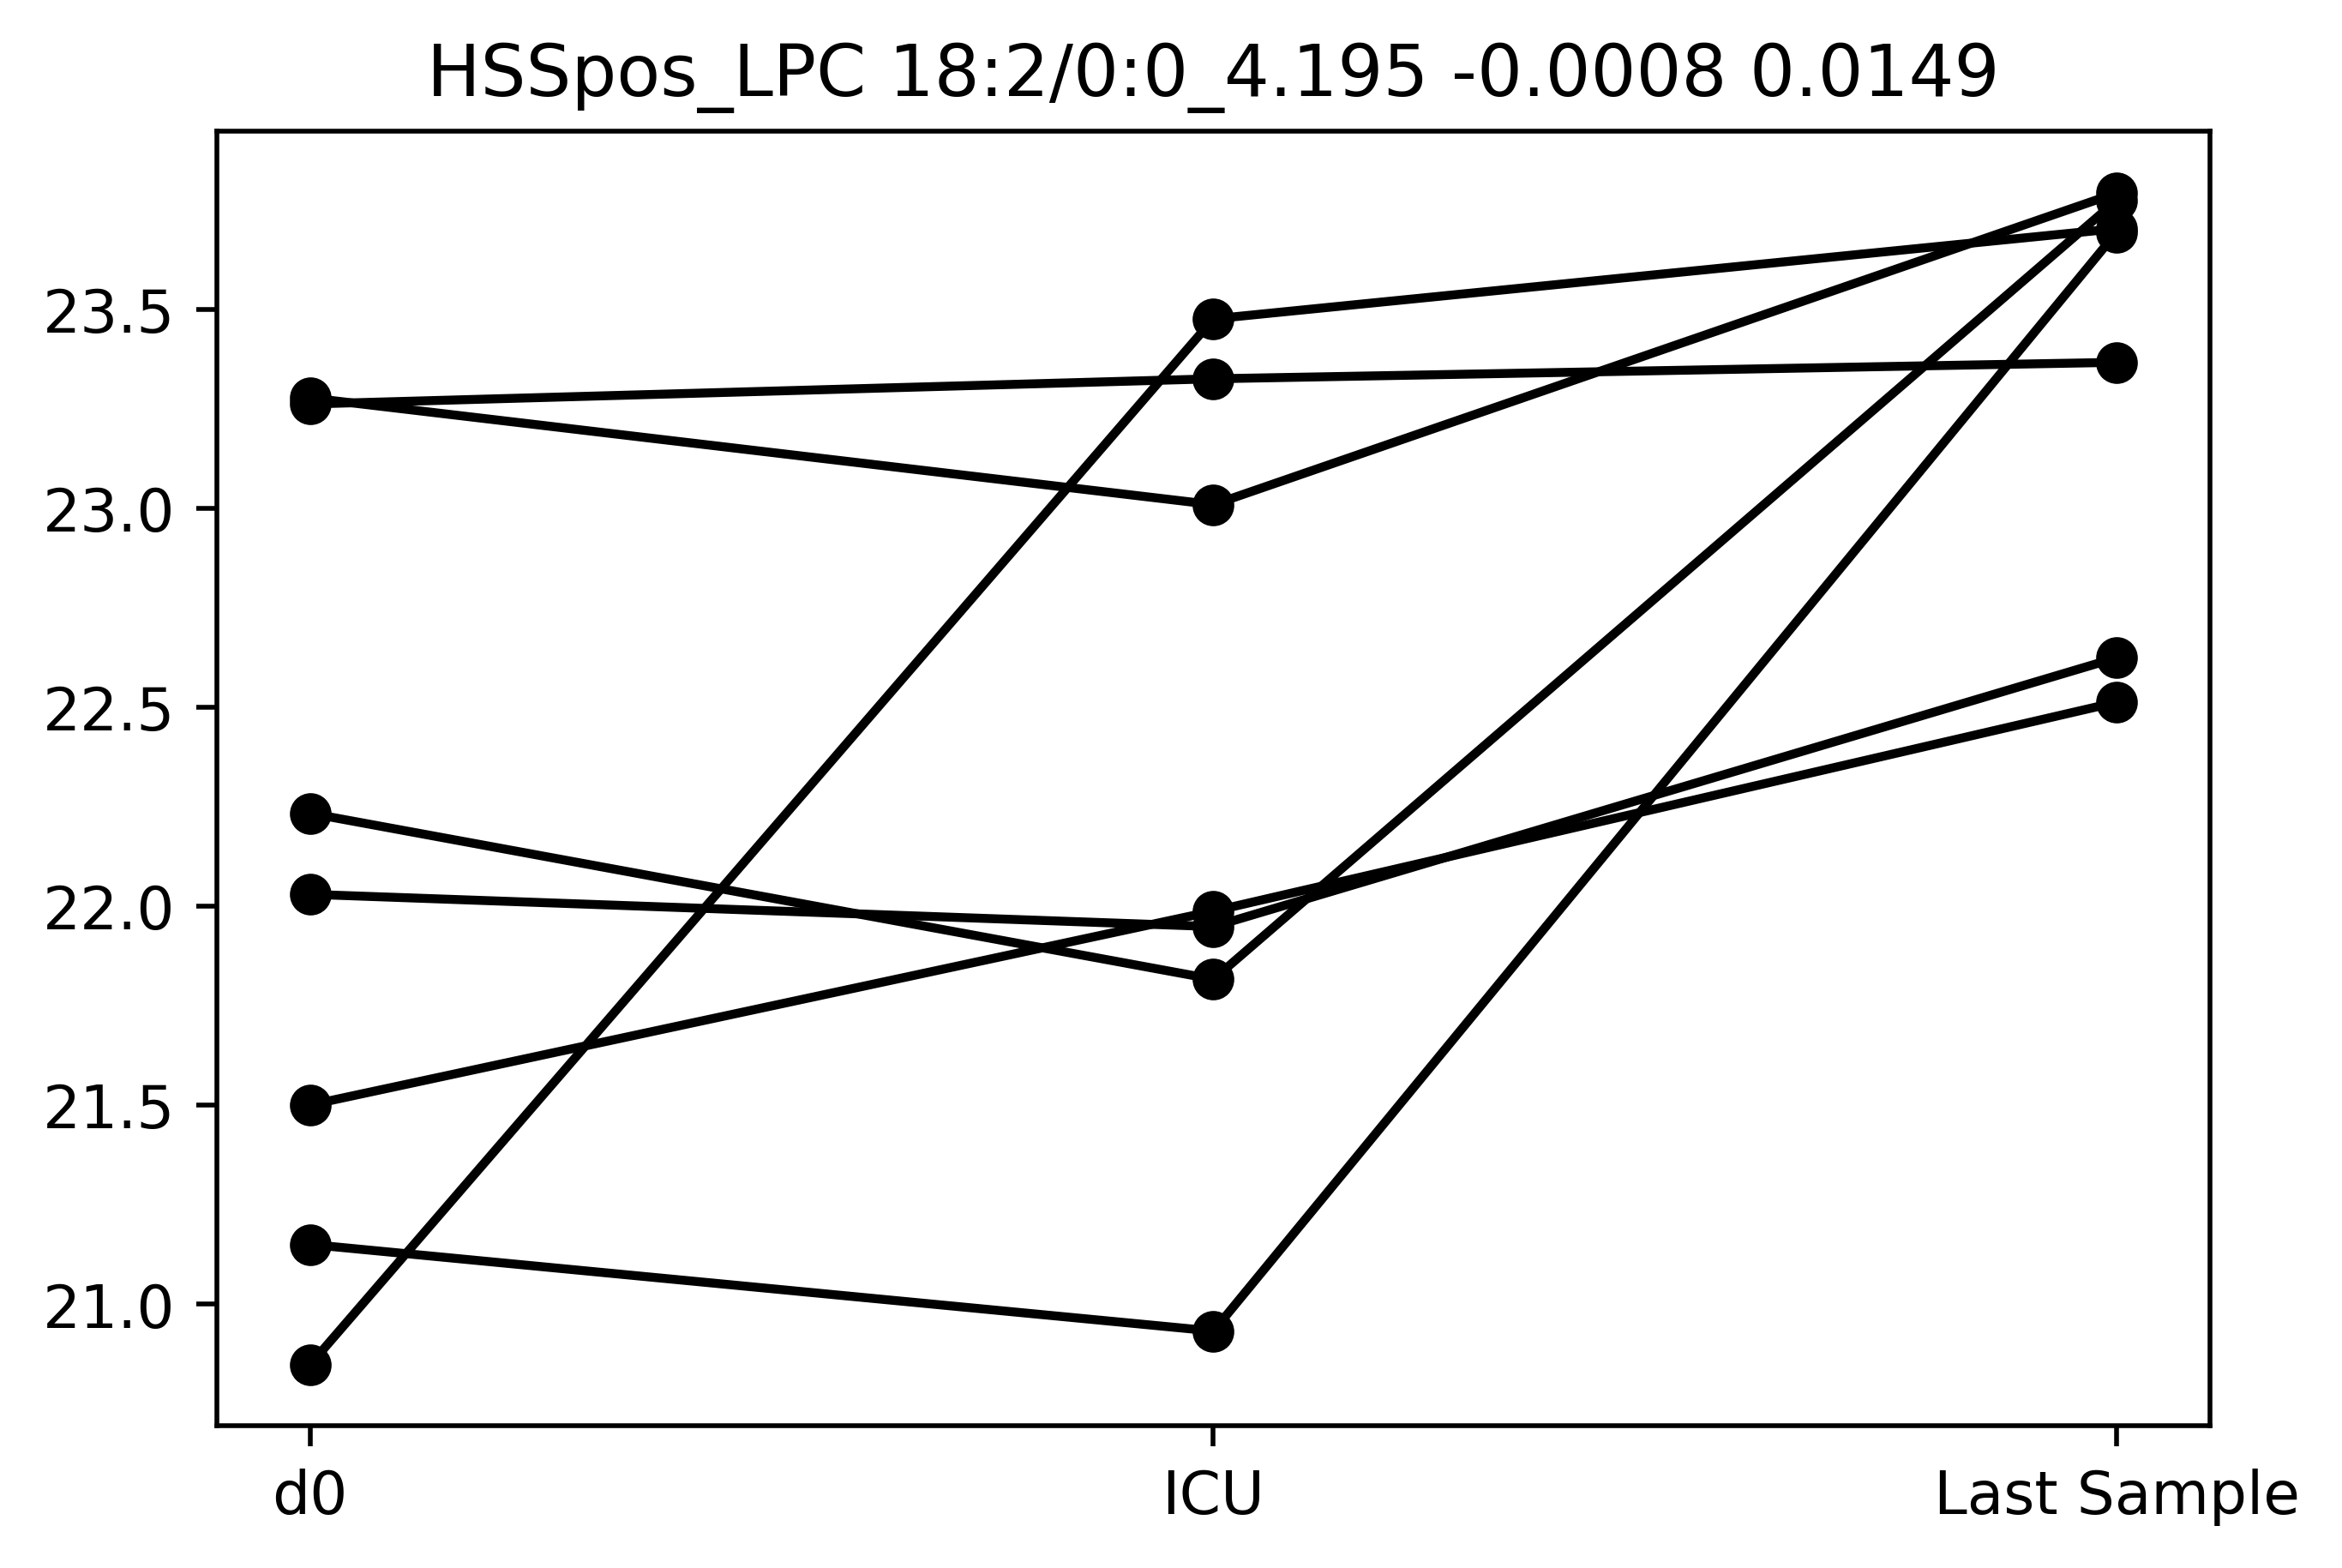

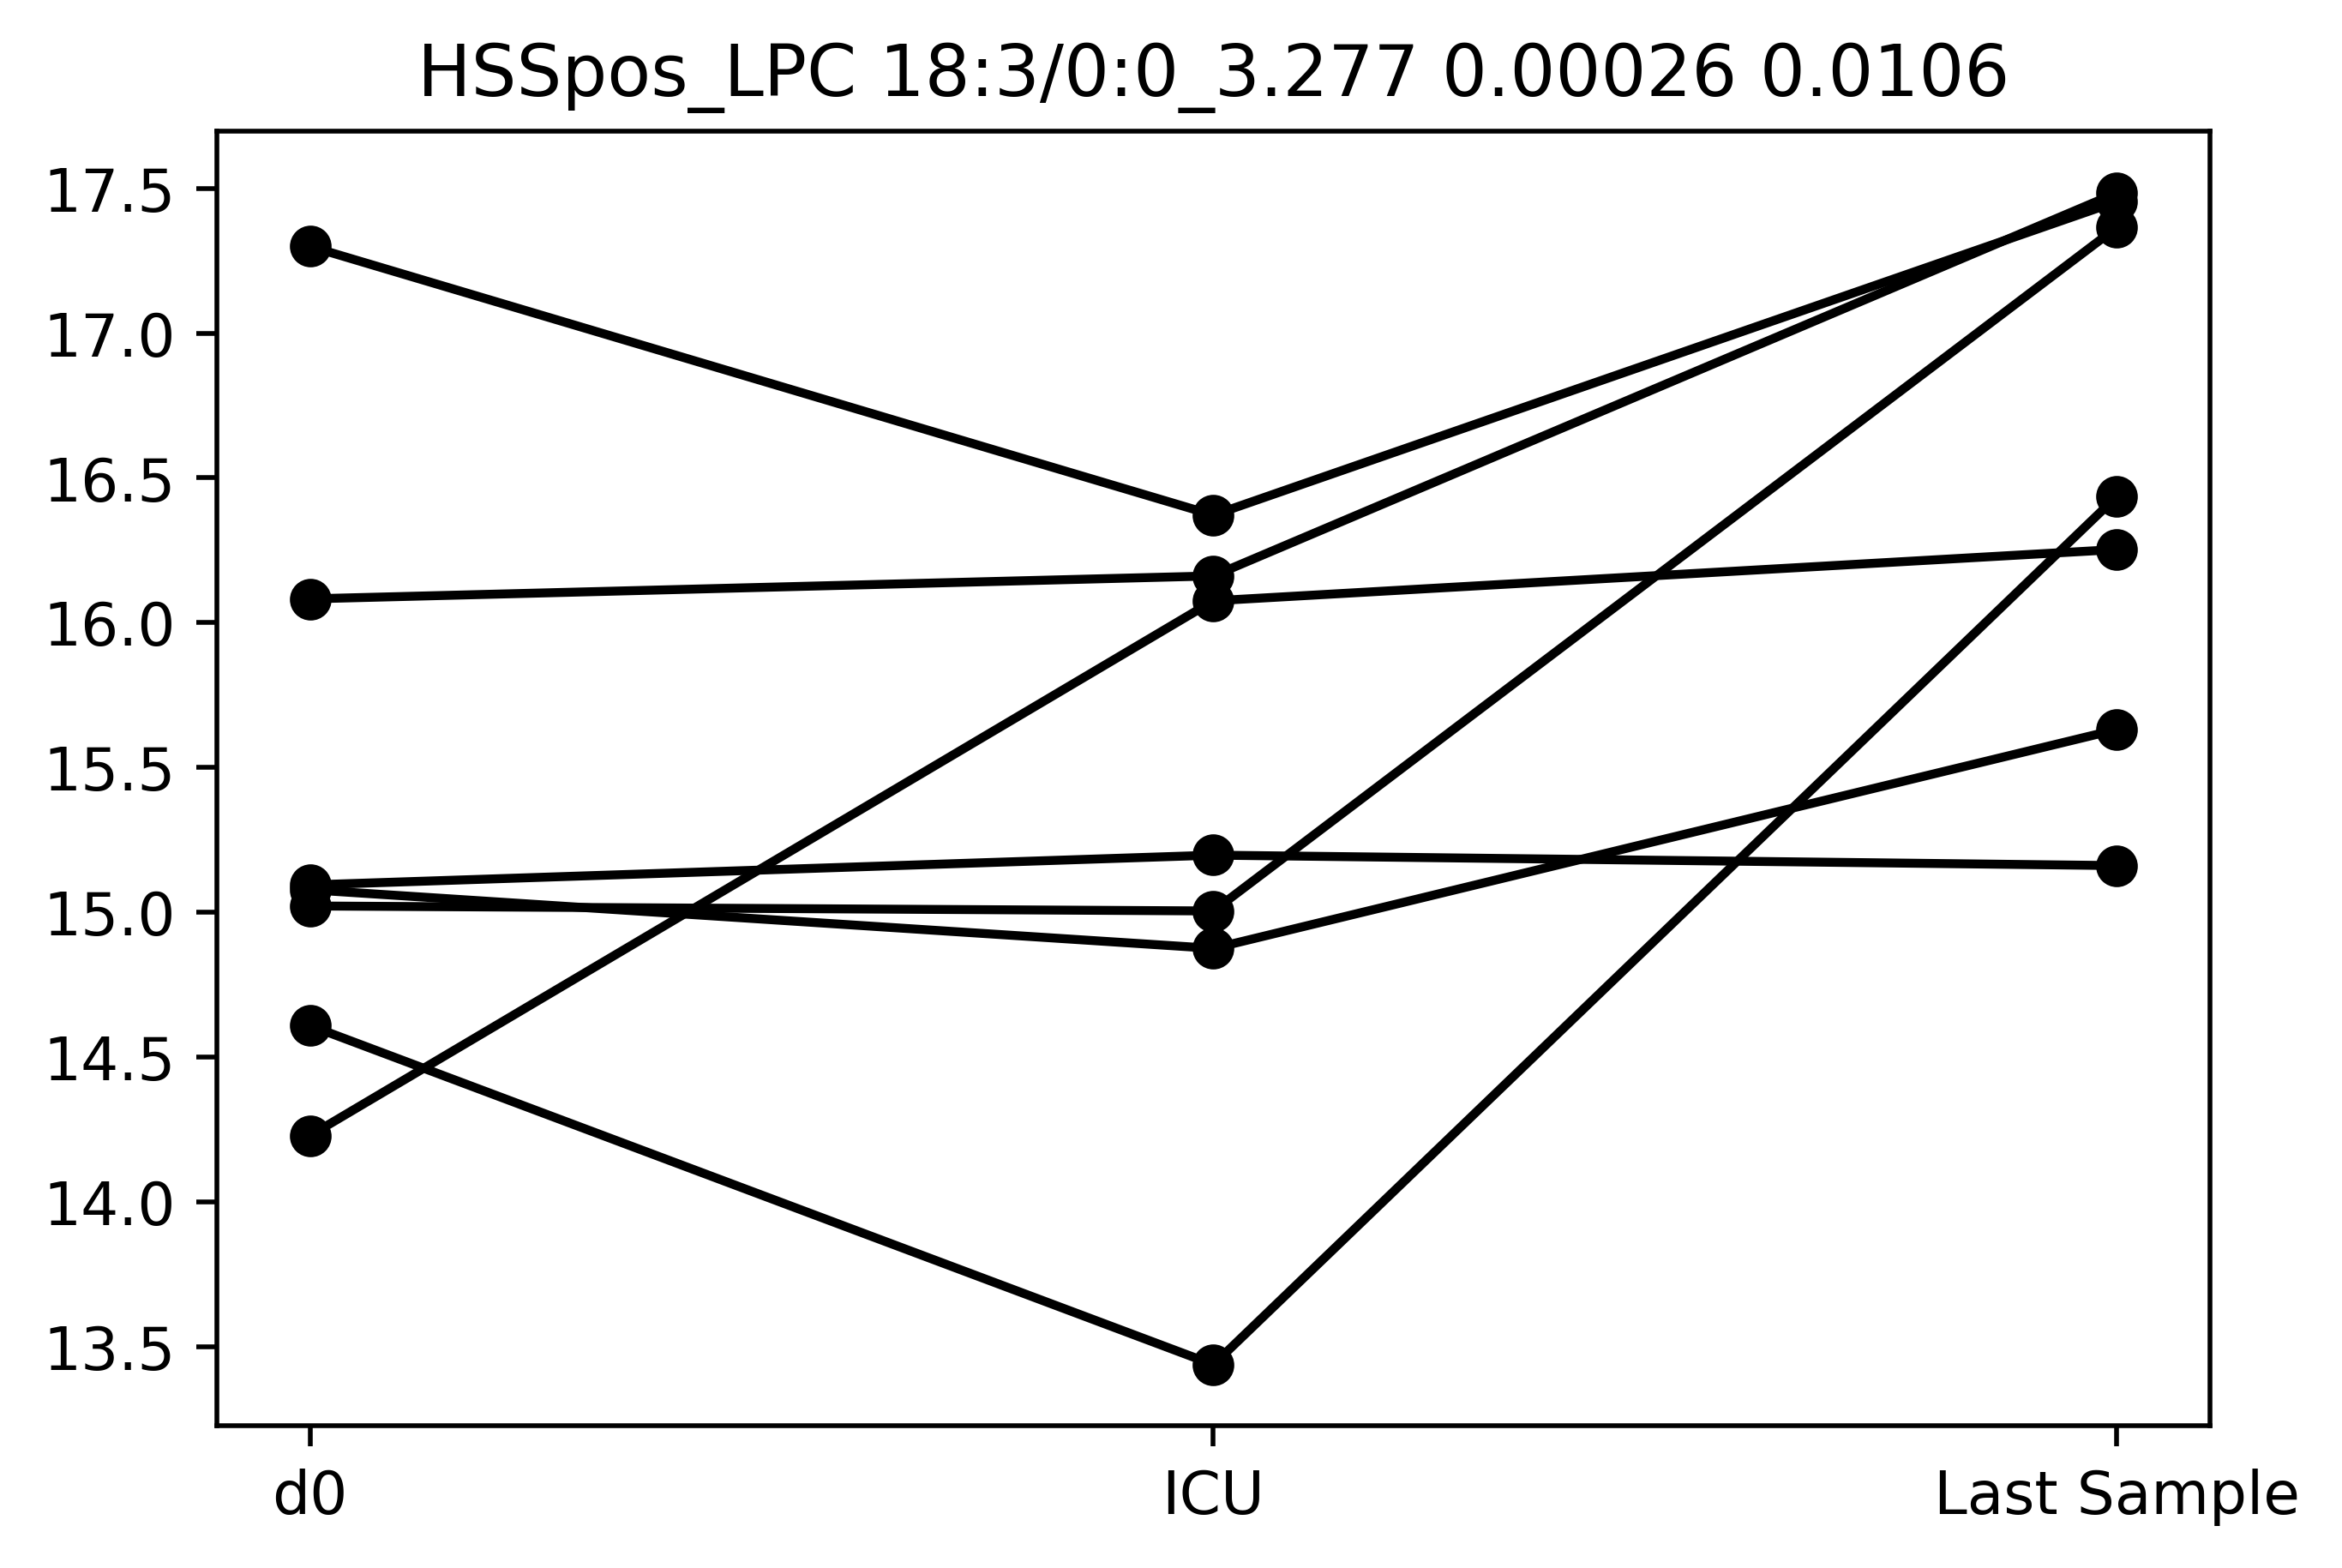

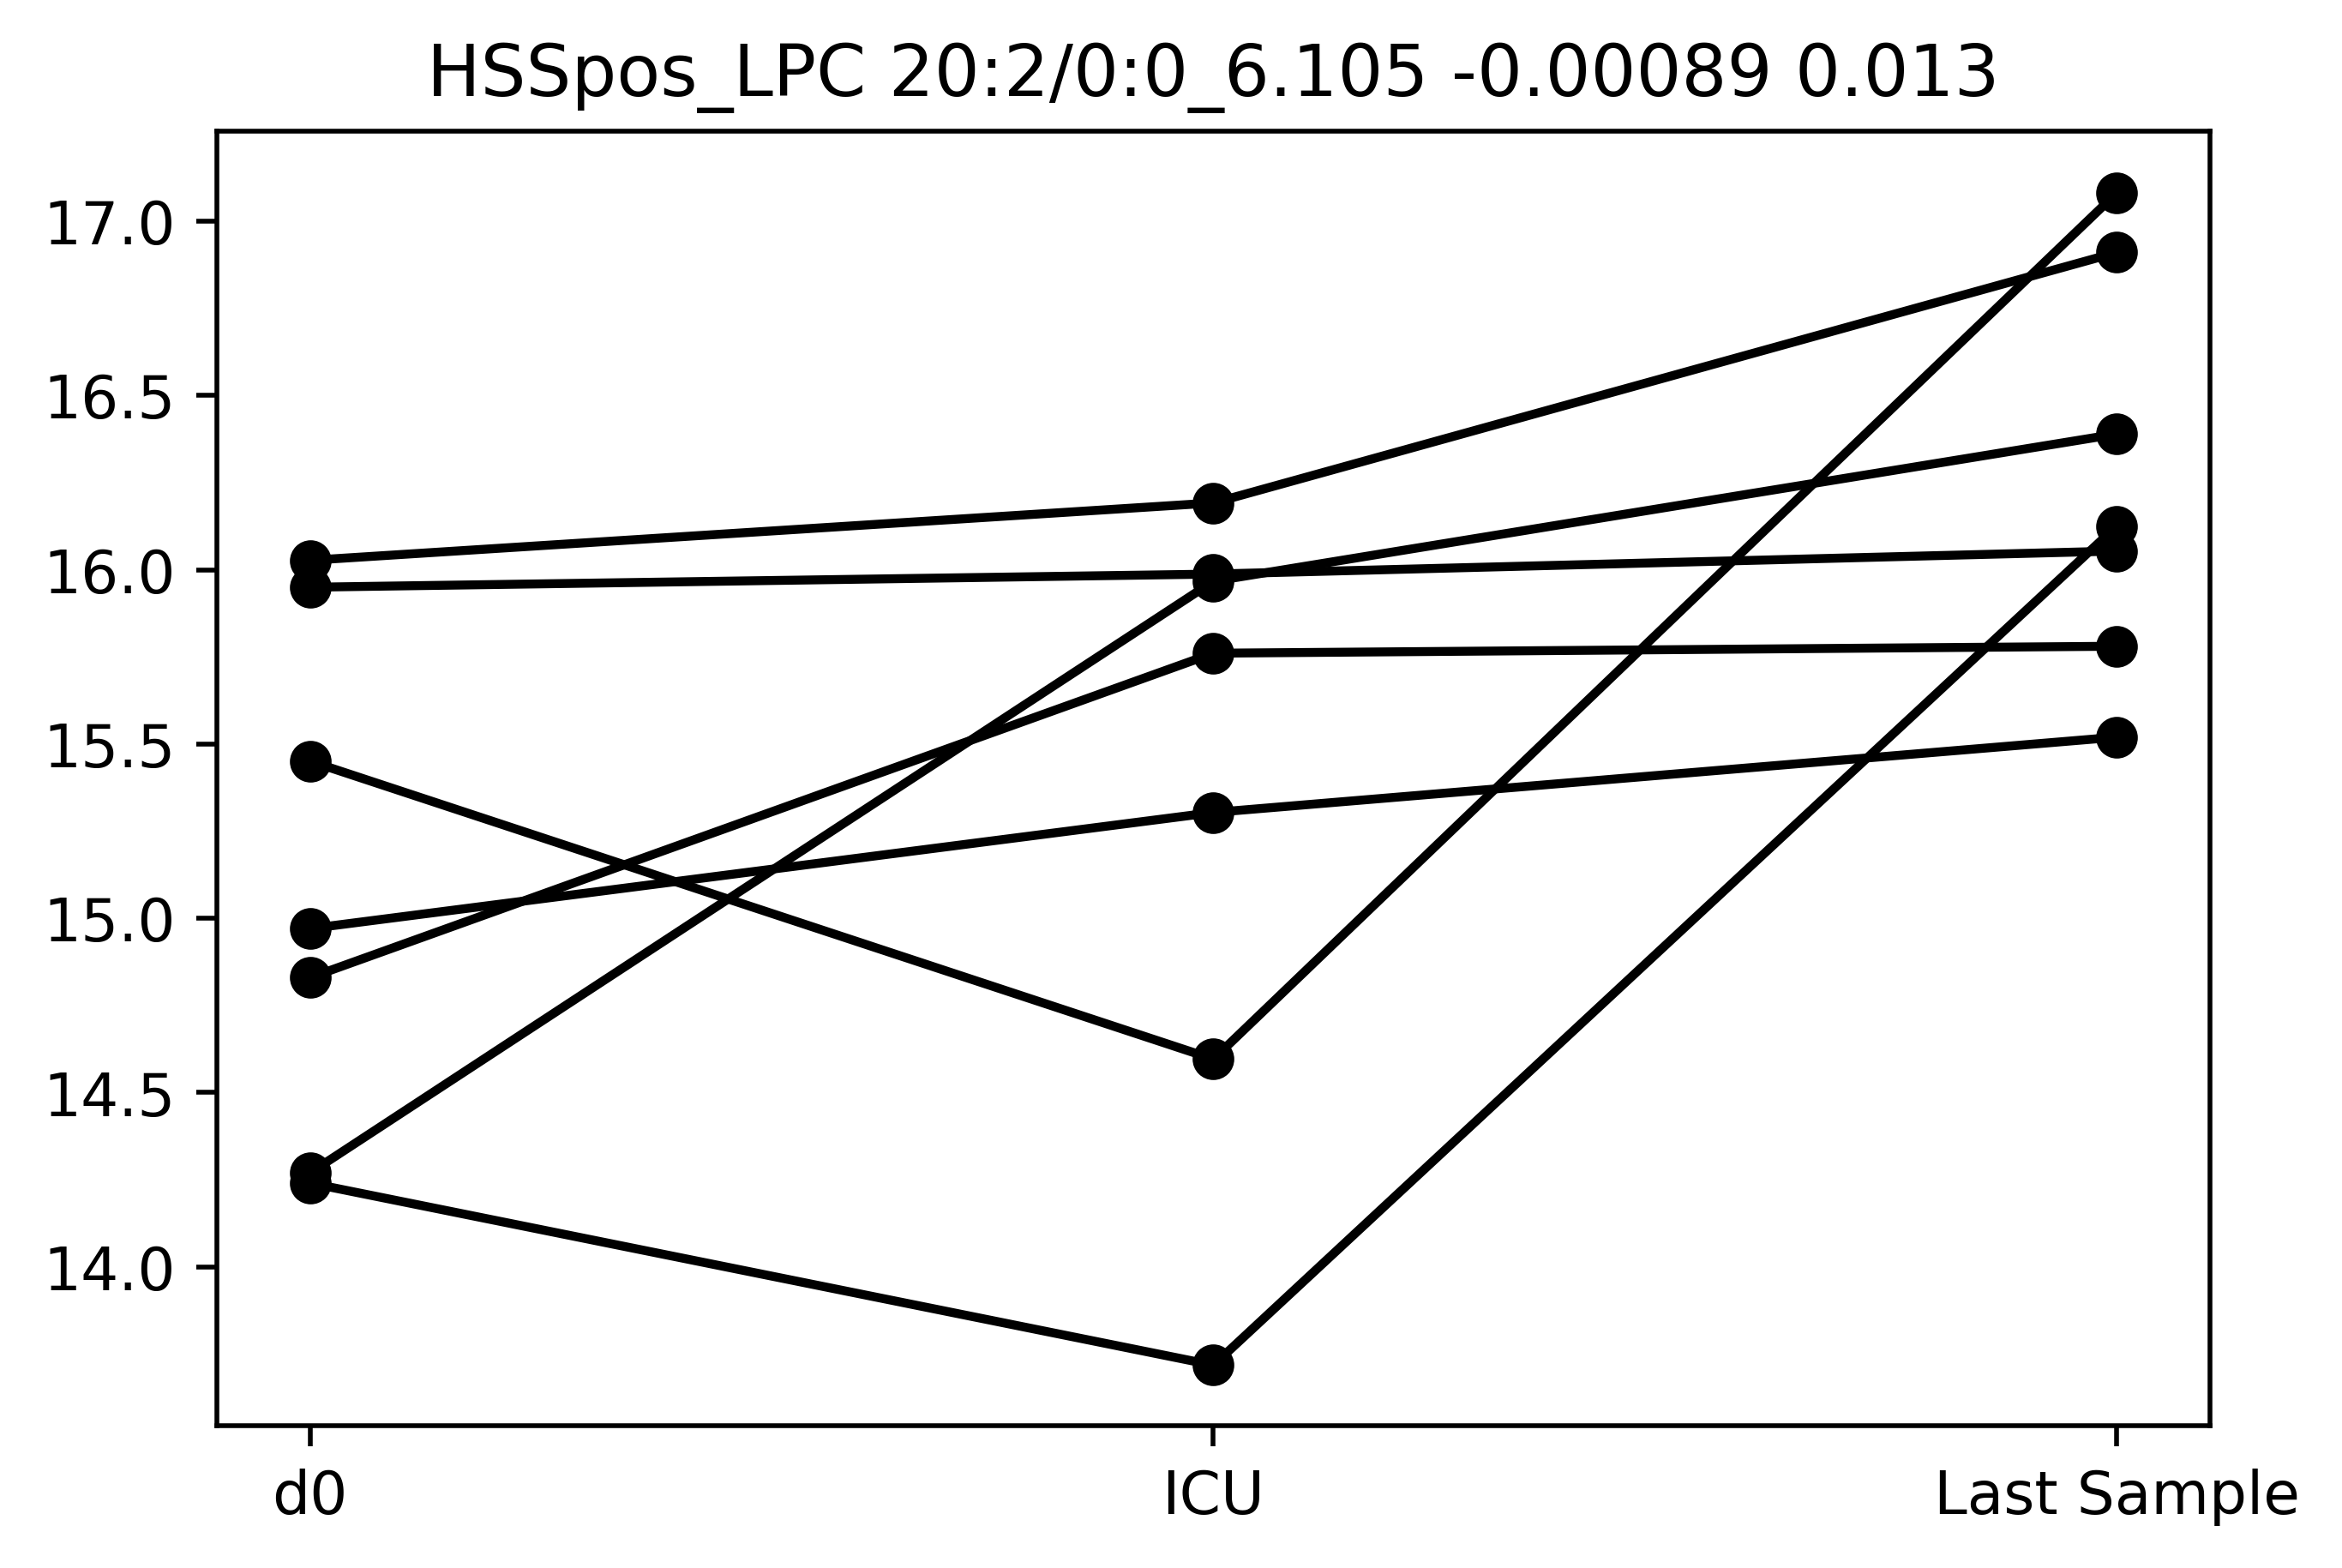

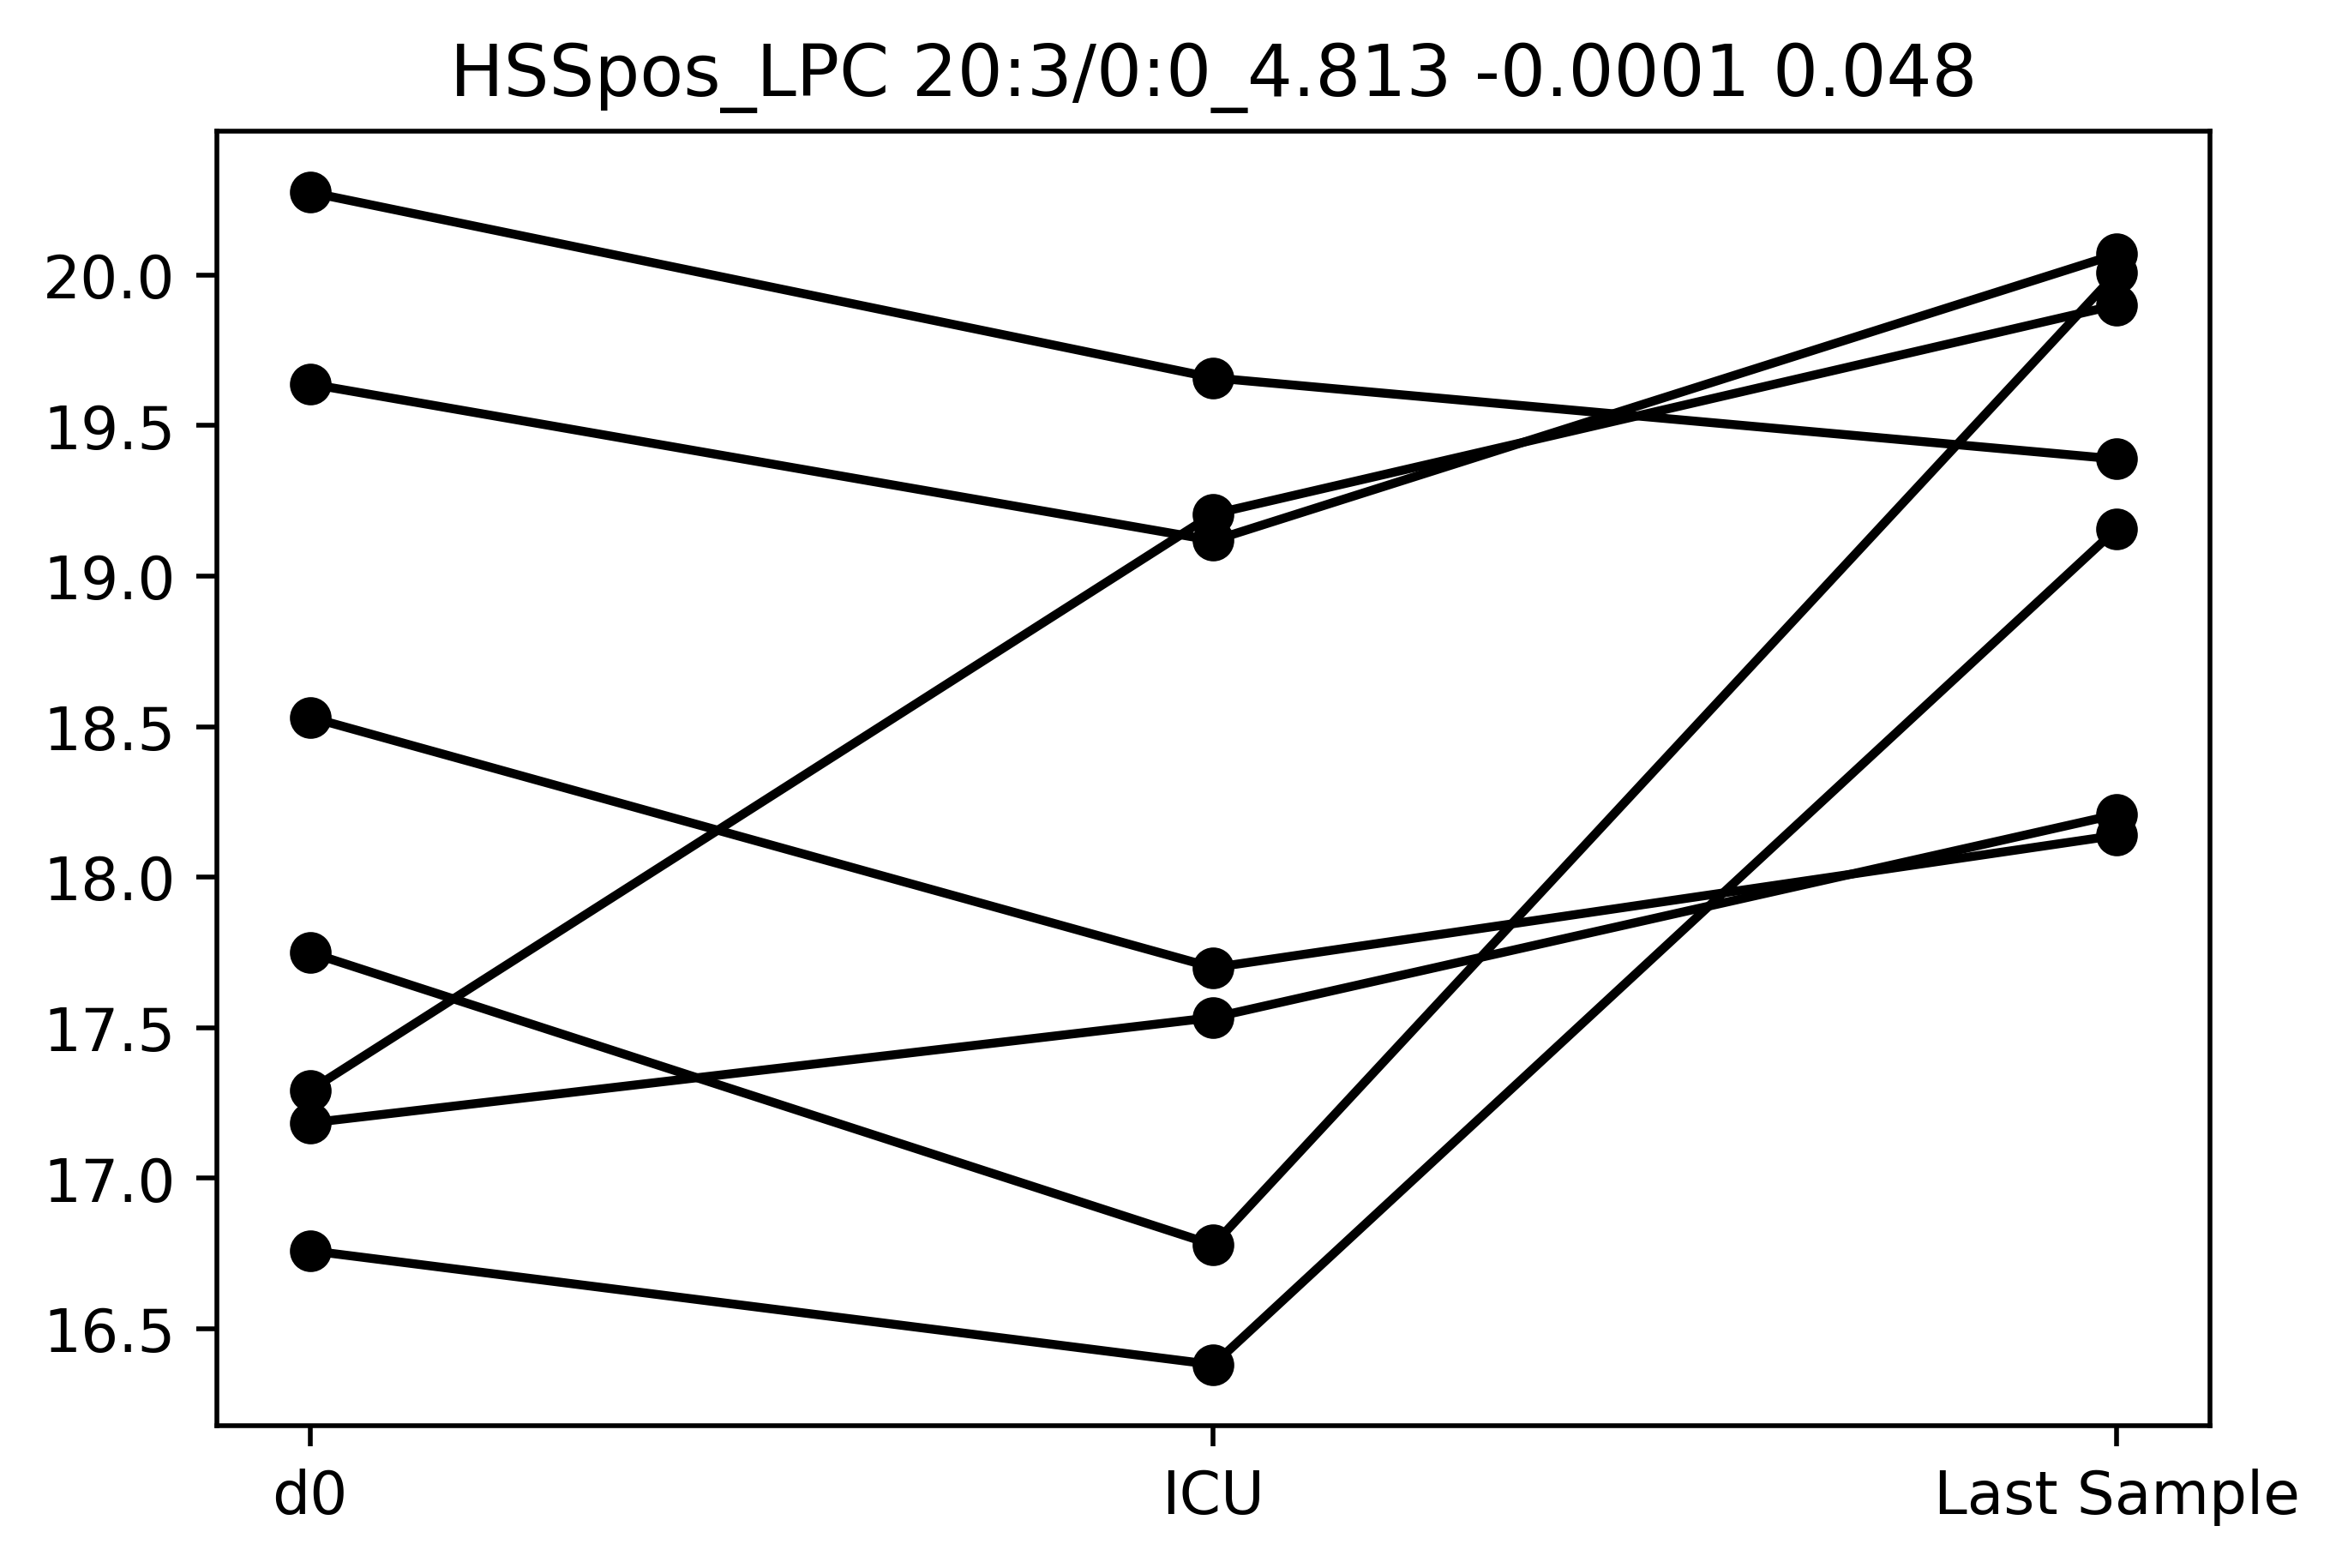

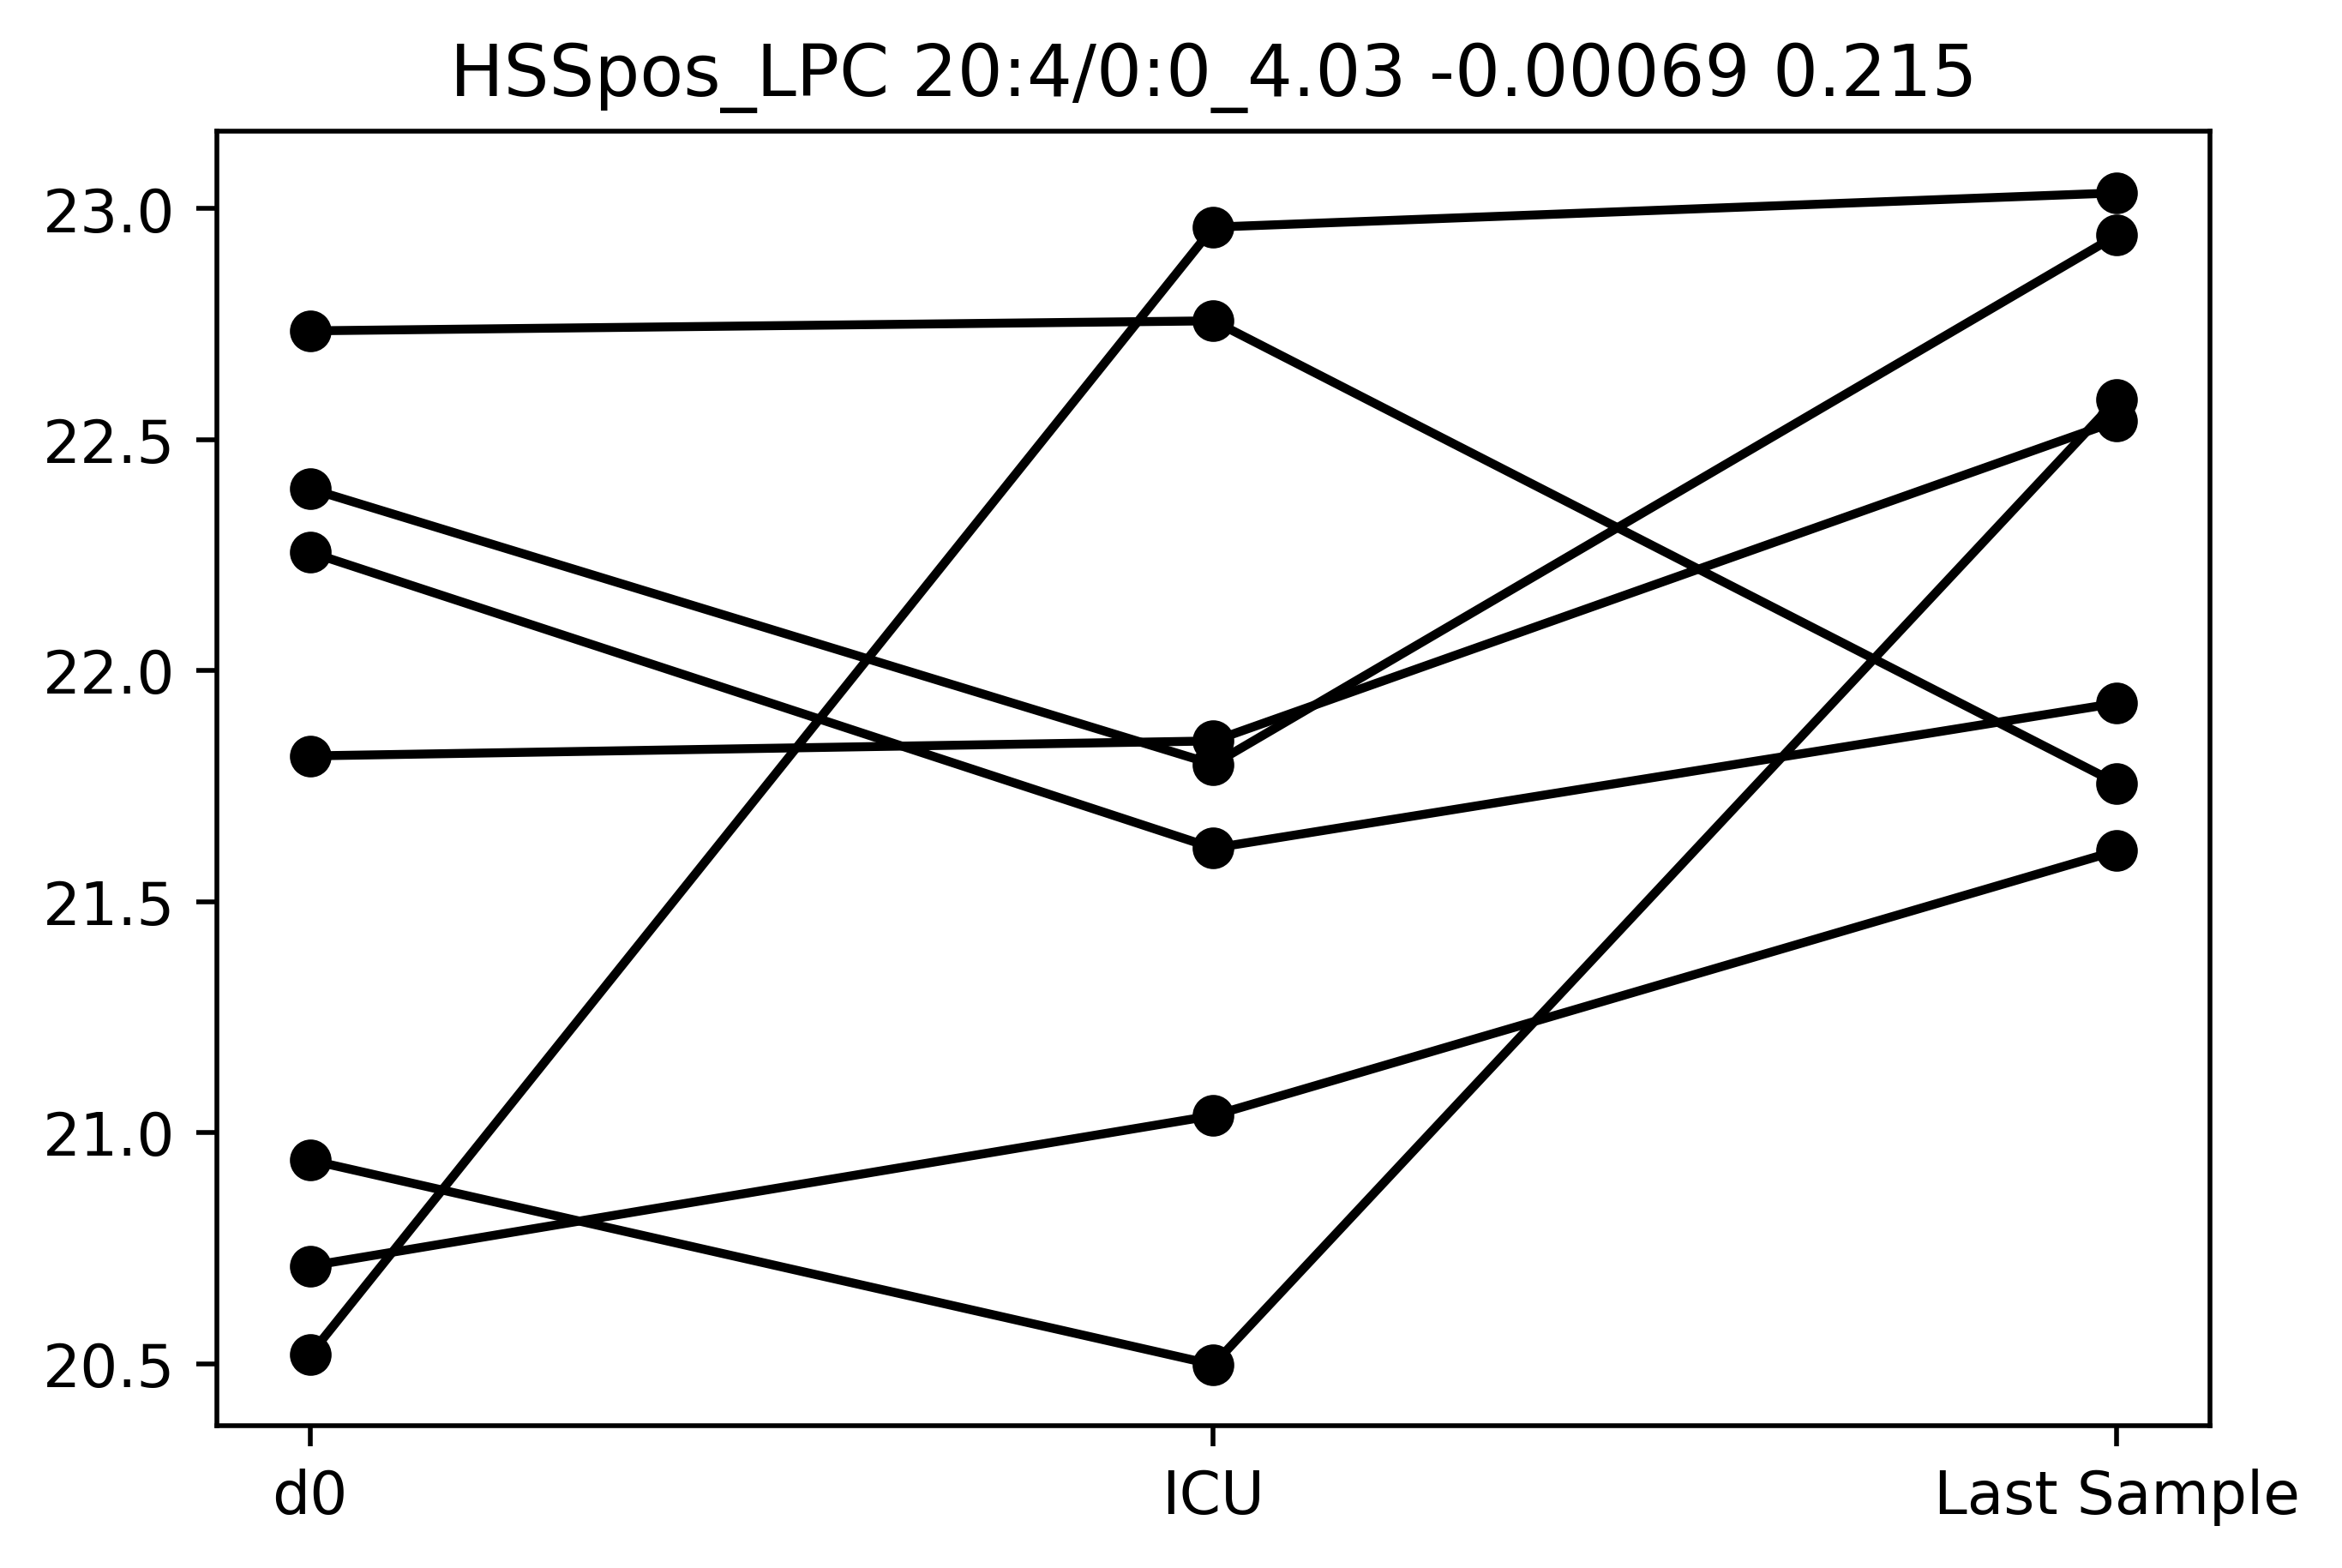

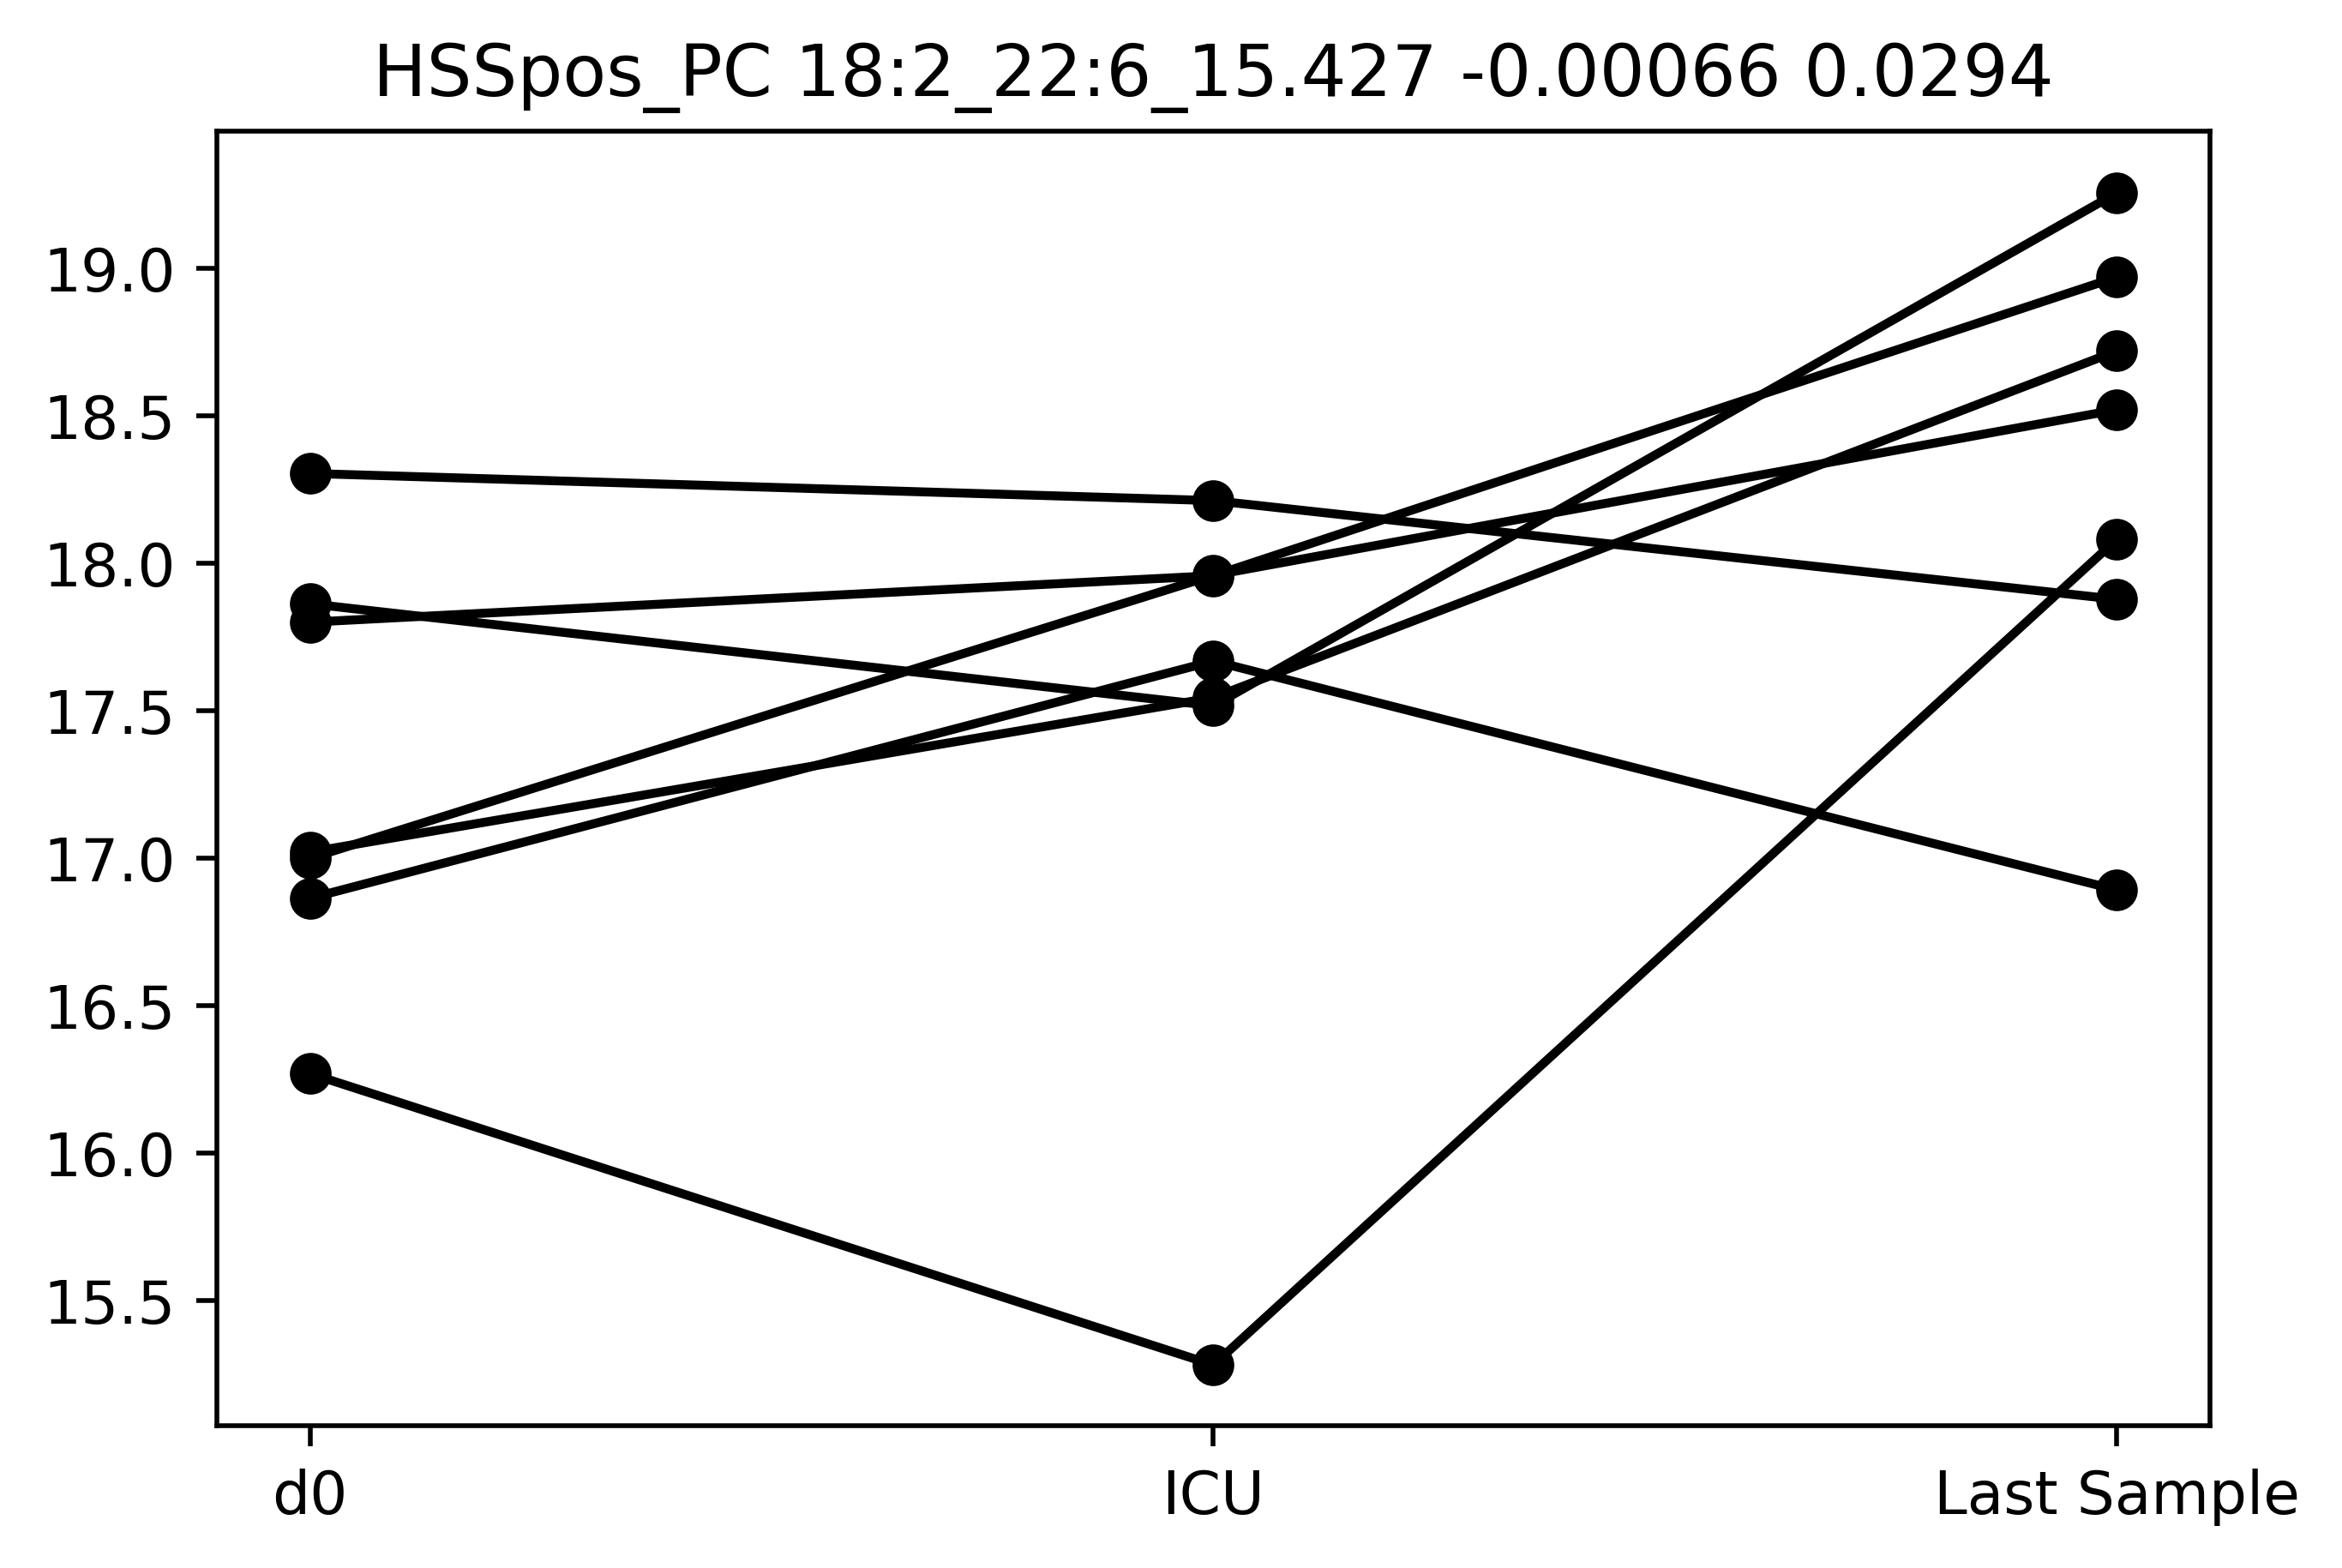

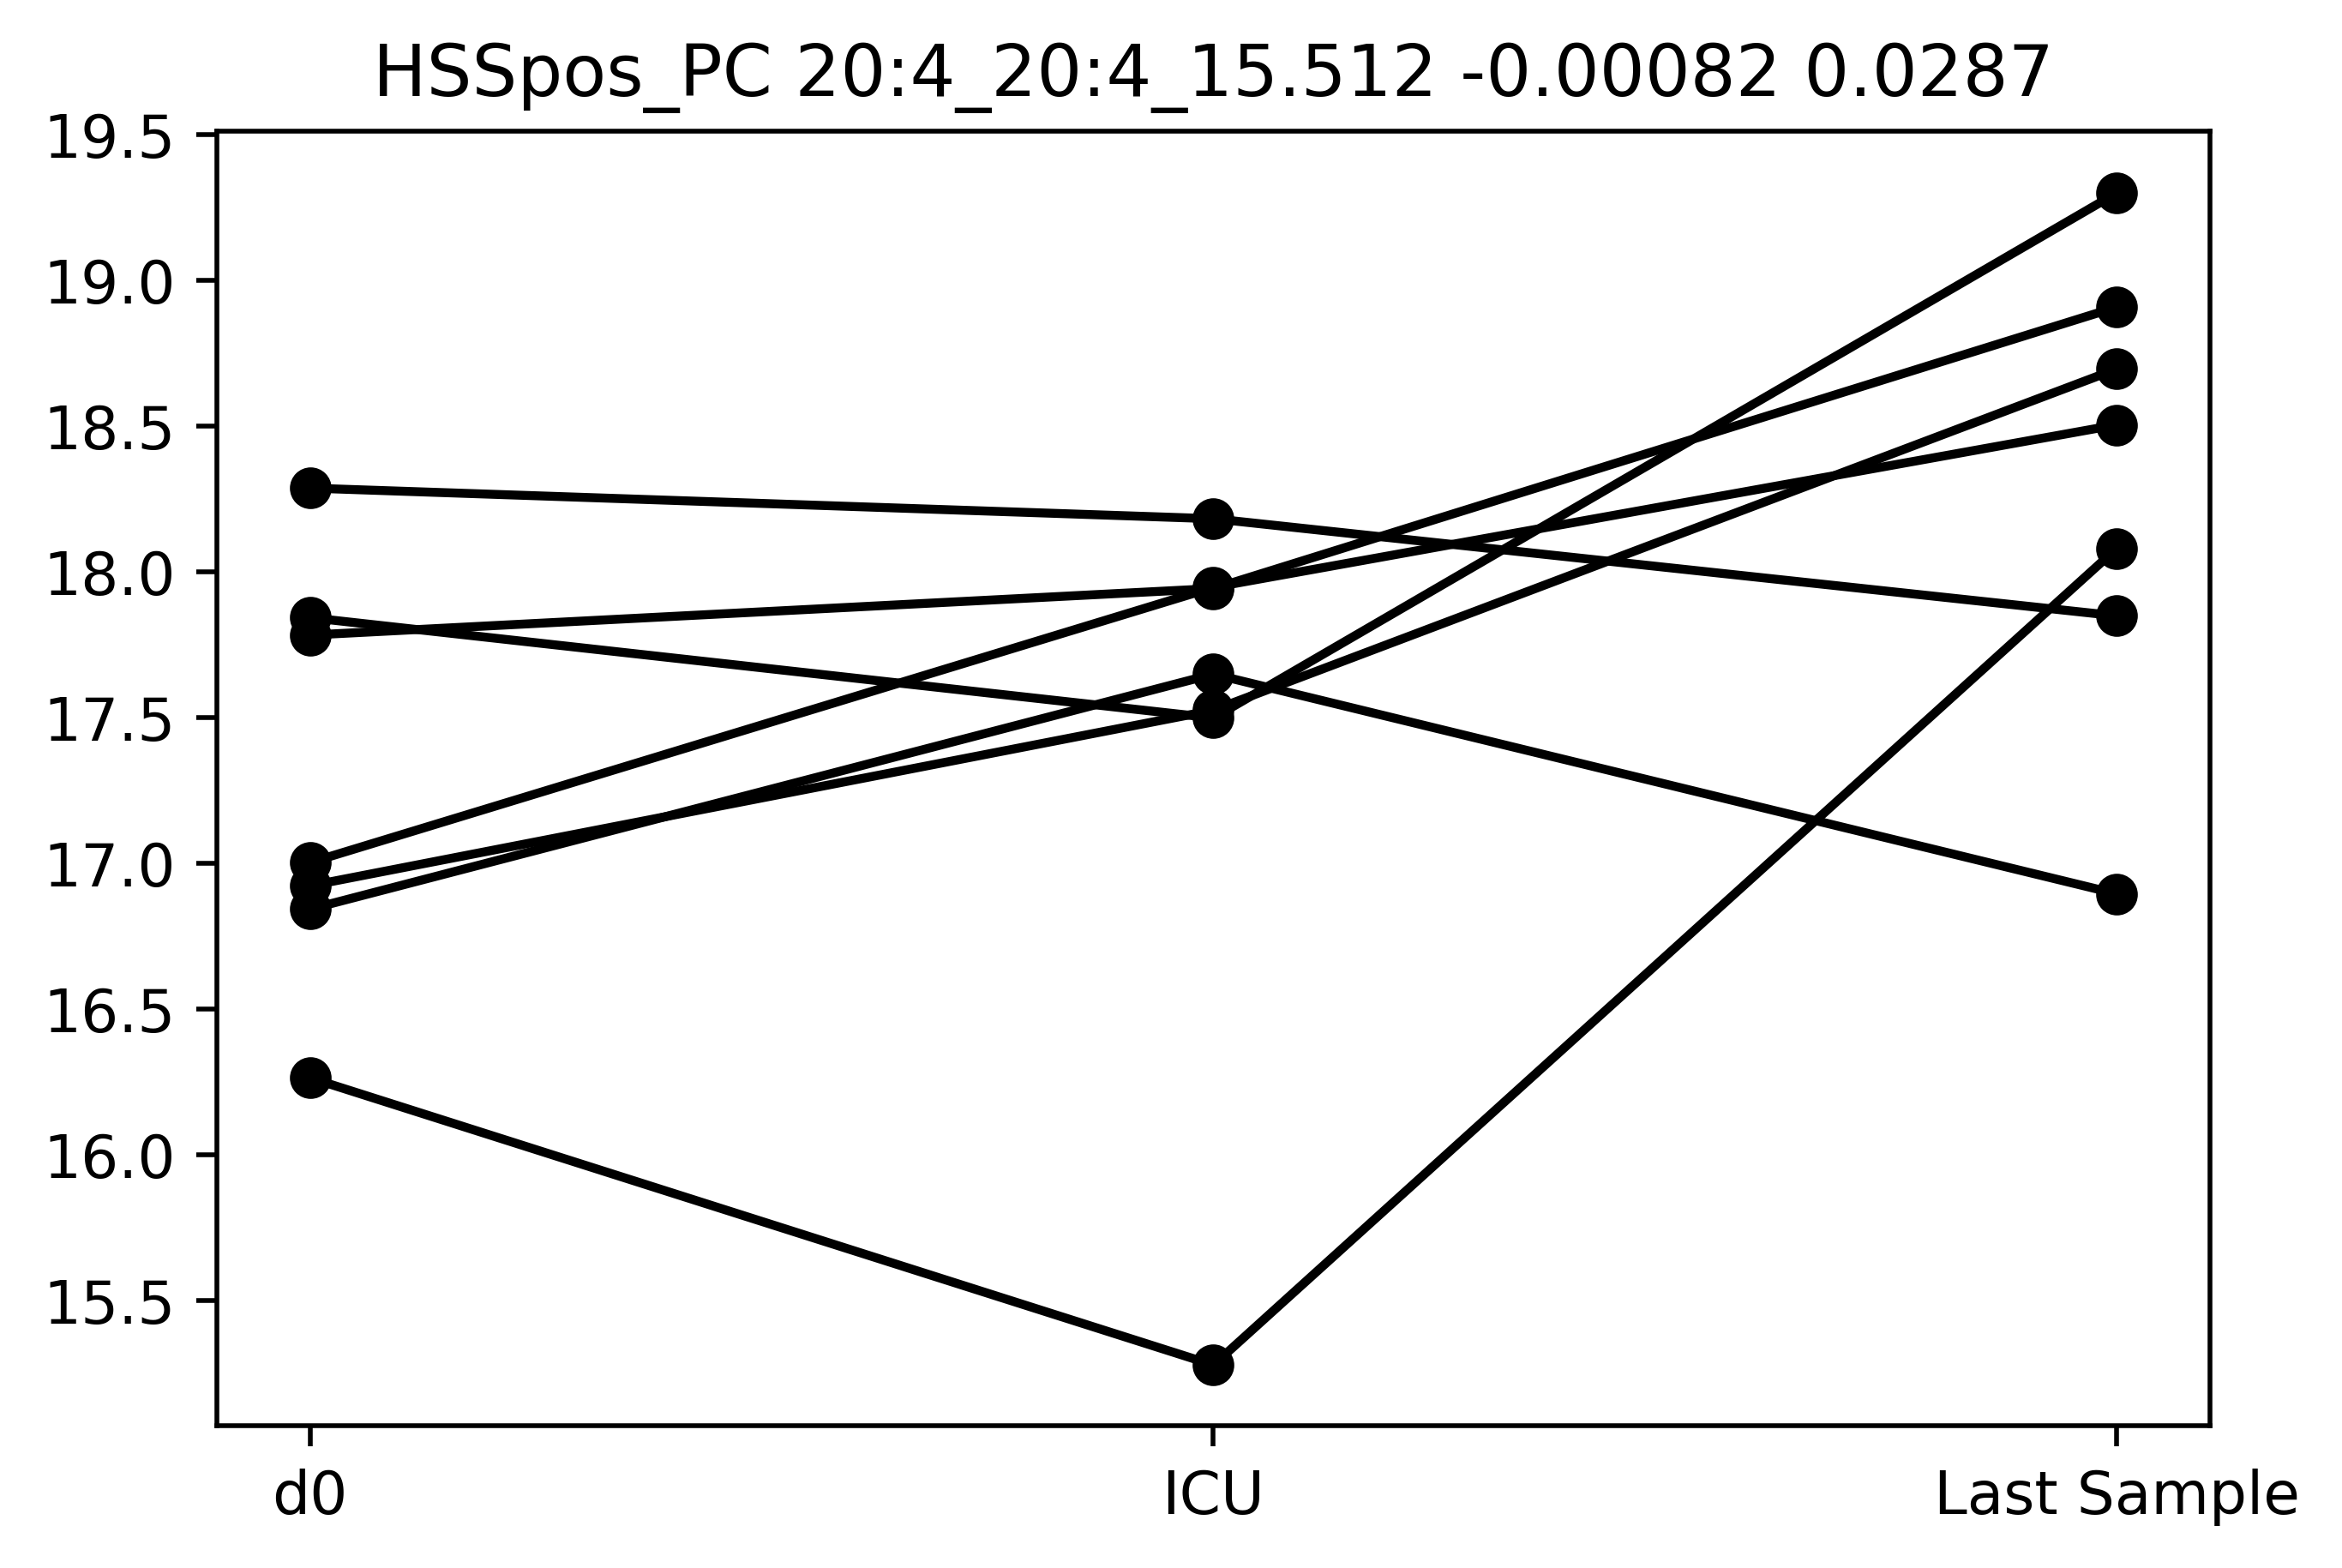

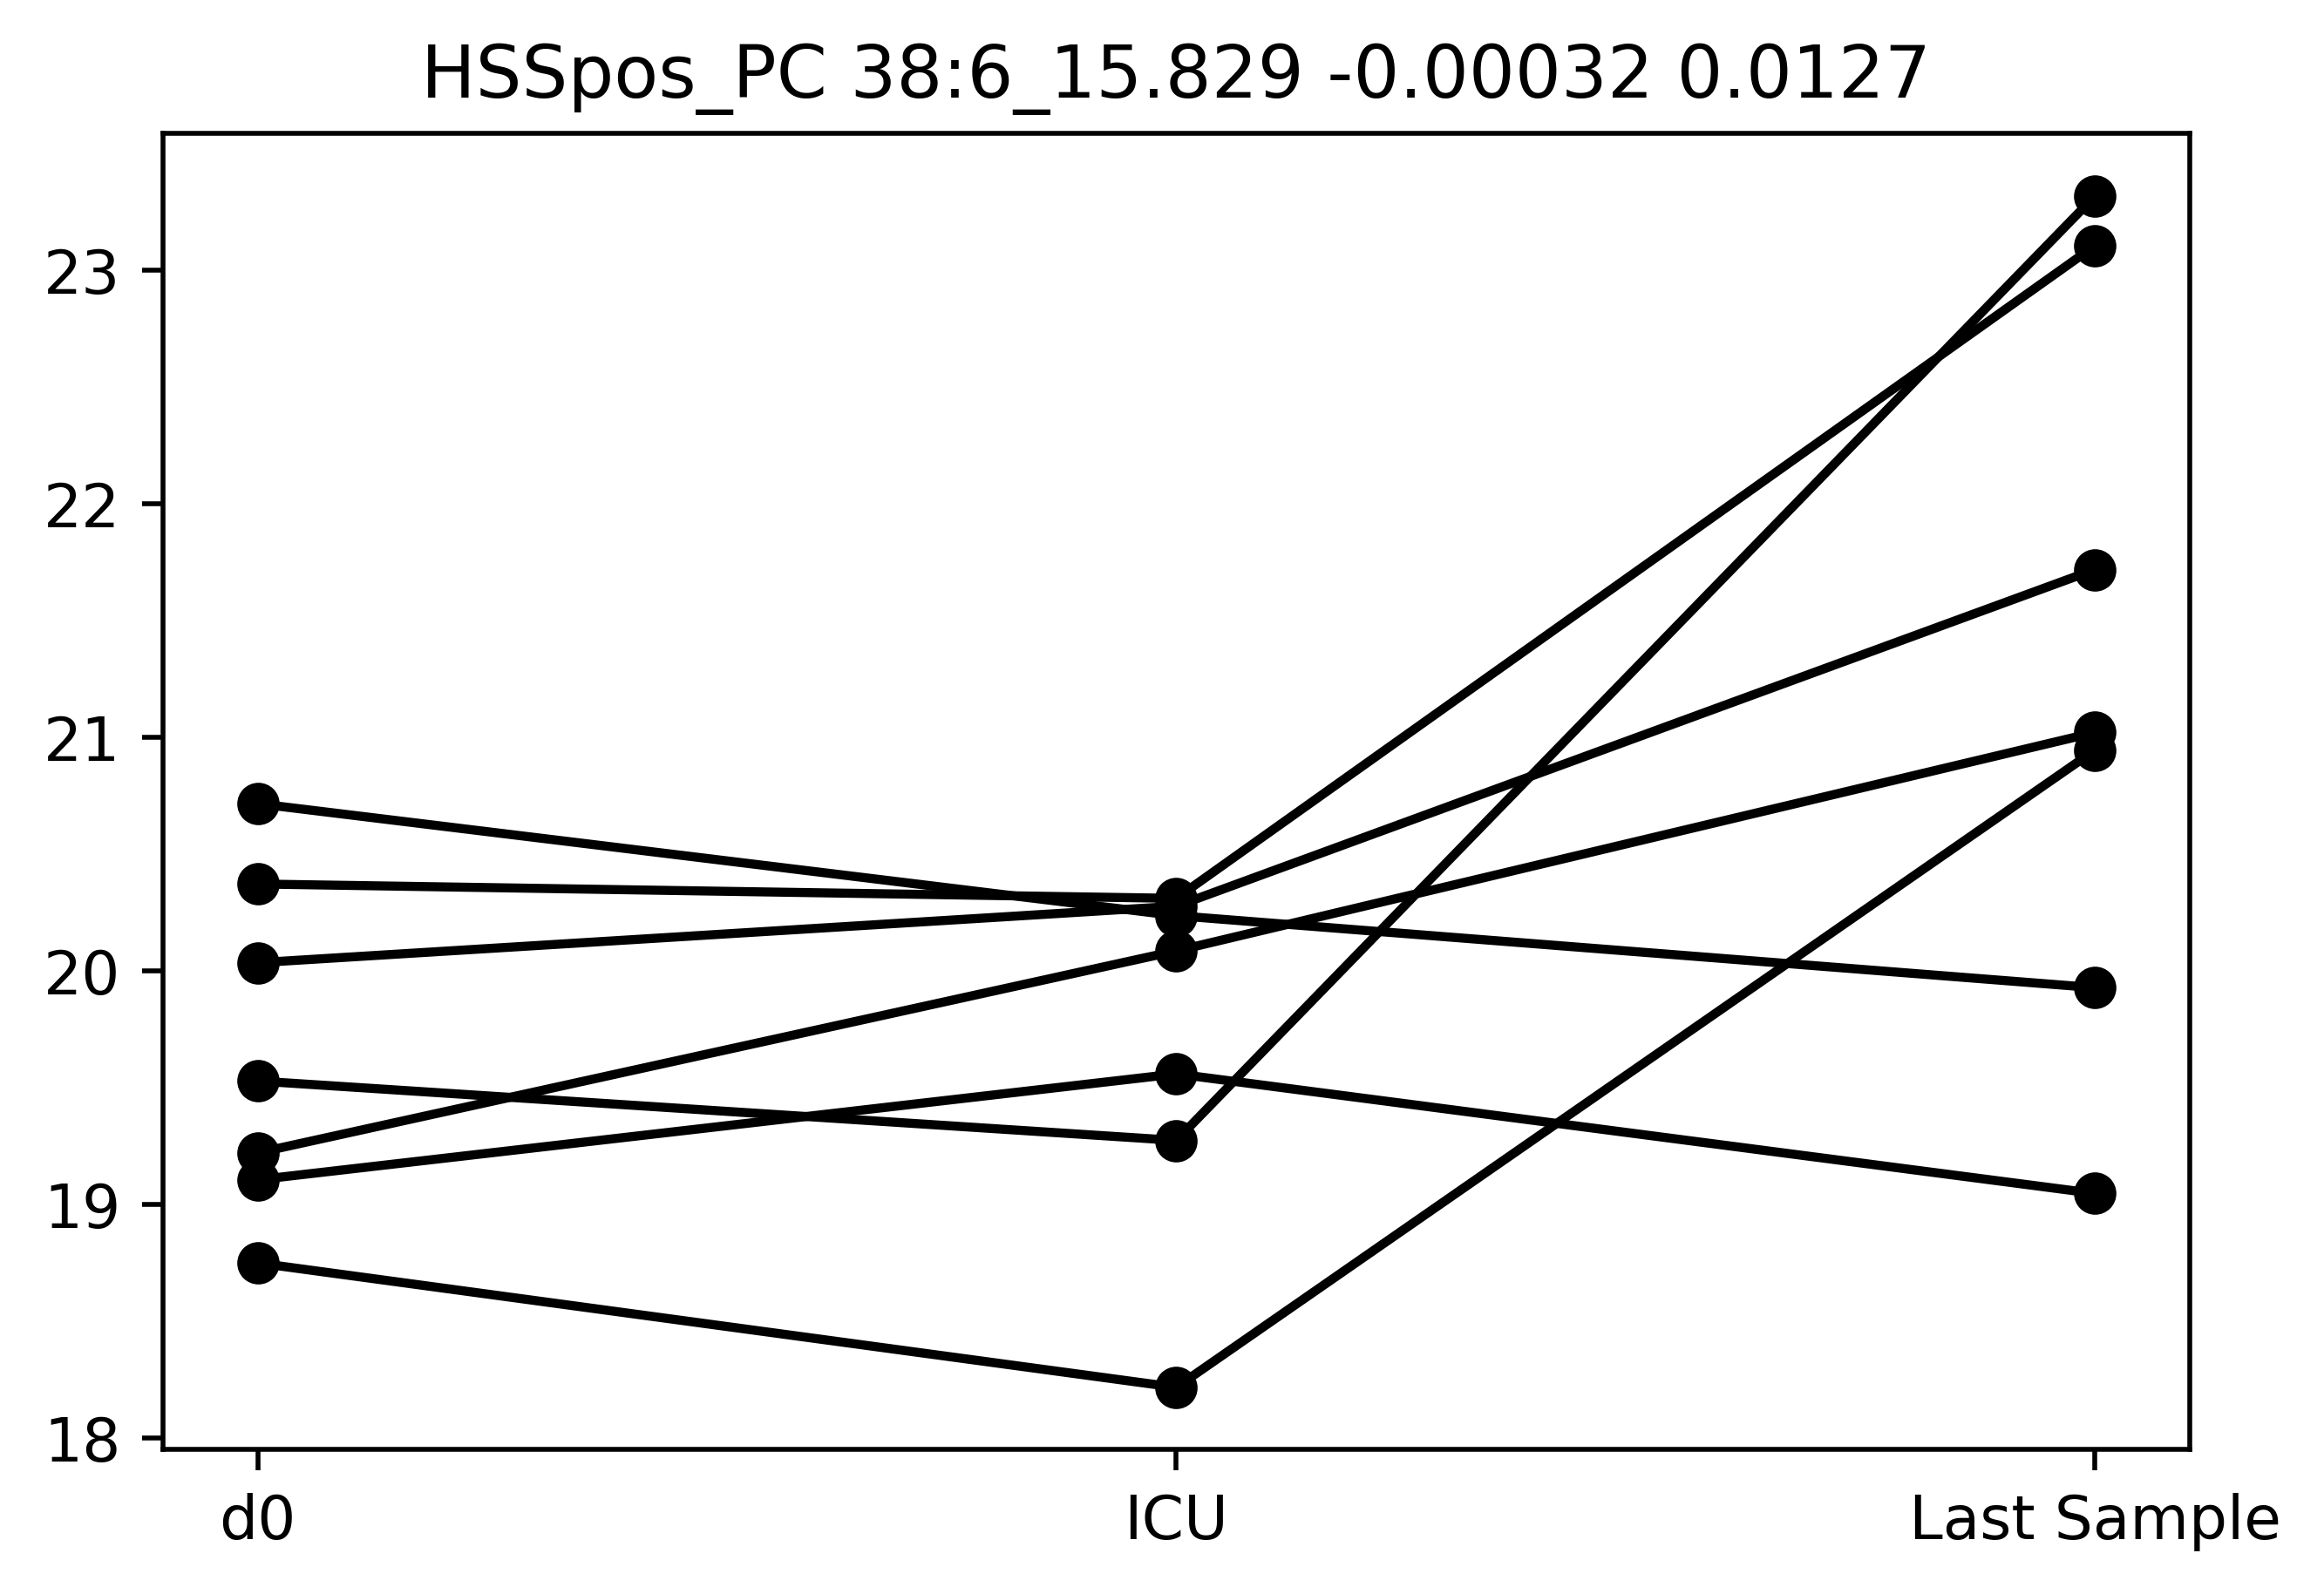

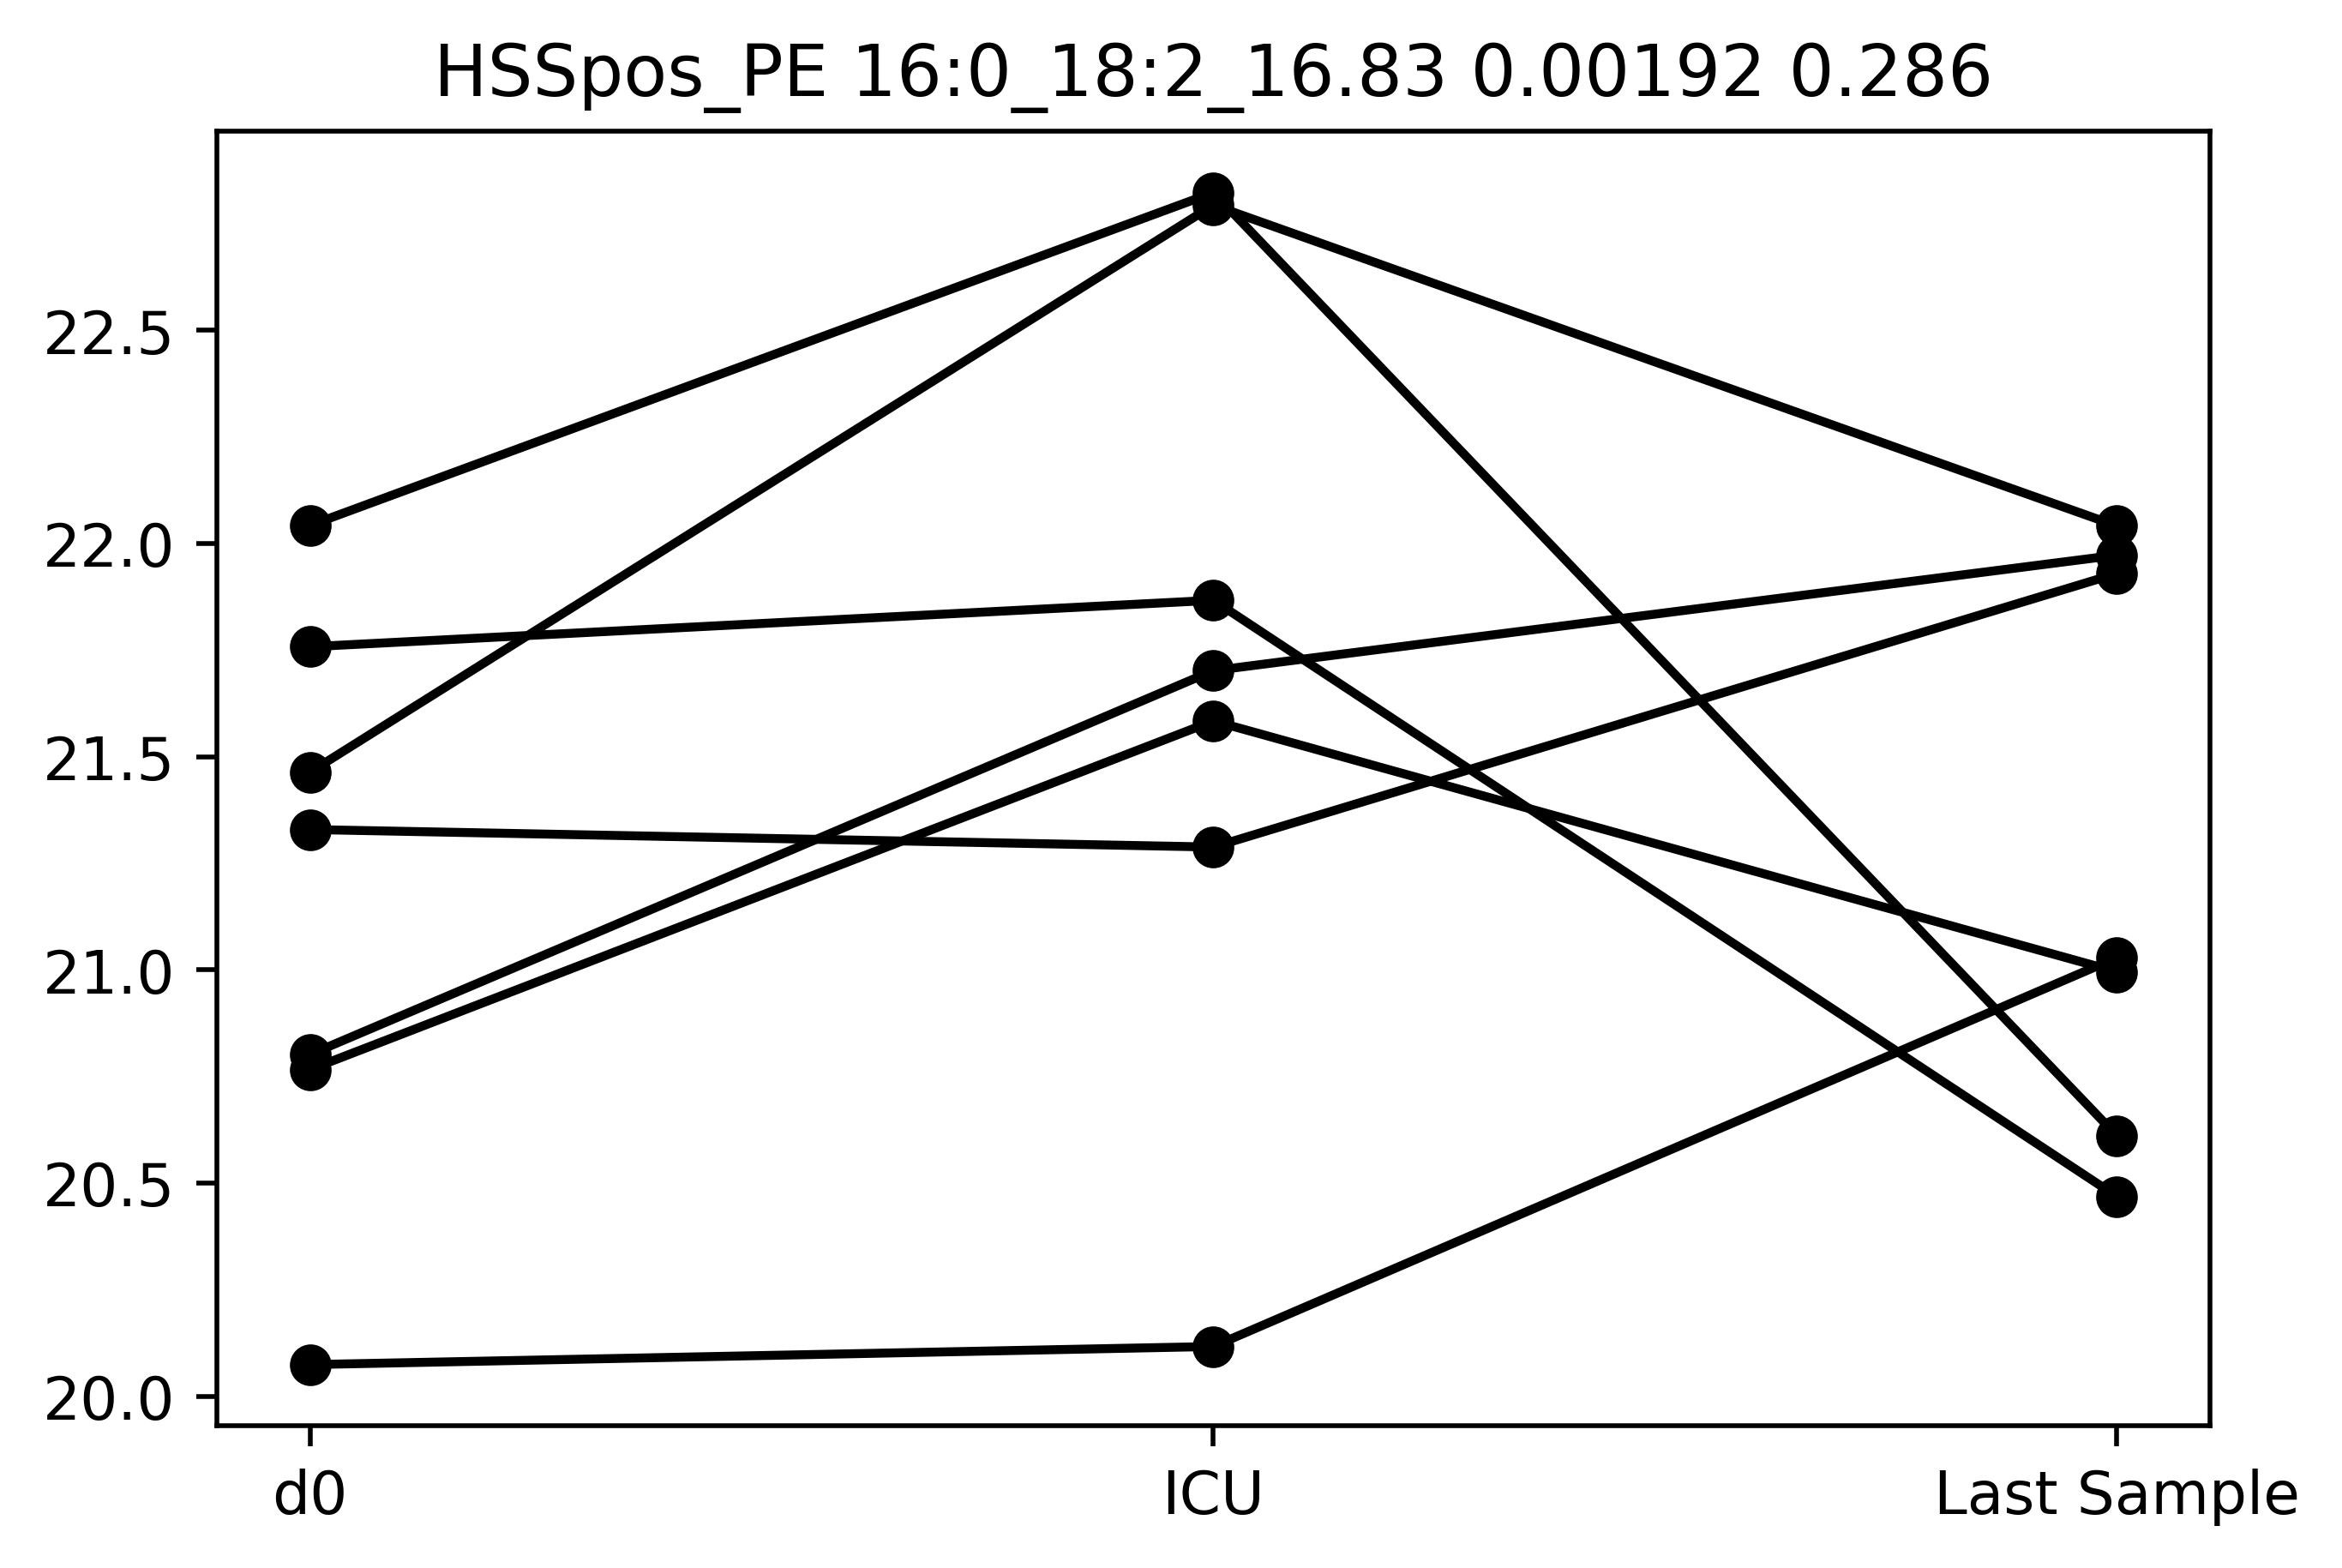

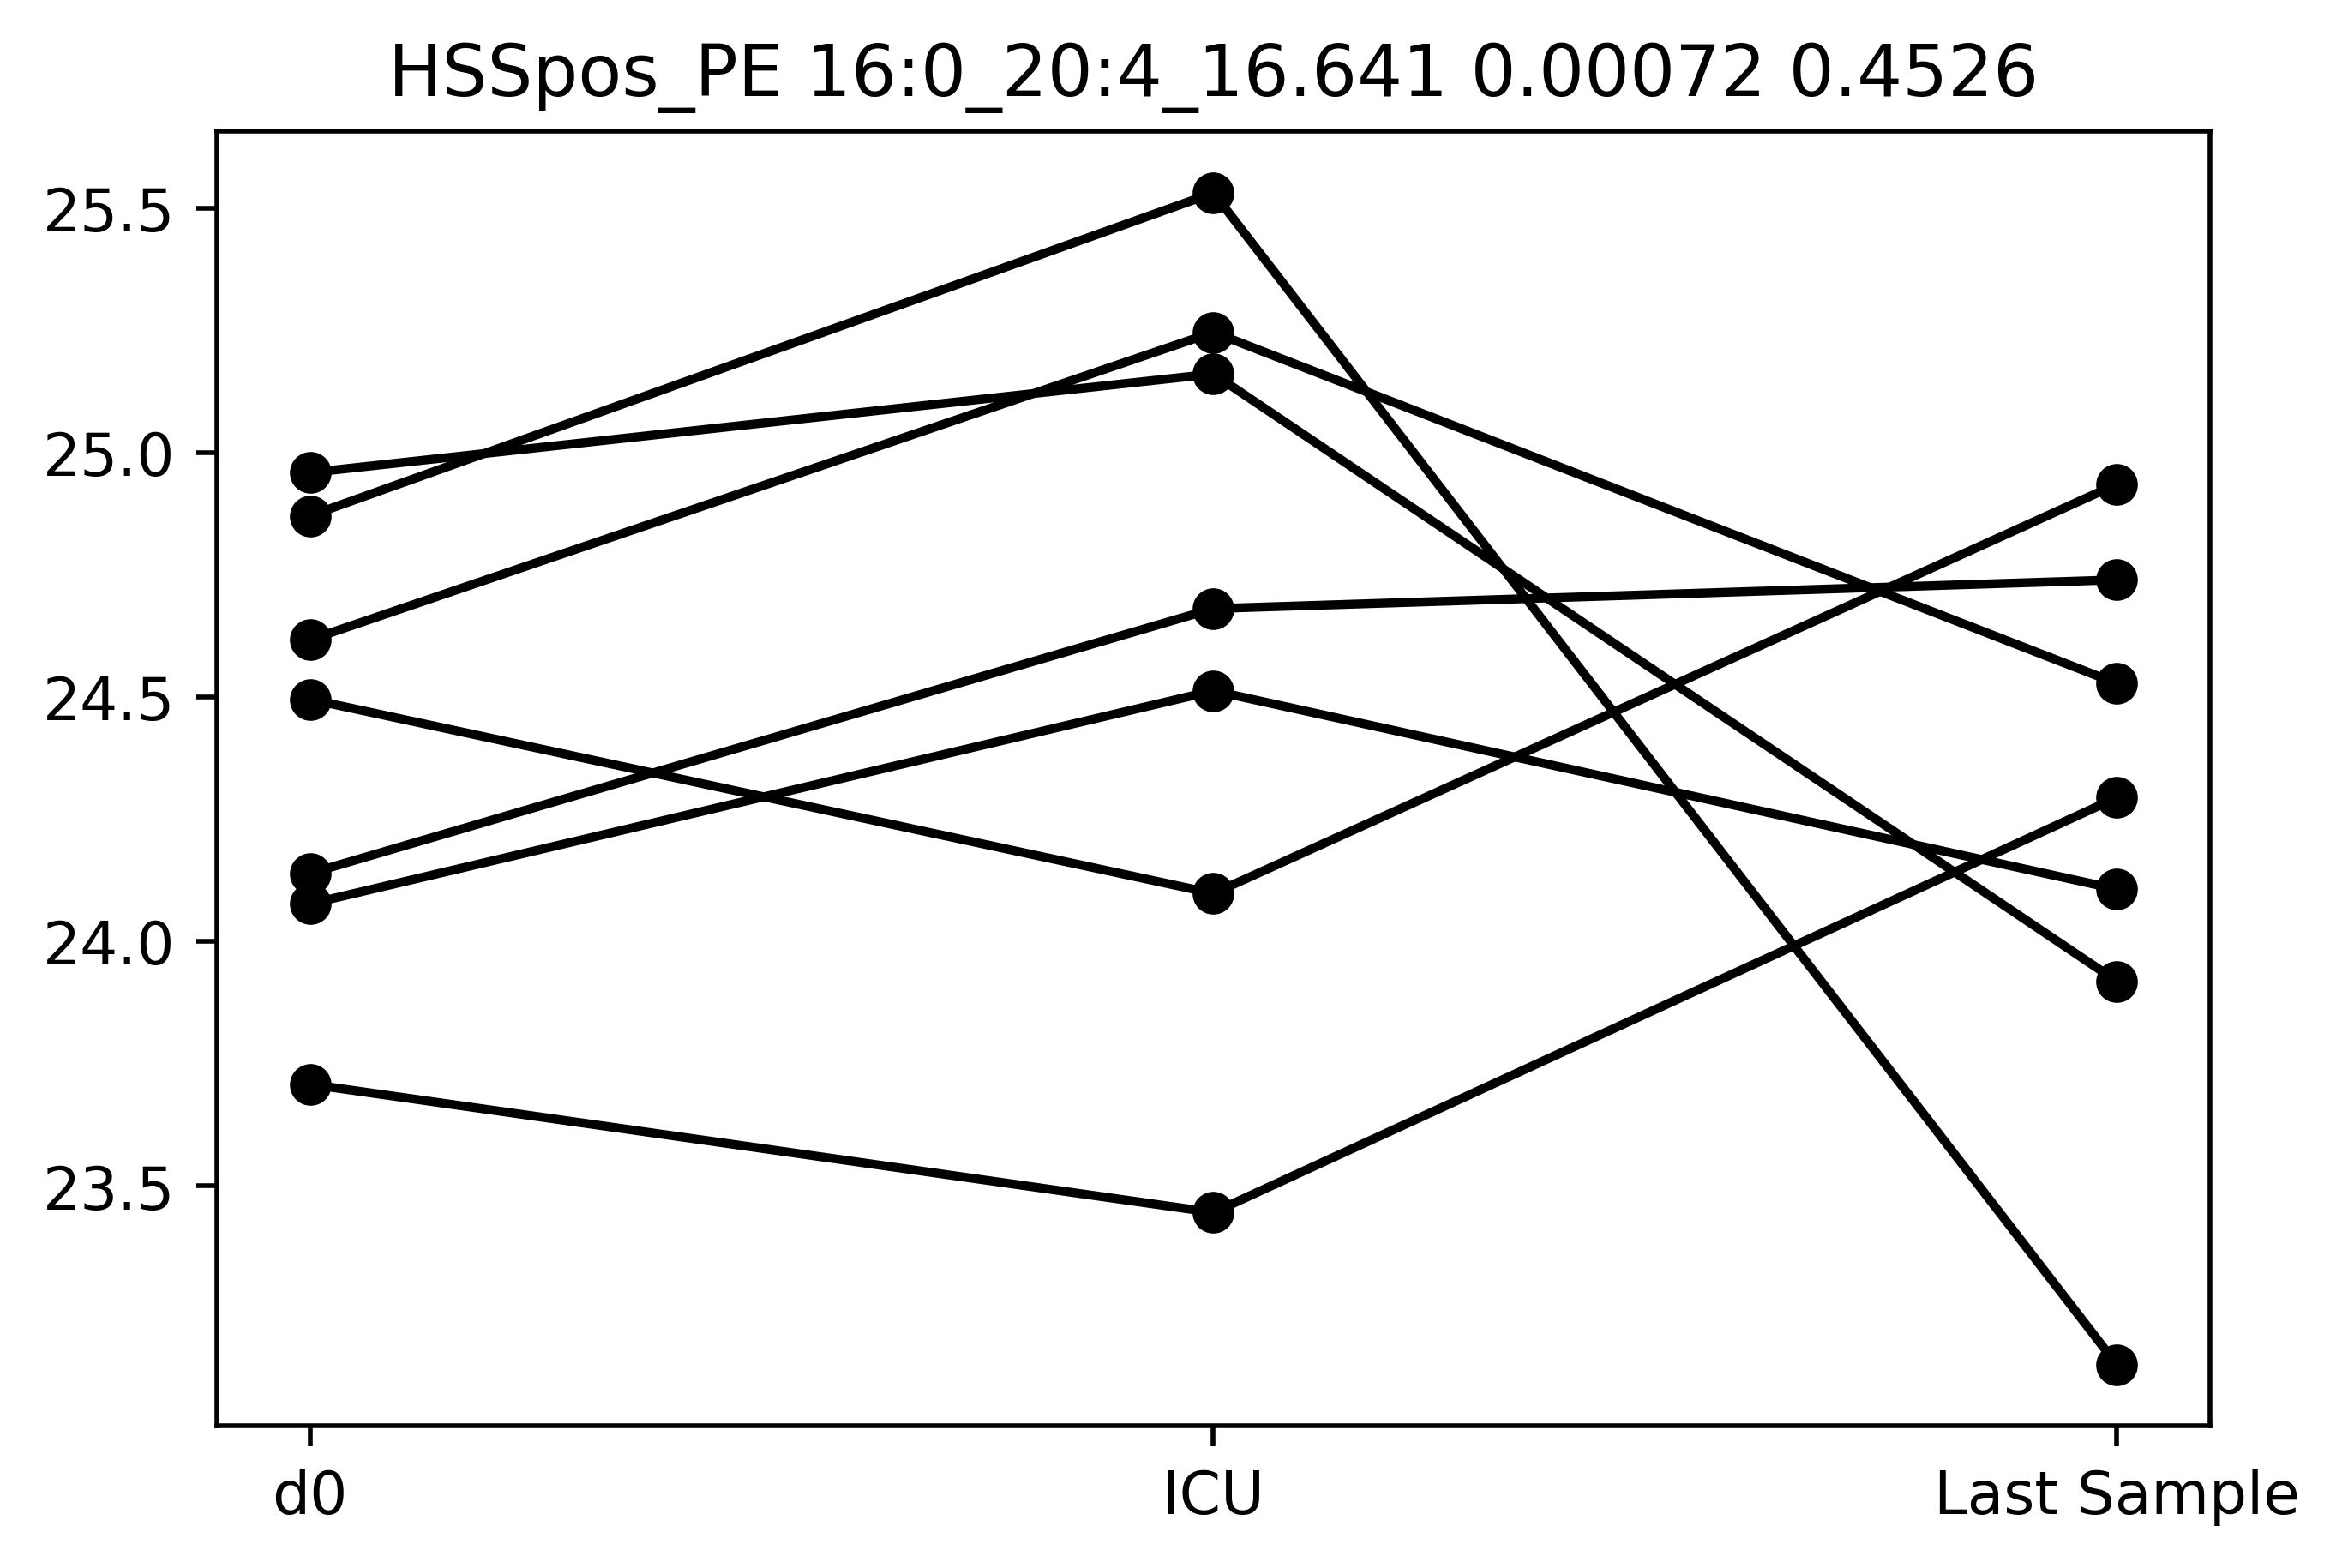

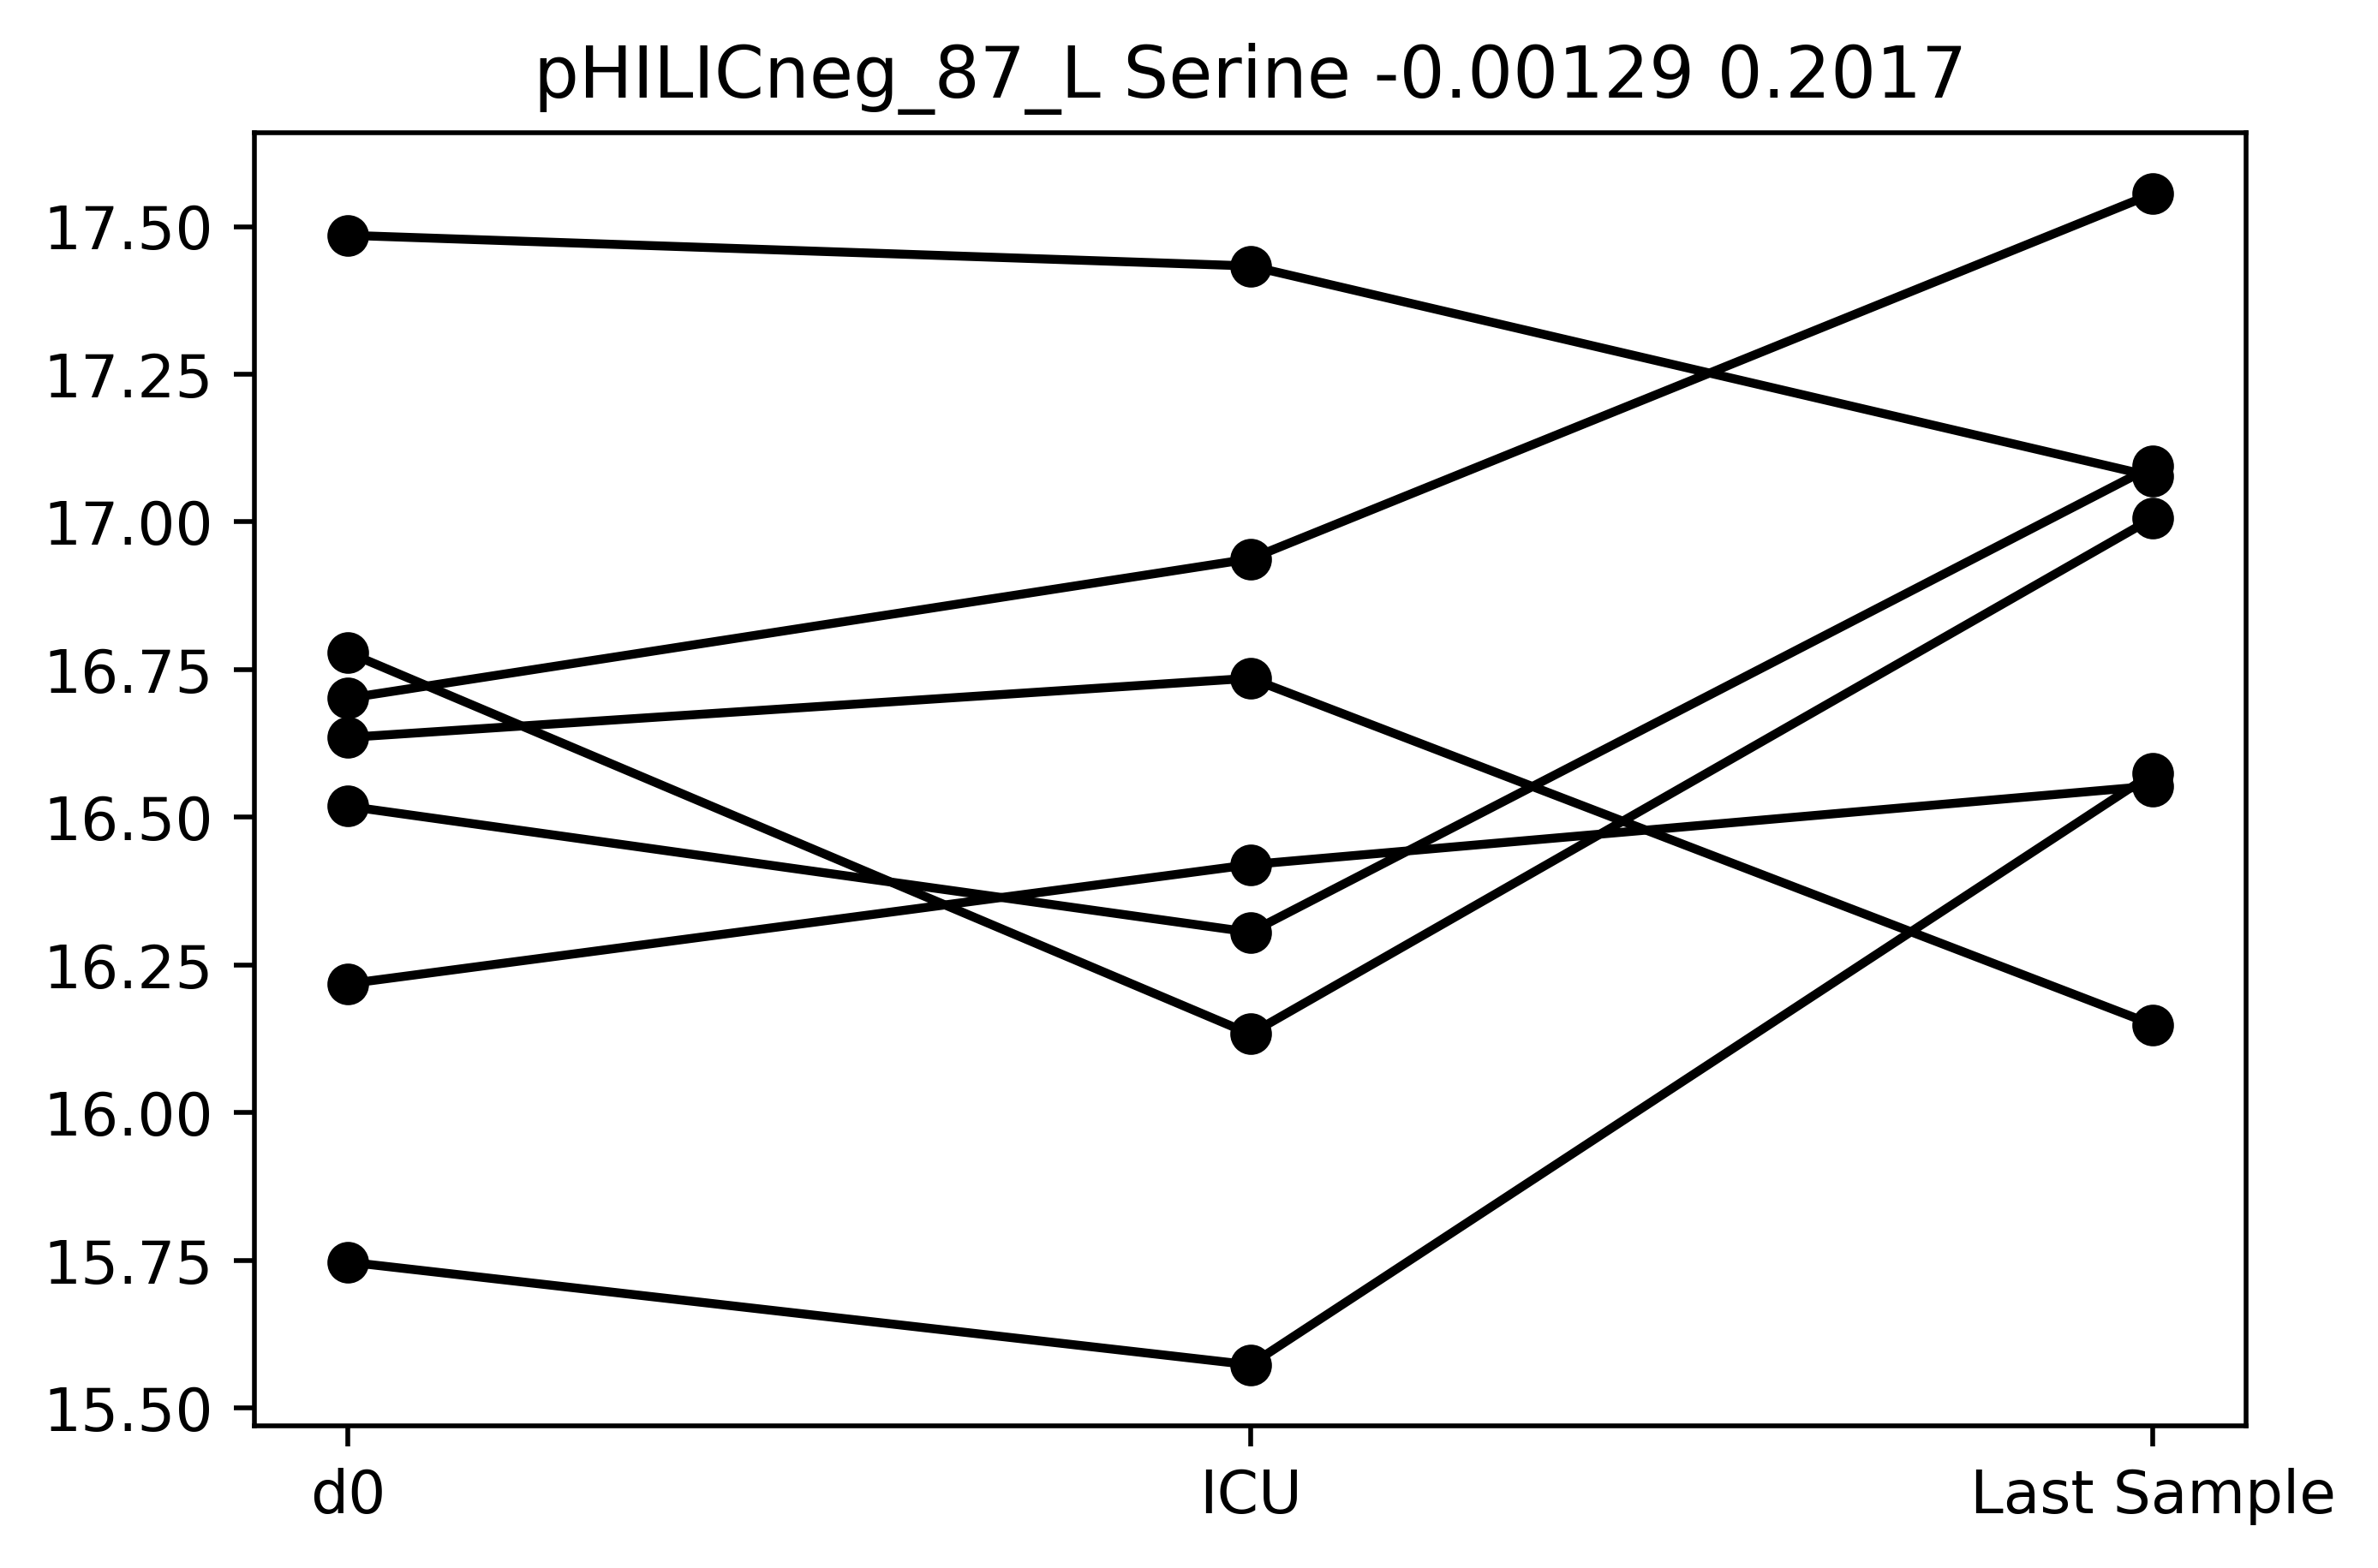

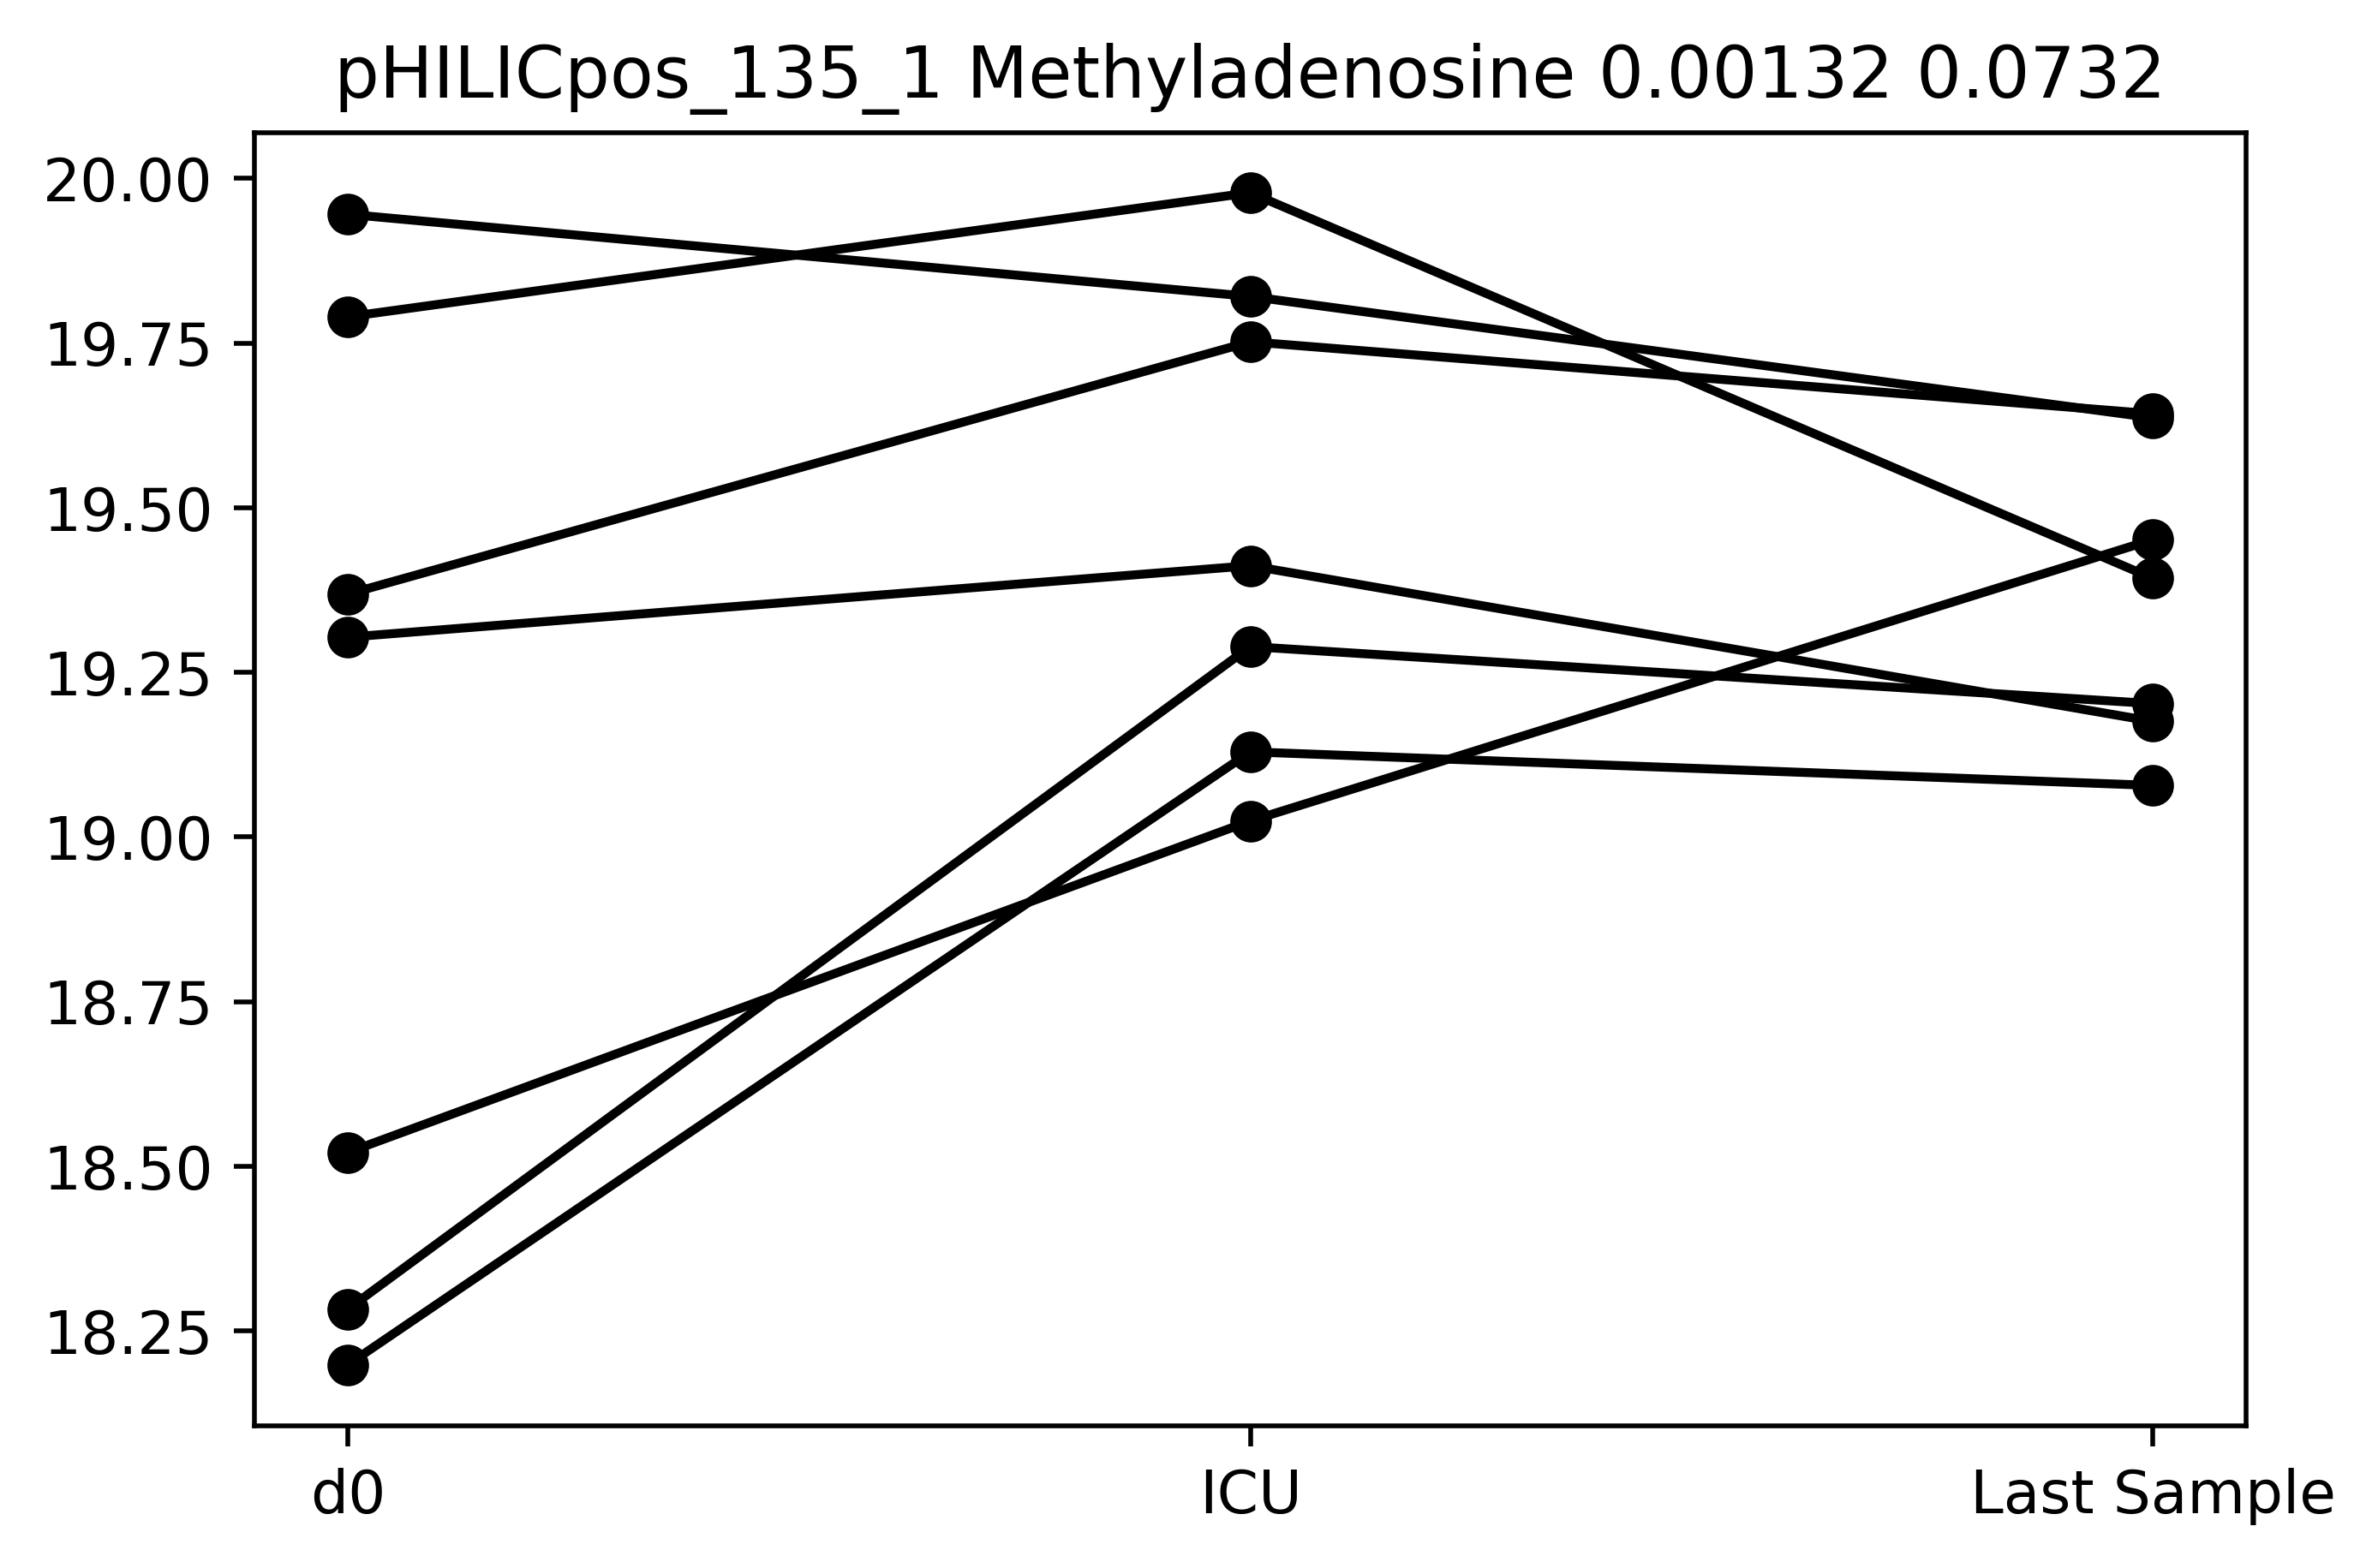

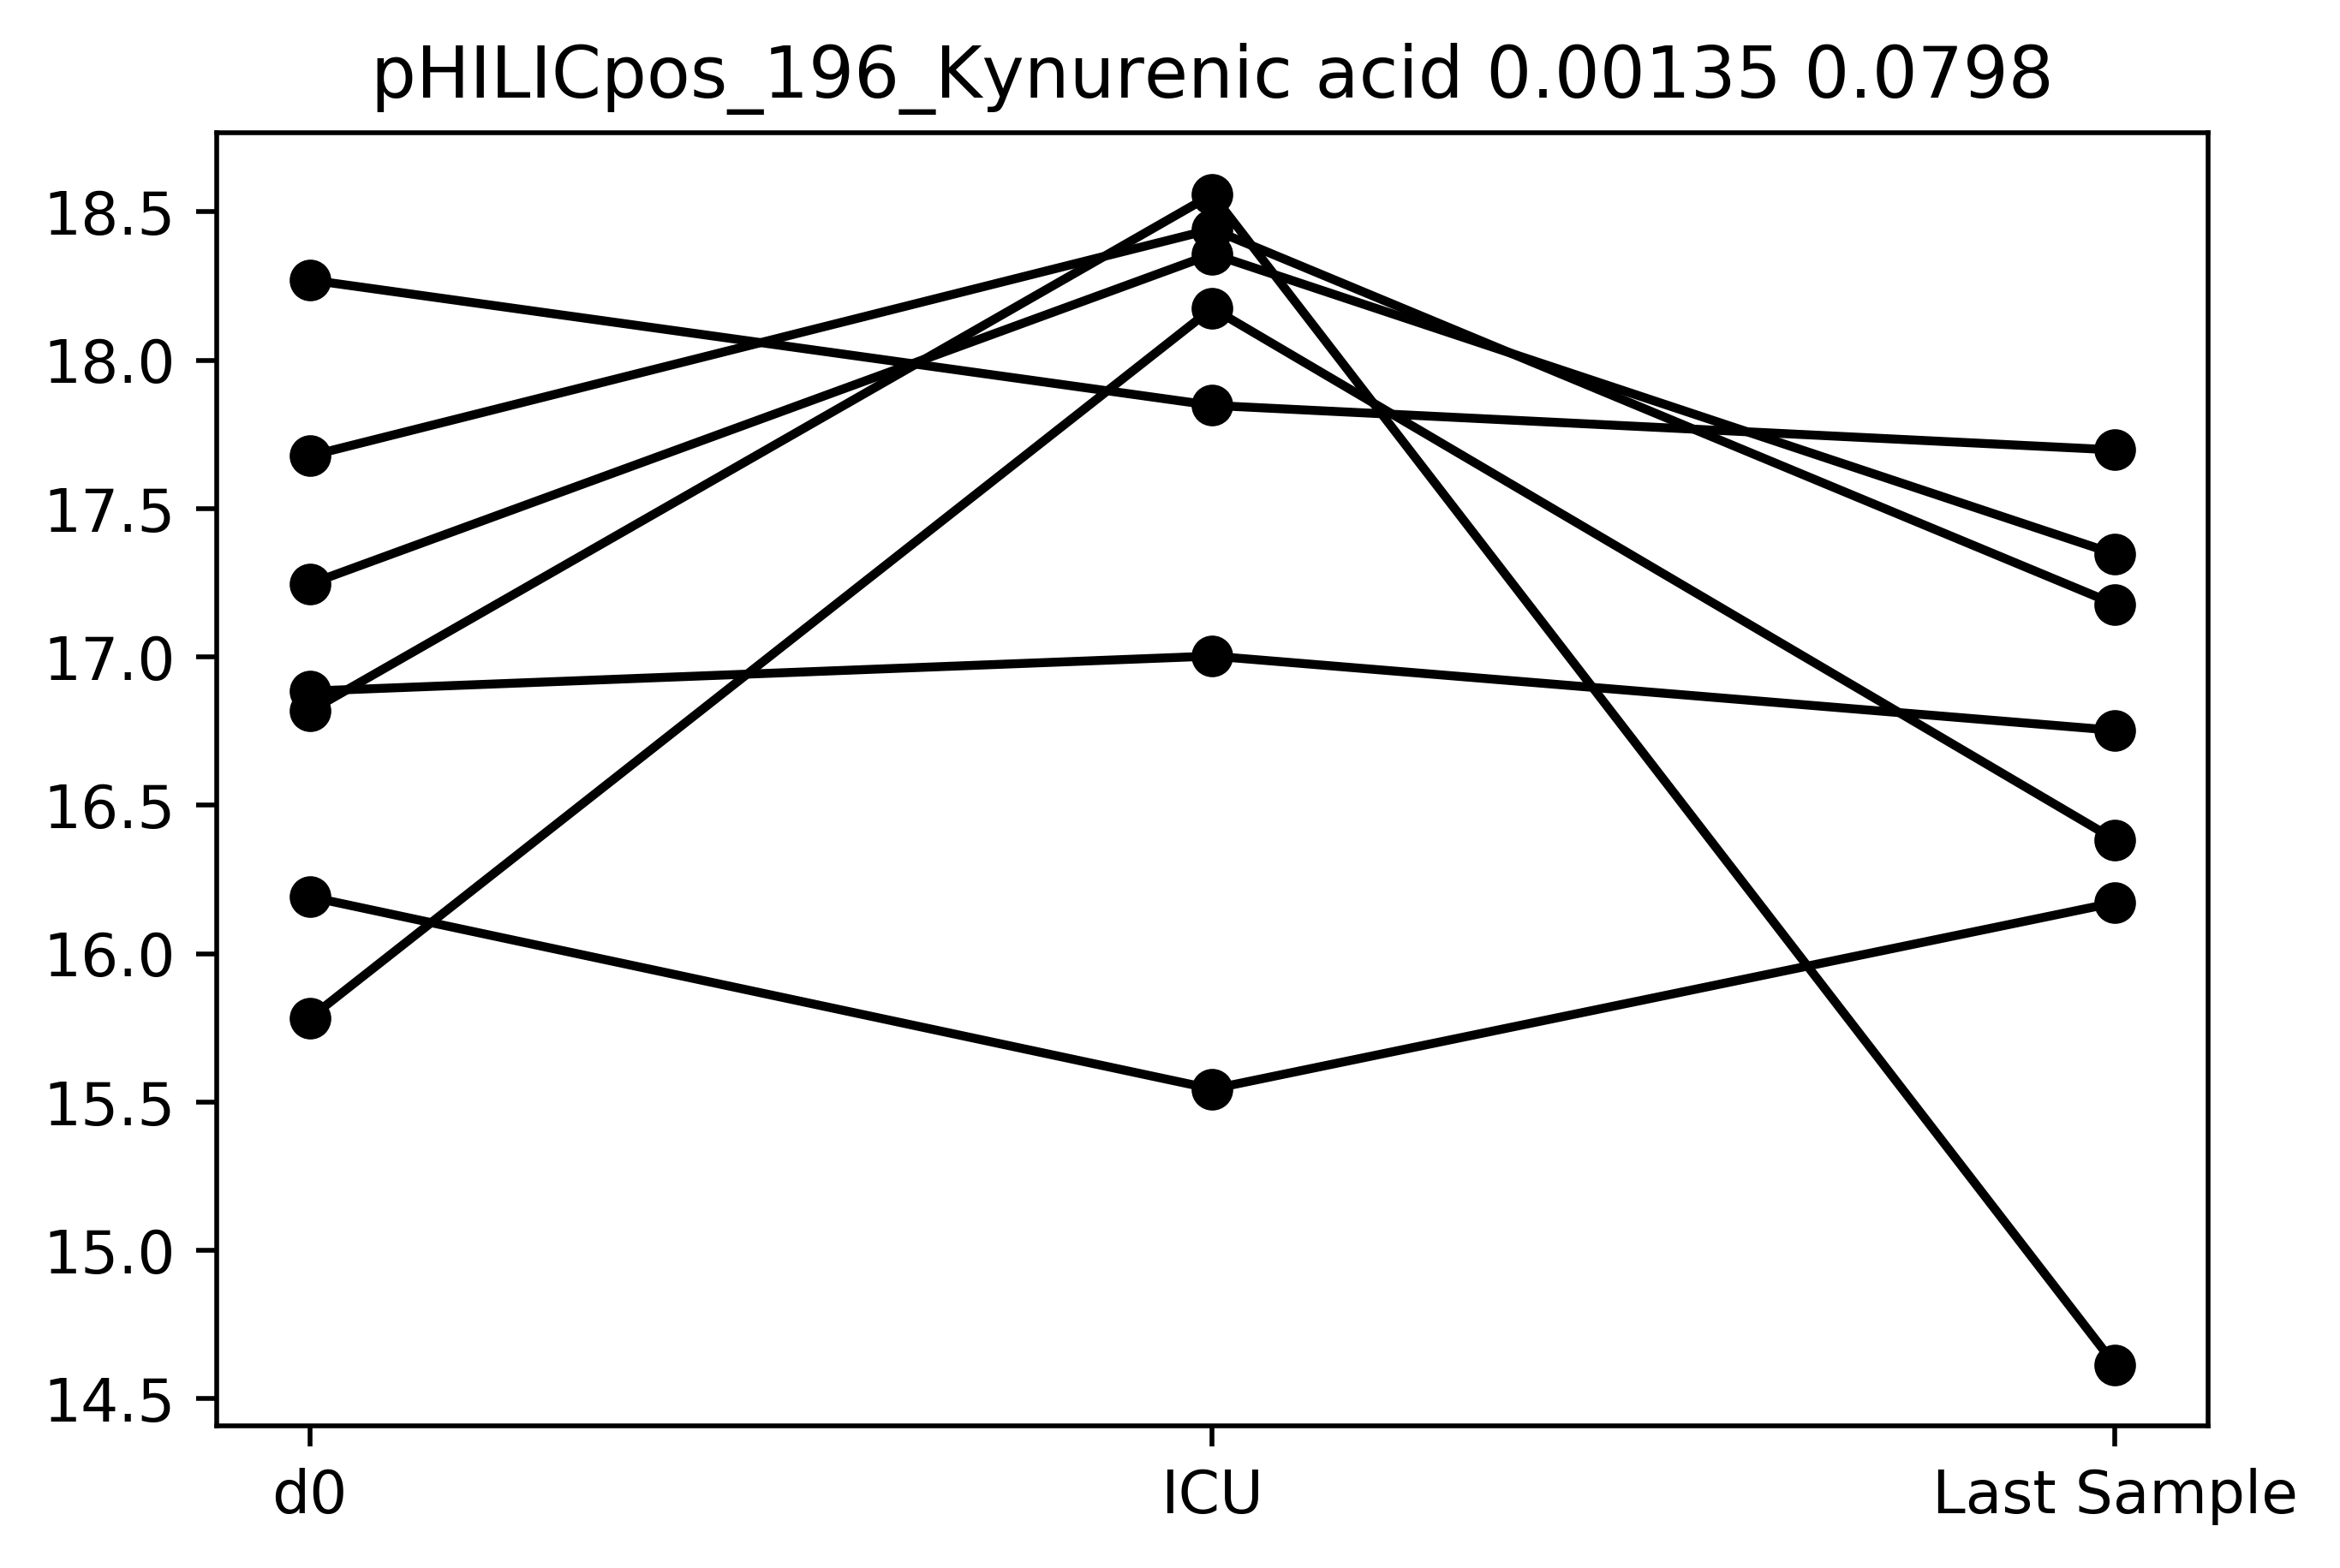

In [9]:
uniquePatients = list(set([x for x in sampleInfoDict["patient"]]))
goodPatients = [x for x in uniquePatients if len([y for y in sampleInfoDict["patient"].values if y == x]) > 2]
pvals = []
alpha = 0.05
for met in range(len(var_imp)):
    plt.figure()
    starts = []
    icus = []
    ends = []
    for pat in goodPatients:
        relsamples = [row["index"] for index,row in sampleInfoDict.iterrows() if row["patient"]==pat]
        times = [row["sample_day"] for index,row in sampleInfoDict.iterrows() if row["patient"]==pat]
        ICU = [row["ICU"] for index,row in sampleInfoDict.iterrows() if row["patient"]==pat][0]
        mort = [row["death"] for index,row in sampleInfoDict.iterrows() if row["patient"]==pat][0]
        if ICU and mort == "Alive":
            ICU_day = float([row["Day_to_ICU"] for index,row in sampleInfoDict.iterrows() if row["patient"]==pat][0])
            tmp = samp_int[relsamples,met]
            order = list(range(len(times)))
            order.sort(key=lambda x:times[x])
            tmp = tmp[order]
            #tmp = tmp - tmp[0]
            times = [times[x] for x in order]
            closestTime = times[0]
            err = np.inf
            for x in times:
                if np.abs(x-ICU_day) < err:
                    err = np.abs(x-ICU_day)
                    closestTime = x
            if closestTime != times[0] and closestTime != times[-1]:
                starts.append(tmp[0])
                icus.append(tmp[times.index(closestTime)])
                ends.append(tmp[-1])
                #tmp = tmp - tmp[0]
                plt.plot([0,1,2],[tmp[0],tmp[times.index(closestTime)],tmp[-1]],color="black")
                plt.scatter([0,1,2],[tmp[0],tmp[times.index(closestTime)],tmp[-1]],color="black")
    df = dict()
    ind = 0
    ps = 0
    for s,i,e in zip(starts,icus,ends):
        df[ind] = {"patient":ps,"time":"d0","val":s}
        ind += 1
        df[ind] = {"patient":ps,"time":"ICU","val":i}
        ind += 1
        df[ind] = {"patient":ps,"time":"end","val":e}
        ind += 1
        ps += 1
    p = AnovaRM(data=pd.DataFrame.from_dict(df,orient="index"),depvar="val",subject="patient",within = ["time"]).fit().anova_table["Pr > F"].values[0]
    pvals.append(p)
    plt.title(var_imp.index.values[met] + " " + str(np.round(var_imp.at[var_imp.index.values[met],"var_imp"],5)  ) + " " + str(np.round(p,4)))
    plt.xticks([0,1,2],labels=["d0","ICU","Last Sample"])

reject,pvals_corr,_,_ = multipletests(pvals,alpha,method="fdr_bh")
for name,p in zip(var_imp.index.values,pvals_corr):
    if p < alpha:
        print(name,p)


In [10]:
# for name,p in zip(var_imp.index.values[met],pvals_corr):
#     if p < alpha/len(var_imp):
#         print(name,p)

In [11]:
# measurement_data = pd.read_csv("../data/PMN_CRP_d-dimer_CO2_Comorbidities.csv")
# measurement_data

In [12]:
# plot_df = {}
# for patient in uniquePatients:
#     tmp = measurement_data[measurement_data["Patient"] == patient]
#     stat = sampleInfoDict[sampleInfoDict["patient"]==patient]["ICU"].values[0]
#     if len(tmp) > 0:
#         neut = tmp.at[tmp.index.values[0],"NEUTROPHIL"]
#         neut_per = tmp.at[tmp.index.values[0],"NEUTROPHIL PERCENT (%)"]
#         d = tmp.at[tmp.index.values[0],"D_DIMER"]
#         crp = tmp.at[tmp.index.values[0],"CRP"]
#         if not pd.isna(neut):
#             plot_df[patient] = {"ICU":stat,"NEUTROPHIL (K/cumm)":neut,"NEUTROPHIL (%)":neut_per}

# df = pd.DataFrame.from_dict(plot_df,orient="index")
# sb.boxplot(data=df,x="ICU",y="NEUTROPHIL (K/cumm)")
# sb.swarmplot(data=df,x="ICU",y="NEUTROPHIL (K/cumm)")

# stat,p = stats.ttest_ind(df[df["ICU"]==1]["NEUTROPHIL (K/cumm)"].values,df[df["ICU"]==0]["NEUTROPHIL (K/cumm)"].values,equal_var=False)
# plt.title(str(p))
# plt.figure()
# sb.boxplot(data=df,x="ICU",y="NEUTROPHIL (%)")
# sb.swarmplot(data=df,x="ICU",y="NEUTROPHIL (%)")

# stat,p = stats.ttest_ind(df[df["ICU"]==1]["NEUTROPHIL (%)"].values,df[df["ICU"]==0]["NEUTROPHIL (%)"].values,equal_var=False)
# plt.title(str(p))


In [13]:
# plot_df = {}
# for patient in uniquePatients:
#     tmp = measurement_data[measurement_data["Patient"] == patient]
#     stat = sampleInfoDict[sampleInfoDict["patient"]==patient]["ICU"].values[0]
#     if len(tmp) > 0:
#         neut = tmp.at[tmp.index.values[0],"NEUTROPHIL"]
#         neut_per = tmp.at[tmp.index.values[0],"NEUTROPHIL PERCENT (%)"]
#         d = tmp.at[tmp.index.values[0],"D_DIMER"]
#         crp = tmp.at[tmp.index.values[0],"CRP"]
#         if not pd.isna(d):
#             d = d.replace(">","").replace("<","")
#             d = float(d)
#             d = np.log2(d)
#             plot_df[patient] = {"ICU":stat,"log2(D_DIMER)":d}

# df = pd.DataFrame.from_dict(plot_df,orient="index")
# sb.boxplot(data=df,x="ICU",y="log2(D_DIMER)")
# sb.swarmplot(data=df,x="ICU",y="log2(D_DIMER)")

# stat,p = stats.ttest_ind(df[df["ICU"]==1]["log2(D_DIMER)"].values,df[df["ICU"]==0]["log2(D_DIMER)"].values,equal_var=False)
# plt.title(str(p))


In [14]:

# plot_df = {}
# for patient in uniquePatients:
#     tmp = measurement_data[measurement_data["Patient"] == patient]
#     stat = sampleInfoDict[sampleInfoDict["patient"]==patient]["ICU"].values[0]
#     if len(tmp) > 0:
#         neut = tmp.at[tmp.index.values[0],"NEUTROPHIL"]
#         neut_per = tmp.at[tmp.index.values[0],"NEUTROPHIL PERCENT (%)"]
#         d = tmp.at[tmp.index.values[0],"D_DIMER"]
#         crp = tmp.at[tmp.index.values[0],"CRP"]
#         if not pd.isna(crp):
#             #d = d.replace(">","")
#             #d = float(d)
#             #d = np.log2(d)
#             plot_df[patient] = {"ICU":stat,"CRP":crp}

# df = pd.DataFrame.from_dict(plot_df,orient="index")
# sb.boxplot(data=df,x="ICU",y="CRP",palette={1:"red",0,"orange"})
# sb.swarmplot(data=df,x="ICU",y="CRP")

# stat,p = stats.ttest_ind(df[df["ICU"]==1]["CRP"].values,df[df["ICU"]==0]["CRP"].values,equal_var=False)
# plt.title(str(p))


In [15]:
# plot_df = {}
# for patient in uniquePatients:
#     tmp = measurement_data[measurement_data["Patient"] == patient]
#     stat = sampleInfoDict[sampleInfoDict["patient"]==patient]["ICU"].values[0]
#     if len(tmp) > 0:
#         #if tmp.at[tmp.index.values[0],"Extreme pH"] > .5:
#             neut = tmp.at[tmp.index.values[0],"NEUTROPHIL"]
#             neut_per = tmp.at[tmp.index.values[0],"NEUTROPHIL PERCENT (%)"]
#             d = tmp.at[tmp.index.values[0],"D_DIMER"]
#             crp = tmp.at[tmp.index.values[0],"CRP"]
#             CO2 = tmp.at[tmp.index.values[0],"CO2"]
#             if not pd.isna(CO2):
#                 plot_df[patient] = {"ICU":stat,"CO2":CO2}

# df = pd.DataFrame.from_dict(plot_df,orient="index")
# sb.boxplot(data=df,x="ICU",y="CO2")
# sb.swarmplot(data=df,x="ICU",y="CO2")

# stat,p = stats.ttest_ind(df[df["ICU"]==1]["CO2"].values,df[df["ICU"]==0]["CO2"].values,equal_var=False)
# plt.title(str(p))


In [16]:

# plot_df = {}
# for patient in uniquePatients:
#     tmp = measurement_data[measurement_data["Patient"] == patient]
#     stat = sampleInfoDict[sampleInfoDict["patient"]==patient]["ICU"].values[0]
#     if len(tmp) > 0:
#         hyp = tmp.at[tmp.index.values[0],"Hypoxia"]
#         dia = tmp.at[tmp.index.values[0],"Diabetes"]
#         kid = tmp.at[tmp.index.values[0],"Kidney Disease"]
#         wl = tmp.at[tmp.index.values[0],"Weight Loss"]
#         can = tmp.at[tmp.index.values[0],"Cancer"]


#         plot_df[patient] = {"ICU":stat,"Hypoxia":hyp,"Diabetes":dia,"Kidney Disease":kid,"Weight Loss":wl,"Cancer":can}

# df = pd.DataFrame.from_dict(plot_df,orient="index")
# posit = 0
# poses = []
# label = []
# for column in ["Hypoxia","Diabetes","Kidney Disease","Weight Loss","Cancer"]:
#     tmp = df[df["ICU"]>.5]
#     pos = len(tmp[tmp[column]>.5])
#     totPos = len(tmp)
#     tmp = df[df["ICU"]<.5]
#     neg = len(tmp[tmp[column]>.5])
#     totNeg = len(tmp)
#     plt.bar([posit,posit+1],[neg/totNeg,pos/totPos],color=["steelblue","darkorange"])
#     label.append(column)
#     poses.append(posit+.5)
#     posit += 3
#     contingency = [[pos,totPos-pos],[neg,totNeg-neg]]
#     _,p = stats.fisher_exact(contingency)
#     print(column,p,contingency)
# plt.xticks(poses,labels=label,rotation=45)
# plt.xlim((min(poses)-1,max(poses)+1))
# plt.ylim((0,1))
# plt.ylabel("Proportion with comorbidity")
# plt.bar([-10],[-10],color="steelblue",label="ICU-")
# plt.bar([-10],[-10],color="darkorange",label="ICU+")
# plt.legend()

In [17]:

# plot_df = {}
# for patient in uniquePatients:
#     tmp = measurement_data[measurement_data["Patient"] == patient]
#     stat = sampleInfoDict[sampleInfoDict["patient"]==patient]["ICU"].values[0]
#     if len(tmp) > 0:
#         hyp = tmp.at[tmp.index.values[0],"Hypoxia"]
#         dia = tmp.at[tmp.index.values[0],"Diabetes"]
#         kid = tmp.at[tmp.index.values[0],"Kidney Disease"]
#         akid = tmp.at[tmp.index.values[0],"Acute Kidney Disease"]
#         wl = tmp.at[tmp.index.values[0],"Weight Loss"]
#         can = tmp.at[tmp.index.values[0],"Cancer"]
#         ph = tmp.at[tmp.index.values[0],"Extreme pH"]


#         plot_df[patient] = {"Acute Kidney Disease":akid,"ICU":stat,"Hypoxia":hyp,"Diabetes":dia,"Kidney Disease":kid,"Weight Loss":wl,"Cancer":can,"Extreme pH":ph}

# df = pd.DataFrame.from_dict(plot_df,orient="index")
# posit = 0
# poses = []
# label = []
# for column in ["Hypoxia","Diabetes","Kidney Disease","Acute Kidney Disease","Weight Loss","Cancer","Extreme pH"]:
#     tmp = df[df["ICU"]>.5]
#     pos = len(tmp[tmp[column]>.5])
#     totPos = len(tmp)
#     tmp = df[df["ICU"]<.5]
#     neg = len(tmp[tmp[column]>.5])
#     totNeg = len(tmp)
#     plt.bar([posit,posit+1],[neg/totNeg,pos/totPos],color=["steelblue","darkorange"])
#     label.append(column)
#     poses.append(posit+.5)
#     posit += 3
#     contingency = [[pos,totPos-pos],[neg,totNeg-neg]]
#     _,p = stats.fisher_exact(contingency)
#     print(column,p,contingency)
# plt.xticks(poses,labels=label,rotation=45)
# plt.xlim((min(poses)-1,max(poses)+1))
# plt.ylim((0,1))
# plt.ylabel("Proportion with comorbidity")
# plt.bar([-10],[-10],color="steelblue",label="ICU-")
# plt.bar([-10],[-10],color="darkorange",label="ICU+")
# plt.legend()

In [18]:
# patientsOfInterest = []

In [19]:
# uniquePatients = list(set([x for x in sampleInfoDict["patient"]]))
# goodPatients = [x for x in uniquePatients if len([y for y in sampleInfoDict["patient"].values if y == x]) > 2 and df.at[x,"Kidney Disease"] == 0]
# for met in range(len(var_imp)):
#     plt.figure()
#     starts = []
#     icus = []
#     ends = []
#     for pat in goodPatients:
#         relsamples = [row["index"] for index,row in sampleInfoDict.iterrows() if row["patient"]==pat]
#         times = [row["sample_day"] for index,row in sampleInfoDict.iterrows() if row["patient"]==pat]
#         ICU = [row["ICU"] for index,row in sampleInfoDict.iterrows() if row["patient"]==pat][0]
#         mort = [row["death"] for index,row in sampleInfoDict.iterrows() if row["patient"]==pat][0]
#         if ICU and mort == "Alive":
#             ICU_day = float([row["Day_to_ICU"] for index,row in sampleInfoDict.iterrows() if row["patient"]==pat][0])
#             tmp = samp_int[relsamples,met]
#             order = list(range(len(times)))
#             order.sort(key=lambda x:times[x])
#             tmp = tmp[order]
#             #tmp = tmp - tmp[0]
#             times = [times[x] for x in order]
#             closestTime = times[0]
#             err = np.inf
#             for x in times:
#                 if np.abs(x-ICU_day) < err:
#                     err = np.abs(x-ICU_day)
#                     closestTime = x
#             if closestTime != times[0] and closestTime != times[-1]:
#                 starts.append(tmp[0])
#                 icus.append(tmp[times.index(closestTime)])
#                 ends.append(tmp[-1])
#                 #tmp = tmp - tmp[0]
#                 plt.plot([0,1,2],[tmp[0],tmp[times.index(closestTime)],tmp[-1]],color="black")
#                 plt.scatter([0,1,2],[tmp[0],tmp[times.index(closestTime)],tmp[-1]],color="black")
#     dft = dict()
#     ind = 0
#     ps = 0
#     for s,i,e in zip(starts,icus,ends):
#         dft[ind] = {"patient":ps,"time":"d0","val":s}
#         ind += 1
#         dft[ind] = {"patient":ps,"time":"ICU","val":i}
#         ind += 1
#         dft[ind] = {"patient":ps,"time":"end","val":e}
#         ind += 1
#         ps += 1
#     p = AnovaRM(data=pd.DataFrame.from_dict(dft,orient="index"),depvar="val",subject="patient",within = ["time"]).fit().anova_table["Pr > F"].values[0]
#     plt.title(var_imp.index.values[met] + " " + str(np.round(var_imp.at[var_imp.index.values[met],"var_imp"],5)  ) + " " + str(np.round(p,4)))
#     plt.xticks([0,1,2],labels=["d0","ICU","Last Sample"])
    


In [20]:
# uniquePatients = list(set([x for x in sampleInfoDict["patient"]]))
# goodPatients = [x for x in uniquePatients if len([y for y in sampleInfoDict["patient"].values if y == x]) > 2 and df.at[x,"Hypoxia"] == 0]
# for met in range(len(var_imp)):
#     plt.figure()
#     starts = []
#     icus = []
#     ends = []
#     for pat in goodPatients:
#         relsamples = [row["index"] for index,row in sampleInfoDict.iterrows() if row["patient"]==pat]
#         times = [row["sample_day"] for index,row in sampleInfoDict.iterrows() if row["patient"]==pat]
#         ICU = [row["ICU"] for index,row in sampleInfoDict.iterrows() if row["patient"]==pat][0]
#         mort = [row["death"] for index,row in sampleInfoDict.iterrows() if row["patient"]==pat][0]
#         if ICU and mort == "Alive":
#             ICU_day = float([row["Day_to_ICU"] for index,row in sampleInfoDict.iterrows() if row["patient"]==pat][0])
#             tmp = samp_int[relsamples,met]
#             order = list(range(len(times)))
#             order.sort(key=lambda x:times[x])
#             tmp = tmp[order]
#             #tmp = tmp - tmp[0]
#             times = [times[x] for x in order]
#             closestTime = times[0]
#             err = np.inf
#             for x in times:
#                 if np.abs(x-ICU_day) < err:
#                     err = np.abs(x-ICU_day)
#                     closestTime = x
#             if closestTime != times[0] and closestTime != times[-1]:
#                 starts.append(tmp[0])
#                 icus.append(tmp[times.index(closestTime)])
#                 ends.append(tmp[-1])
#                 #tmp = tmp - tmp[0]
#                 plt.plot([0,1,2],[tmp[0],tmp[times.index(closestTime)],tmp[-1]],color="black")
#                 plt.scatter([0,1,2],[tmp[0],tmp[times.index(closestTime)],tmp[-1]],color="black")
#     dft = dict()
#     ind = 0
#     ps = 0
#     for s,i,e in zip(starts,icus,ends):
#         dft[ind] = {"patient":ps,"time":"d0","val":s}
#         ind += 1
#         dft[ind] = {"patient":ps,"time":"ICU","val":i}
#         ind += 1
#         dft[ind] = {"patient":ps,"time":"end","val":e}
#         ind += 1
#         ps += 1
#     p = AnovaRM(data=pd.DataFrame.from_dict(dft,orient="index"),depvar="val",subject="patient",within = ["time"]).fit().anova_table["Pr > F"].values[0]
#     plt.title(var_imp.index.values[met] + " " + str(np.round(var_imp.at[var_imp.index.values[met],"var_imp"],5)  ) + " " + str(np.round(p,4)))
#     plt.xticks([0,1,2],labels=["d0","ICU","Last Sample"])
    
